<h1><center>Text Classification</center></h1>

In [1]:
%matplotlib inline

import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random
import stanza
import re

from custom_preprocessing import CustomPreProcessing
from custom_preprocessing import PreProcessing
from class_metric import Metrics

import sklearn
sklearn.__version__
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import np_utils


import itertools
from textblob import TextBlob 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
sns.set(style="darkgrid")


import string
import fasttext
import fasttext.util
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()

Using TensorFlow backend.
0it [00:00, ?it/s]


---

<center><h2>Parameters</h2></center>

---

This part allows you to determine the text column to classify as well as the label column.

In [2]:
TEXT = "text"
LABEL = "label"

In [3]:
# ---- Create object to preprocess the text 
preprocess = CustomPreProcessing()
preproc = PreProcessing()
Metric = Metrics()

Welcome in this custom preprocessing class
        
Welcome in the preprocessing


---

<center><h2>List of Models</h2></center>

---

In [4]:
lang                   = False
sample                 = True
part_of_speech         = False
multinomial_naive_bayes= True
logistic_regression    = True
svm_model              = True
k_nn_model             = True
sgd                    = True
random_forest          = True
gradient_boosting      = True
xgboost_classifier     = True
shallow_network        = True
deep_nn                = True
rnn                    = True
lstm                   = True
cnn                    = True
gru                    = True
cnn_lstm               = True
cnn_gru                = True
bidirectional_rnn      = True
bidirectional_lstm     = True
bidirectional_gru      = True
rcnn                   = True
pre_trained            = False

---

---

<center><i><h1>Sand Box to Load Data</h1></i></center>

---

The sandbox is the working area of your data if it has not been processed before using the pipe

In [5]:
# Get the data
#!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
#!tar -xzf aclImdb_v1.tar.gz

In [6]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in tqdm(sorted(os.listdir(train_path))):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)
    print("\nTrain done\n")
    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in tqdm(sorted(os.listdir(test_path))):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)
    print("\nTest done\n")
    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [7]:
%%time
#%%script false --no-raise-error
(x_train, y_train), (x_test, y_test) = load_imdb_sentiment_analysis_dataset(".")

df = pd.DataFrame(data=[x_train, y_train], index=["text", "label"]).T
df = df.append(pd.DataFrame(data=[x_test, y_test], index=["text", "label"]).T)

df[TEXT] = df[TEXT].progress_apply(preprocess.remove_upper_case)
df[TEXT] = df[TEXT].progress_apply(preproc.remove_URL)
df[TEXT] = df[TEXT].progress_apply(preproc.remove_html)
df[TEXT] = df[TEXT].progress_apply(preproc.remove_emoji)

print(df.head())

100%|██████████| 12500/12500 [00:05<00:00, 2409.57it/s]



Train done



100%|██████████| 12500/12500 [00:04<00:00, 2651.82it/s]



Test done



100%|██████████| 50000/50000 [00:05<00:00, 9571.84it/s] 

                                                text label
0  Possible SPOILERSThe Spy Who Shagged Me is a m...     0
1  The long list of "big" names in this flick (in...     0
2  Bette Midler showcases her talents and beauty ...     1
3  Great movie when I saw it. Have to say one of ...     1
4  Although it's most certainly politically incor...     1
CPU times: user 23.6 s, sys: 19.5 s, total: 43.1 s
Wall time: 45.7 s


In [8]:
df[TEXT] = df[TEXT].progress_apply(lambda x: x.replace("'ve", " have"))
df[TEXT] = df[TEXT].progress_apply(lambda x: x.replace("n't", " not"))

100%|██████████| 50000/50000 [00:00<00:00, 112985.98it/s]


---

<center><i><h1>Sart Pipeline</h1></i></center>

---

In [9]:
if sample:
    df_save = df.copy()
    df = df.sample(5000, random_state=42)

In [10]:
df.shape

(5000, 2)

In [11]:
if lang:
    # ---- Language detection of the text
    df.loc[:,"language"] = df[TEXT].progress_apply(preproc.detect_lang_google)
    # ---- Extract most frequent language 
    language = df.language.value_counts().index.tolist()[0]
    print(f"The language most present in the dataset is {language}")
else:
    language="en"

---

<h1><center>Preprocessing</center></h1>

---

<h3>Polarity</h3>

---

In [12]:
# ---- Polarity estimation with TextBlob
df['polarity'] = df[TEXT].map(lambda text: TextBlob(text).sentiment.polarity)

Text(0, 0.5, 'Number of text')

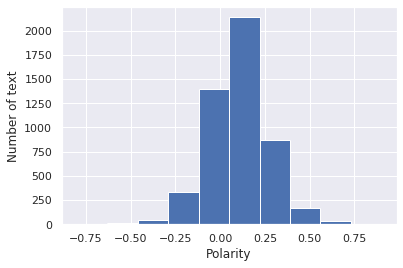

In [13]:
# ---- Show the polarities repartition
df['polarity'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of text")
#plt.savefig("polarity.png")

---

<center><h3>Text Informations</h3></center>

---

In [14]:
# ---- Extract statistics of the text 
df['char_count'] = df[TEXT].apply(len) # Number of characters in the string
df['word_count'] = df[TEXT].apply(lambda x: len(x.split())) # Number of words in the string 
df['word_density'] = df['char_count'] / (df['word_count']+1) # Density of word (in char)
#df['punctuation_count'] = df[TEXT].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
df['title_word_count'] = df[TEXT].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()])) # Number of words containing upper letter in first place 
#df['upper_case_word_count'] = df[TEXT].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

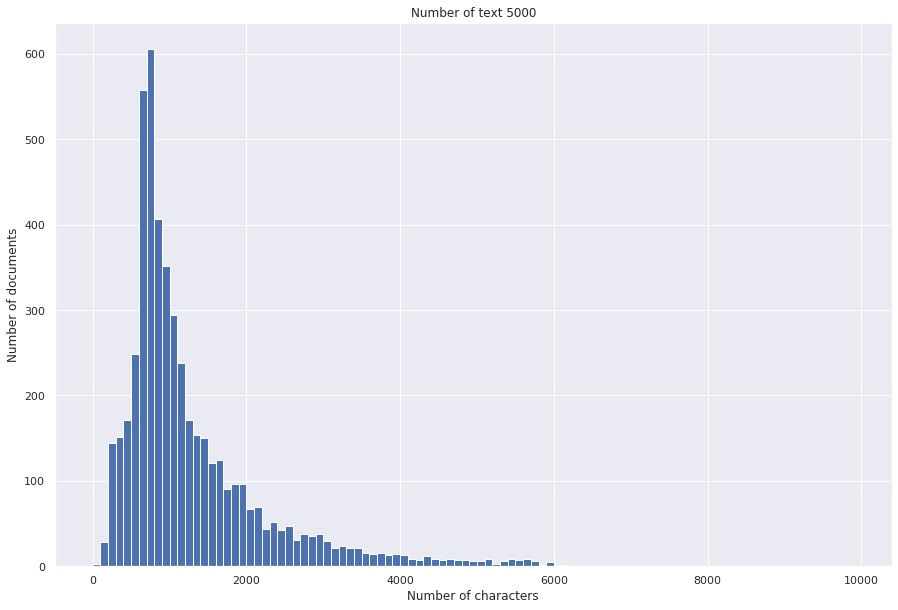

<Figure size 432x288 with 0 Axes>

In [15]:
# ---- Show the number of characters per document
plt.figure(figsize=(15,10))
max_x = 10000 if df.char_count.max()>10000 else df.char_count.max()
plt.hist(df.char_count.values, bins = range(0, max_x, 100))
plt.title(f"Number of {TEXT} {df.shape[0]}")
plt.xlabel("Number of characters")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()
plt.savefig("numb_char.png")

---

<center><h3>Classes repartition</h3></center>

---

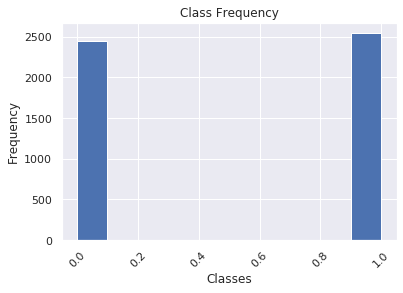

In [16]:
# ---- histogram of the class frequency
df[LABEL].hist(xrot=45)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Frequency")
plt.savefig("distrib_classes.png")

---

<center><h2>N-grams</h2></center>

---

<center><h3>Unigrams</h3></center>

---

In [17]:
# ---- Load stopwords 
if language=="fr":
    stop_word = np.loadtxt("stopwords-fr.txt", dtype=str)
if language=="en":
    stop_word = np.loadtxt("stopwords_en.txt", dtype=str)

---

In [18]:
number = 20
common_words = preproc.get_top_n_words(df[TEXT], 20)
df1 = pd.DataFrame(common_words, columns = ['words' , 'count'])

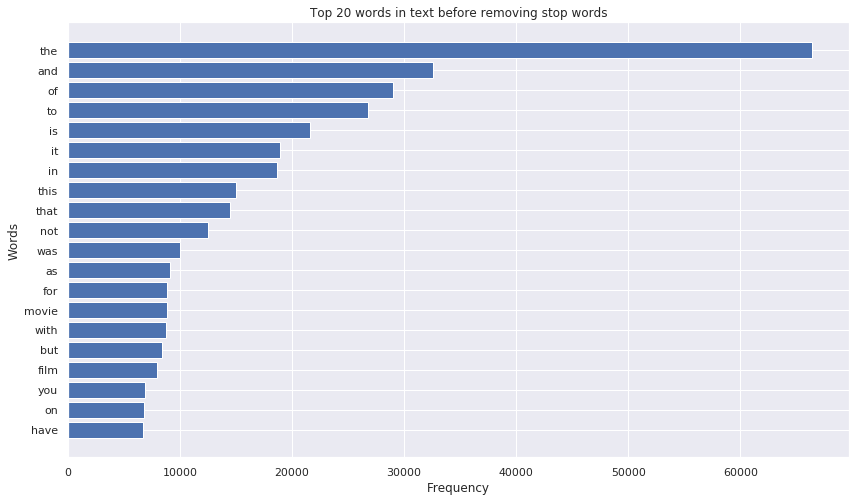

In [19]:
plt.figure(figsize=(14,8))
plt.barh(df1["words"][::-1], df1["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

---

<center><h3>Unigrams without stopwords</h3></center>

---

In [20]:
number=20
common_words = preproc.get_top_n_words_sw(df[TEXT], stop_word, language, number)
df2 = pd.DataFrame(common_words, columns = ['words' , 'count'])

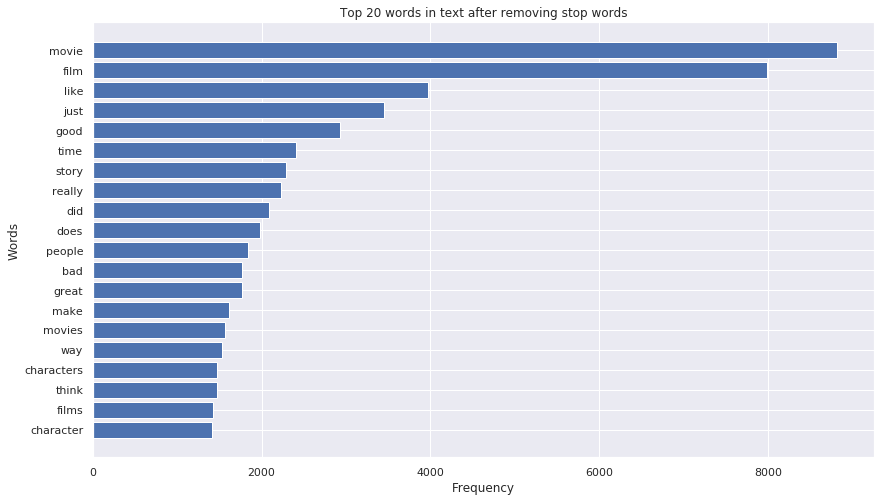

In [21]:
plt.figure(figsize=(14,8))
plt.barh(df2["words"][::-1], df2["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)

---

<center><h3>Bigrams</h3></center>

---

In [22]:
number = 20
common_words = preproc.get_top_n_bigram(df[TEXT], number)

In [23]:
df3 = pd.DataFrame(common_words, columns = ['words' , 'count'])

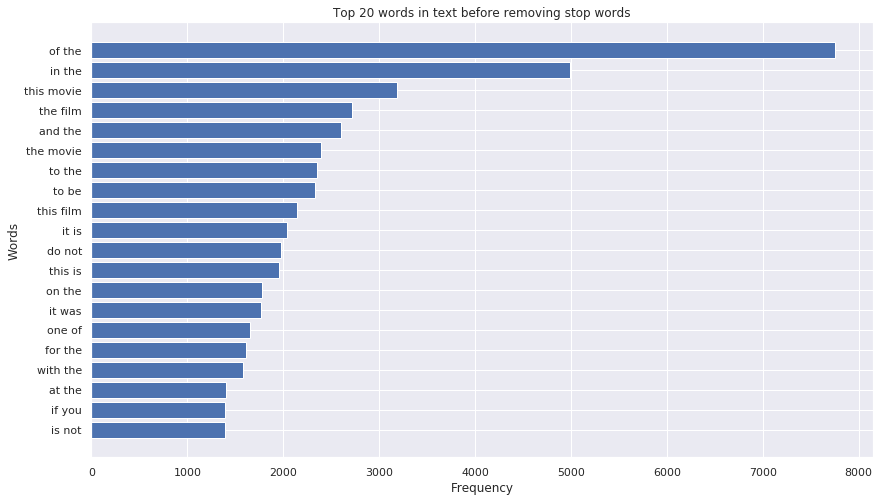

In [24]:
plt.figure(figsize=(14,8))
plt.barh(df3["words"][::-1], df3["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)

---

<center><h3>Bigrams without stopwords</h3></center>

---

In [25]:
number = 20
common_words = preproc.get_top_n_bigram_sw(df[TEXT], stop_word, language, number)

In [26]:
df4 = pd.DataFrame(common_words, columns = ['words' , 'count'])

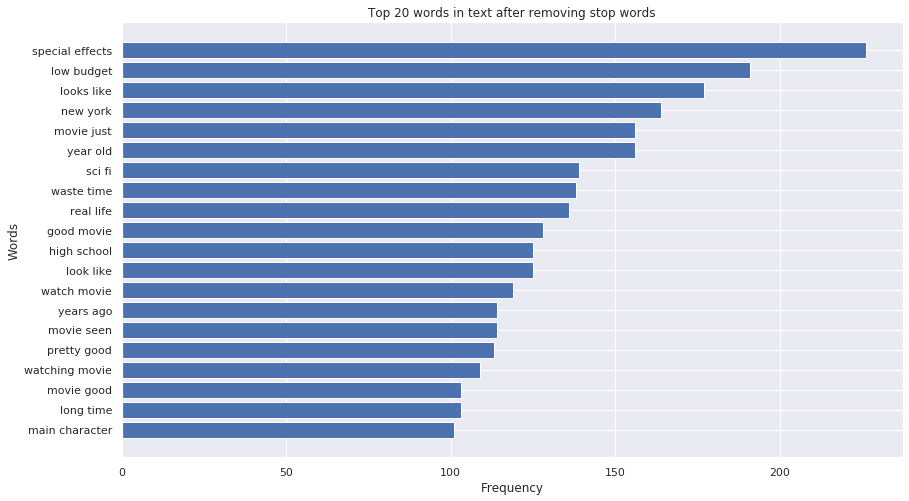

In [27]:
plt.figure(figsize=(14,8))
plt.barh(df4["words"][::-1], df4["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)

---

<center><h3>Trigrams</h3></center>

---

In [28]:
number = 20
common_words = preproc.get_top_n_trigram(df[TEXT], number)

In [29]:
df5 = pd.DataFrame(common_words, columns = ['words' , 'count'])

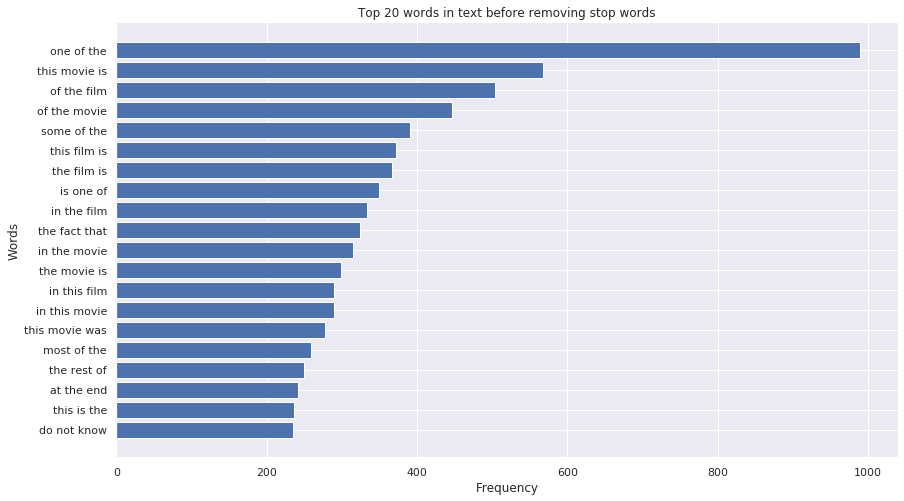

In [30]:
plt.figure(figsize=(14,8))
plt.barh(df5["words"][::-1], df5["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text before removing stop words" %(number))
plt.grid(True)
plt.savefig("trigrams.png")

---

<center><h3>Trigrams without stop words</h3></center>

---

In [31]:
number = 30
common_words = preproc.get_top_n_trigram_sw(df[TEXT], stop_word, language, number)

In [32]:
df6 = pd.DataFrame(common_words, columns = ['words' , 'count'])

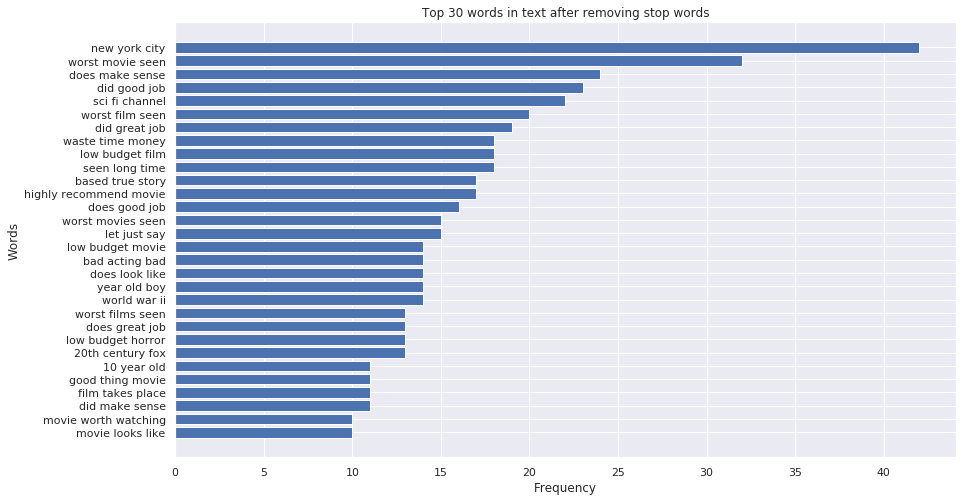

In [33]:
plt.figure(figsize=(14,8))
plt.barh(df6["words"][::-1], df6["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)
#plt.savefig("trigram_sw.png")

---

<center><h3>5-grams without stop words</h3></center>

---

In [34]:
number = 30
common_words = preproc.get_top_n_5grams_sw(df[TEXT], stop_word, language, number)

In [35]:
df7 = pd.DataFrame(common_words, columns = ['words' , 'count'])

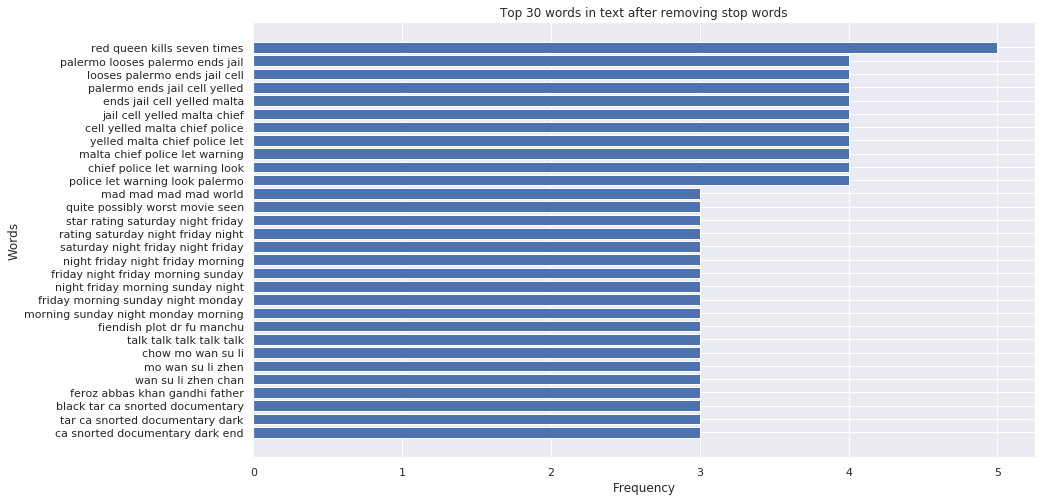

In [36]:
plt.figure(figsize=(14,8))
plt.barh(df7["words"][::-1], df7["count"][::-1])
plt.ylabel("Words")
plt.xlabel("Frequency")
plt.title("Top %d words in text after removing stop words" %(number))
plt.grid(True)
#plt.savefig("trigram_sw.png")

---

<center><h3>Part-of-Speech Tagging (POS)</h3></center>

---

In [37]:
def pos_ner_lemma(df, column, lang="fr"):
    '''
    Function to do part-of-speech with stanza librairy. The pipeline is configured to 
    tokenize, mwt, pos, lemma, ner parameters, it will does part-of-speech, lemmatized words
    and name entity recognition.
    @param df: (pandas.dataframe) dataframe containing the data
    @param column: (str) name of the column containing text
    @param lang: (str) language of the text
    '''
    print("Building an French pipeline...")
    nlp = stanza.Pipeline(lang, processors="tokenize,mwt,pos,lemma,ner") # creation of the pipeline
    text_lem = []
    text_pos = []
    text_ner = []
    for i in tqdm(df[column]): # loop on each text 
        doc = nlp(i) # fit the text with the pipeline 
        try:
            text_lem.append(' '.join([word.lemma for sent in doc.sentences for word in sent.words])) # lemmatize 
        except: # if 
            text_lem.append('') 
        try:
            text_pos.append(' '.join([f'word: {word.text} upos: {word.upos} xpos: {word.xpos} feats: \
            {word.feats if word.feats else "_"}' for sent in doc.sentences for word in sent.words])) # pos 
        except:
            text_pos.append('')
        try:
            text_ner.append(' '.join([f'token: {token.text} ner: {token.ner}' for sent in doc.sentences for token in sent.tokens])) # NER
        except:
            text_ner.append('')
            
    df.loc[:,column+"_lemma"] = text_lem
    df.loc[:,column+"_pos"] = text_pos
    df.loc[:,column+"_ner"] = text_ner
    
    return df

In [38]:
if part_of_speech:
    df = pos_ner_lemma(df, TEXT, lang=language)

---

<center><h3>Prepare data for ML Classic</h3></center>

---

In [39]:
df.loc[:,TEXT+"_sw"] = df.loc[:,TEXT].progress_apply(lambda x : preproc.remove_stop_words(x, stop_word))

100%|██████████| 5000/5000 [00:10<00:00, 471.25it/s]


In [40]:
if df[TEXT+"_sw"].isnull().sum()>0:
    print("Empty text")
    df[TEXT+"_sw"][df[TEXT+"_sw"].isnull()] = "empty_text"

---

---

<h1><center>Machine Learning</center></h1>

---

---

In [41]:
# split the dataset into training and validation datasets 
# ML classic 
train_x_sw, valid_x_sw, y_train_sw, y_valid_sw = model_selection.train_test_split(df[TEXT+"_sw"], df[LABEL], random_state=42, stratify=df[LABEL], test_size=0.2)

# For Embeddings
train_x, valid_x, y_train, y_valid = model_selection.train_test_split(df[TEXT], df[LABEL], random_state=42, stratify=df[LABEL], test_size=0.2)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_sw = encoder.fit_transform(y_train_sw)
valid_y_sw = encoder.fit_transform(y_valid_sw)
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

---

<center><h3>Classes Weight</h3></center>

---

In [42]:
# Compute the class weight with sklearn 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=7667     1
17737    0
2055     1
6063     1
23400    1
        ..
17023    1
7338     1
13370    1
14097    0
21524    0
Name: label, Length: 4000, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [43]:
print(*[f'Class weight: {round(i[0],4)}\tclass: {i[1]}' for i in zip(class_weights, np.unique(y_train))], sep='\n')

Class weight: 1.0194	class: 0
Class weight: 0.9814	class: 1


In [44]:
# Determined if the dataset is balanced or imbalanced 
ratio = np.min(df.label.value_counts()) / np.max(df.label.value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")
    #from imblearn.over_sampling import ADASYN
    # put class for debalanced data 
    # in progress


The dataset is balanced (ratio=0.962)


---

<h2>Save Unique Labels</h2>

---

In [45]:
# Keep the unique label corresponding to their encoding correspondance
labels = df[LABEL].unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()
if any(str(i).isdigit() for i in labels) and len(labels)==2:
    labels = ["negative", "positive"]

---

<h3>One-Hot encoding (CountVectorizing)</h3>

The part One-Hot encoding and TF-IDF are extracted from <a href="https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/">A Comprehensive Guide to Understand and Implement Text Classification in Python, SHIVAM BANSAL, April 23, 2018</a>

---

In [46]:
%%time
# create a One-Hot encoding object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df[TEXT]+"_sw")

# transform the training and validation data 
xtrain_count =  count_vect.transform(train_x_sw)
xvalid_count =  count_vect.transform(valid_x_sw)

CPU times: user 2.61 s, sys: 0 ns, total: 2.61 s
Wall time: 2.67 s


---

<h3>TF-IDF</h3>

---

In [47]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df[TEXT])
xtrain_tfidf =  tfidf_vect.transform(train_x_sw)
xvalid_tfidf =  tfidf_vect.transform(valid_x_sw)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df[TEXT])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x_sw)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x_sw)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=5000) 
tfidf_vect_ngram_chars.fit(df[TEXT])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x_sw) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x_sw) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done
CPU times: user 22.2 s, sys: 1.25 s, total: 23.4 s
Wall time: 23.9 s


---

<h2>Load Pre-Trained model fastText</h2>

---

In [48]:
%%time
if language=="fr":
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
    !gunzip cc.fr.300.bin.gz
    pretrained = fasttext.FastText.load_model('cc.fr.300.bin')
if language=="en":
    #!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
    #!unzip crawl-300d-2M-subword.zip
    pretrained = fasttext.FastText.load_model('crawl-300d-2M-subword.bin')

CPU times: user 7.55 s, sys: 22.4 s, total: 29.9 s
Wall time: 38.5 s


---

<h2>Word Embeddings</h2>

---

In [49]:
%%time 
# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(df[TEXT])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 43302/43302 [00:01<00:00, 29813.58it/s]

CPU times: user 3.44 s, sys: 688 ms, total: 4.12 s
Wall time: 4.21 s


---

<center><h2>Multinomial Naive Bayes</h2></center>

---

In [50]:
def metrics_ML(clf, X, Y, X_test, Y_test, gb=False):
    '''
    Function to compute a classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    model_, pred, time_train, score_ = classifier_model(clf, X, Y, X_test, Y_test)
    print("Execution time : %.3f s" %(time_train))
    print(f"Score : {round(100*score_,2)} %" )
    print("\nClassification Report\n")
    print(classification_report(Y_test, pred, target_names=labels))
    cm = confusion_matrix(Y_test, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)
    print("\n")
    Metric.precision_recall_curve(model_,  X_test, Y_test, labels, gb=gb)
    print("\n")
    Metric.roc_auc_curve(model_,  X_test, Y_test, labels, gb=gb)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(Y_test,  pred),2)}%\n\n")

In [51]:
def classifier_model(clf, X, y, x_test, y_test):
    '''
    Function to compute a classifier model
    @param clf: (model) classifier model
    @param X: (matrix) training x data
    @param y: (list) train labels - ground truth
    @param x_test: (matrix) matrix of test x data
    @param y_test: (list) list of test labels
    @return model_NB: (model) train model
    @return pred: (list) list of predicted labels
    @return end: (float) fit time of the model
    @return model.score(): (float) accuracy of the model
    '''
    
    start = time.time()
    clf.fit(X, y)
    end = time.time() - start
    pred = clf.predict(x_test)
    
    #accuracy = accuracy_score(y_test, pred)
    
    return clf, pred, end, clf.score(x_test, y_test)#, accuracy


Multinomial Naive Bayes for One-Hot encoding

Execution time : 0.026 s
Score : 83.5 %

Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.86      0.84       490
    positive       0.86      0.81      0.83       510

    accuracy                           0.83      1000
   macro avg       0.84      0.84      0.83      1000
weighted avg       0.84      0.83      0.83      1000


Confusion Matrix





Model: f1-score=0.834 AUC=0.896




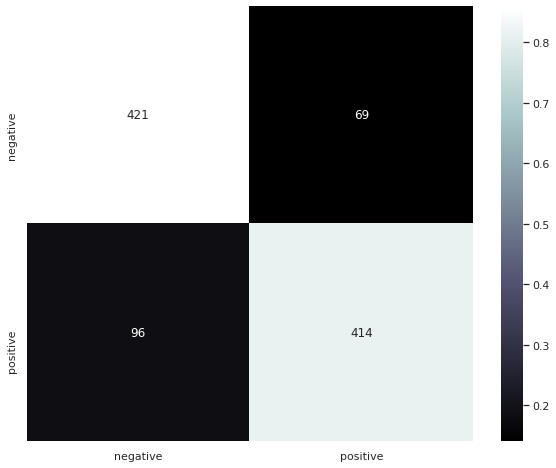

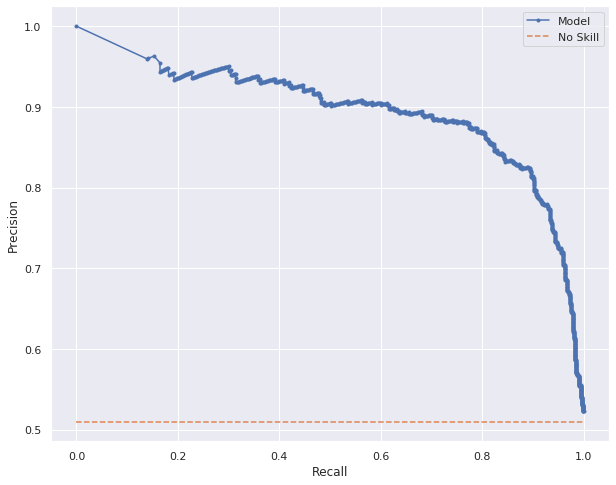




ROC AUC=0.904 



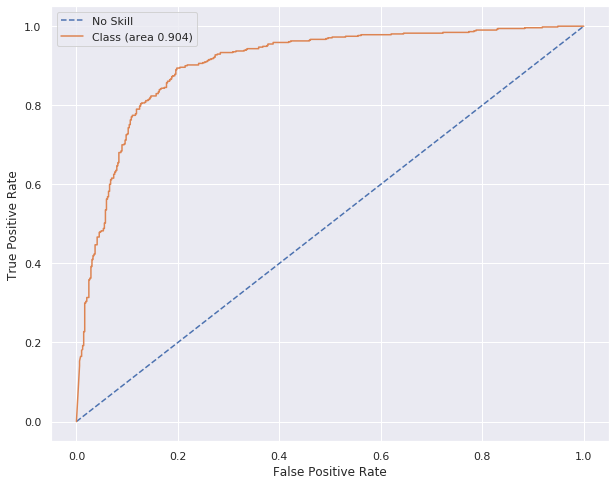



Cohen's kappa: 67.02%




In [52]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for One-Hot encoding\n")
    metrics_ML(naive_bayes.MultinomialNB(), xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Multinomial Naive Bayes for TF-IDF

Execution time : 0.012 s
Score : 86.1 %

Classification Report

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86       490
    positive       0.86      0.87      0.87       510

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Confusion Matrix





Model: f1-score=0.865 AUC=0.933




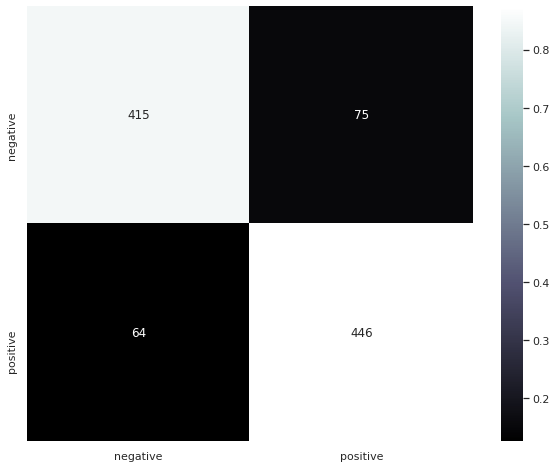

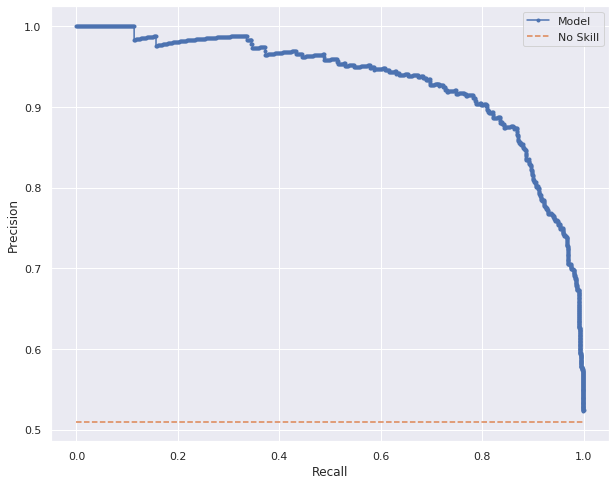




ROC AUC=0.932 



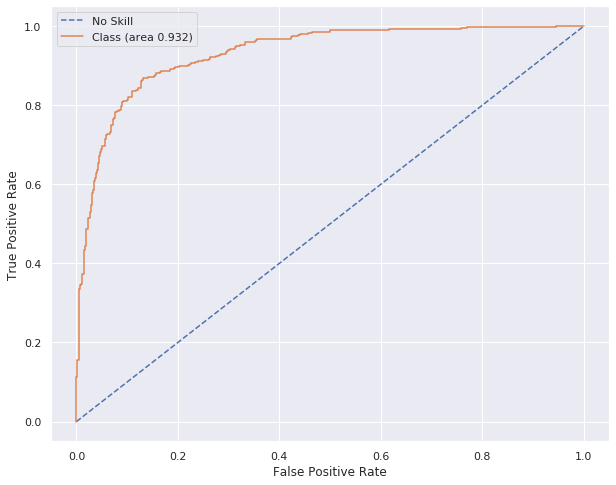



Cohen's kappa: 72.18%




In [53]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for TF-IDF\n")
    metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Multinomial Naive Bayes for TF-IDF n-grams

Execution time : 0.005 s
Score : 70.2 %

Classification Report

              precision    recall  f1-score   support

    negative       0.70      0.68      0.69       490
    positive       0.70      0.73      0.71       510

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000


Confusion Matrix





Model: f1-score=0.713 AUC=0.796




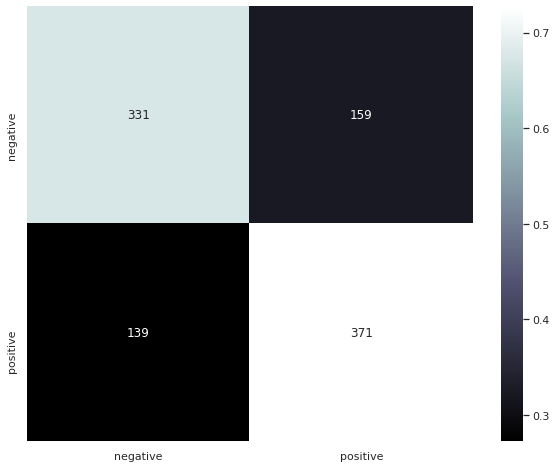

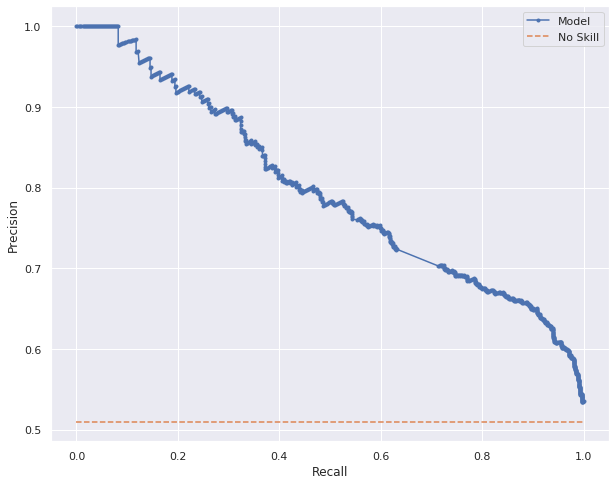




ROC AUC=0.790 



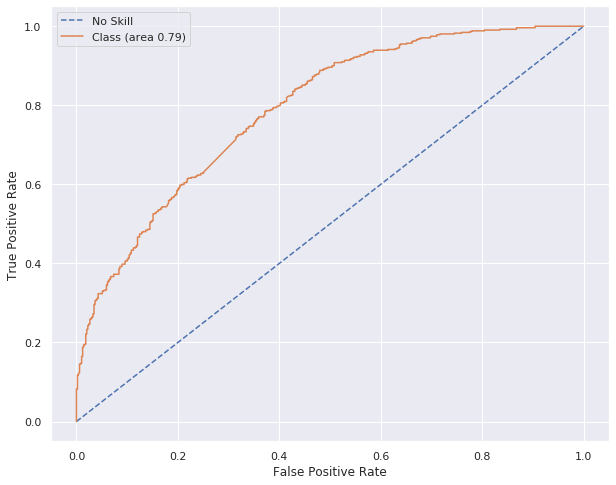



Cohen's kappa: 40.33%




In [54]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for TF-IDF n-grams\n")
    metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Multinomial Naive Bayes for TF-IDF char n-grams

Execution time : 0.041 s
Score : 79.9 %

Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.74      0.78       490
    positive       0.78      0.85      0.81       510

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000


Confusion Matrix





Model: f1-score=0.812 AUC=0.892




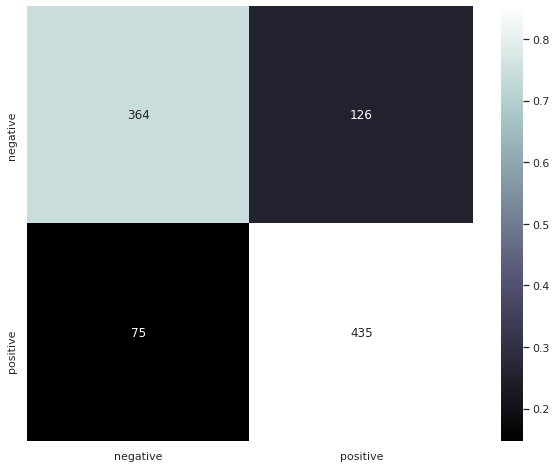

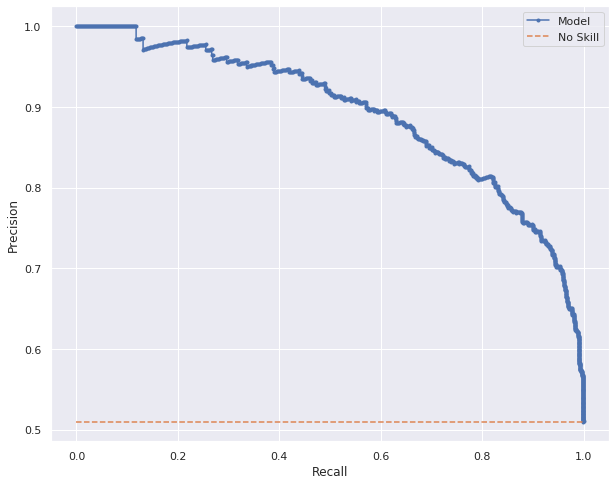




ROC AUC=0.890 



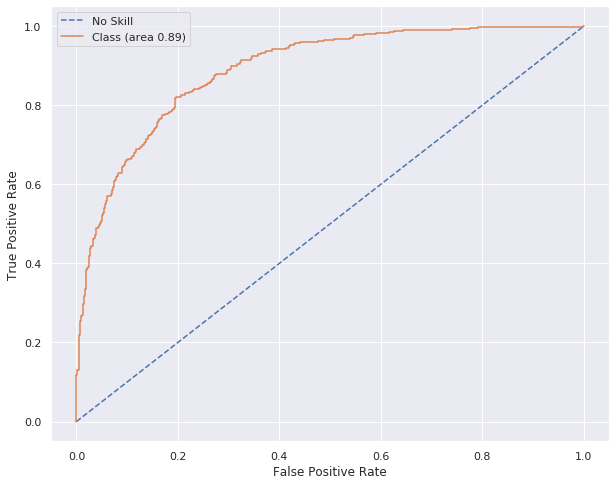



Cohen's kappa: 59.7%




In [55]:
if multinomial_naive_bayes:
    print("\nMultinomial Naive Bayes for TF-IDF char n-grams\n")
    metrics_ML(naive_bayes.MultinomialNB(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

---

<center><h2>Logistic Regression</h2></center>

---


Logistic Regression for One-Hot encoding

Execution time : 1.665 s
Score : 85.7 %

Classification Report

              precision    recall  f1-score   support

    negative       0.86      0.84      0.85       490
    positive       0.85      0.87      0.86       510

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Confusion Matrix





Model: f1-score=0.861 AUC=0.926




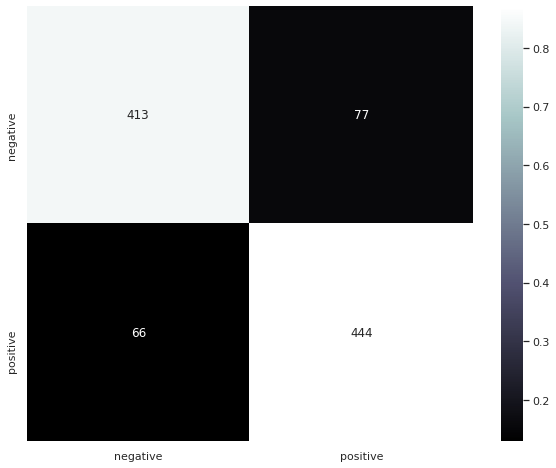

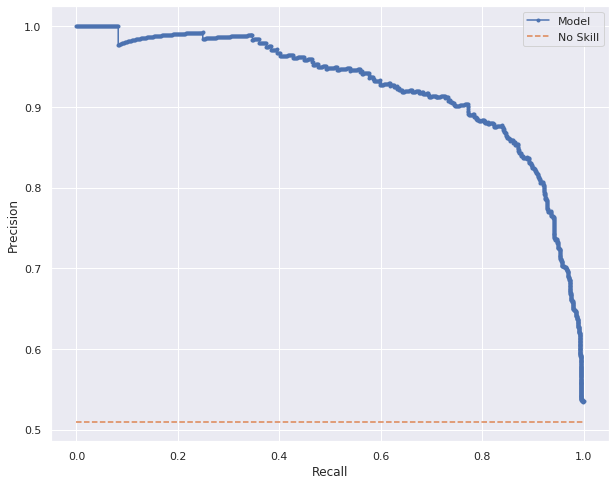




ROC AUC=0.924 



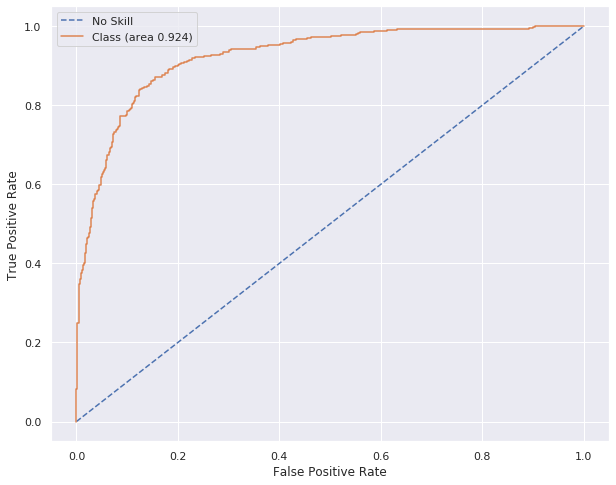



Cohen's kappa: 71.38%




In [57]:
if logistic_regression:
    print("\nLogistic Regression for One-Hot encoding\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Logistic Regression for TF_IDF

Execution time : 0.169 s
Score : 85.5 %

Classification Report

              precision    recall  f1-score   support

    negative       0.87      0.83      0.85       490
    positive       0.84      0.88      0.86       510

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000


Confusion Matrix





Model: f1-score=0.861 AUC=0.945




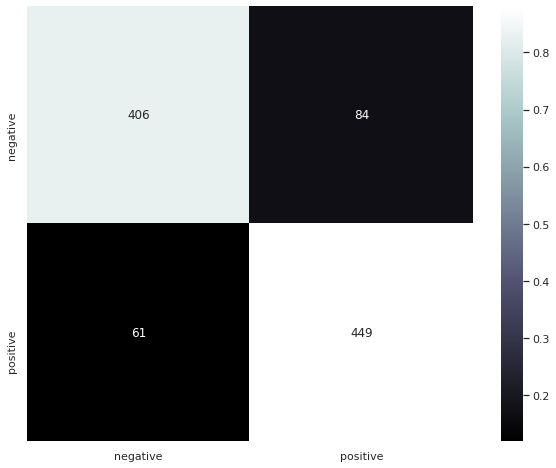

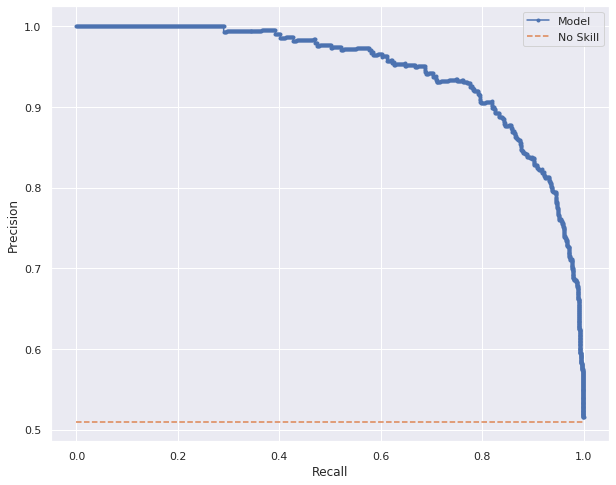




ROC AUC=0.940 



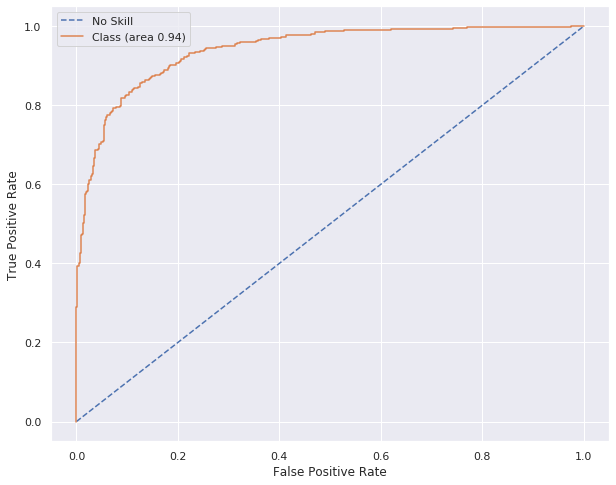



Cohen's kappa: 70.96%




In [58]:
if logistic_regression:
    print("\nLogistic Regression for TF_IDF\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Logistic Regression for TF_IDF n-grams

Execution time : 0.099 s
Score : 69.6 %

Classification Report

              precision    recall  f1-score   support

    negative       0.71      0.65      0.68       490
    positive       0.69      0.74      0.71       510

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.69      1000
weighted avg       0.70      0.70      0.70      1000


Confusion Matrix





Model: f1-score=0.713 AUC=0.782




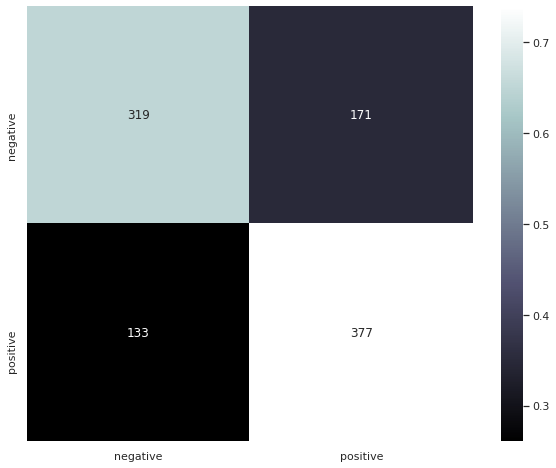

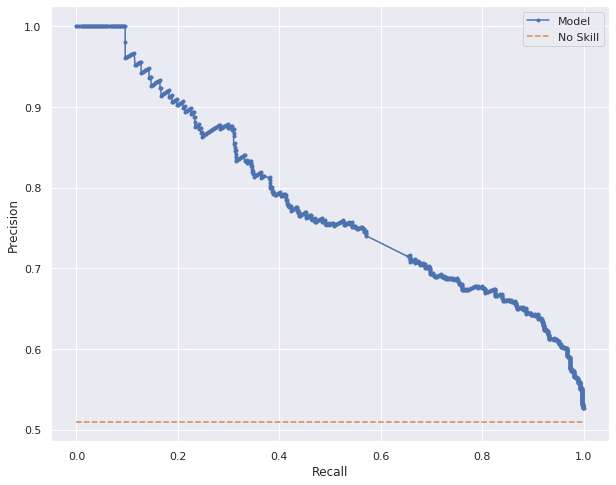




ROC AUC=0.779 



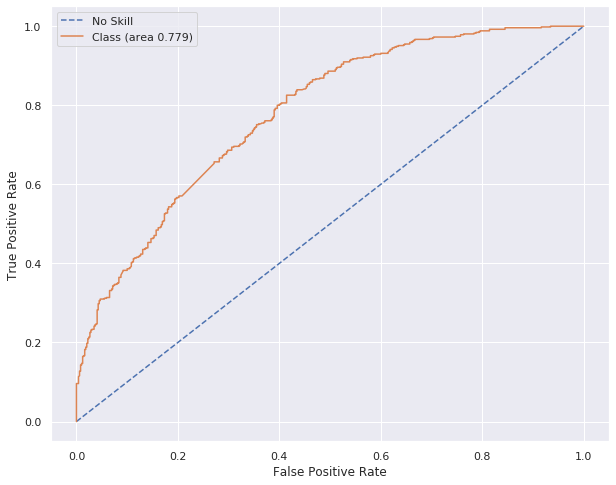



Cohen's kappa: 39.08%




In [59]:
if logistic_regression:
    print("\nLogistic Regression for TF_IDF n-grams\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Logistic Regression for TF_IDF char n-grams

Execution time : 0.343 s
Score : 82.1 %

Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.79      0.81       490
    positive       0.81      0.85      0.83       510

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


Confusion Matrix





Model: f1-score=0.829 AUC=0.901




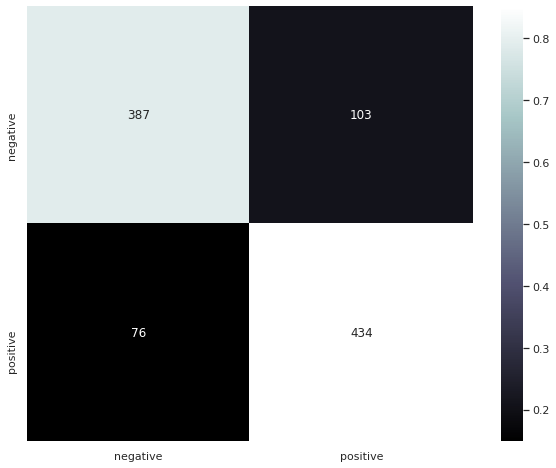

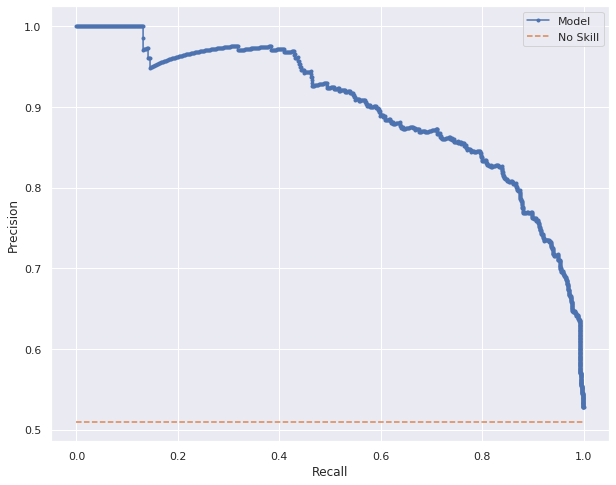




ROC AUC=0.900 



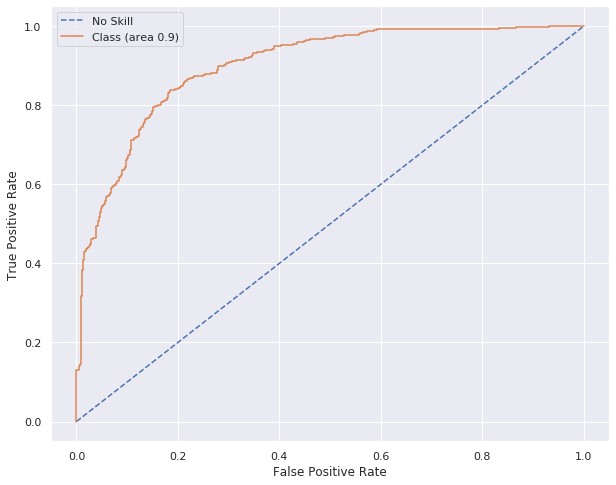



Cohen's kappa: 64.15%




In [60]:
if logistic_regression:
    print("\nLogistic Regression for TF_IDF char n-grams\n")
    metrics_ML(linear_model.LogisticRegression(max_iter=1000,  random_state=42),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

---

<center><h2>SVM</h2></center>

---


SVM for One-Hot encoding

Execution time : 16.891 s
Score : 83.2 %

Classification Report

              precision    recall  f1-score   support

    negative       0.87      0.77      0.82       490
    positive       0.80      0.89      0.84       510

    accuracy                           0.83      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.84      0.83      0.83      1000


Confusion Matrix





Model: f1-score=0.844 AUC=0.874




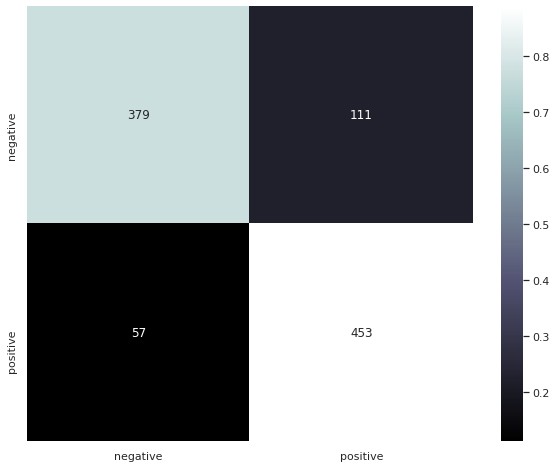

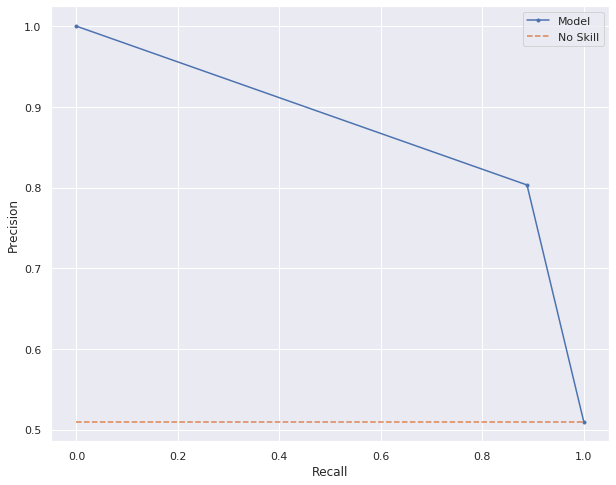




ROC AUC=0.831 



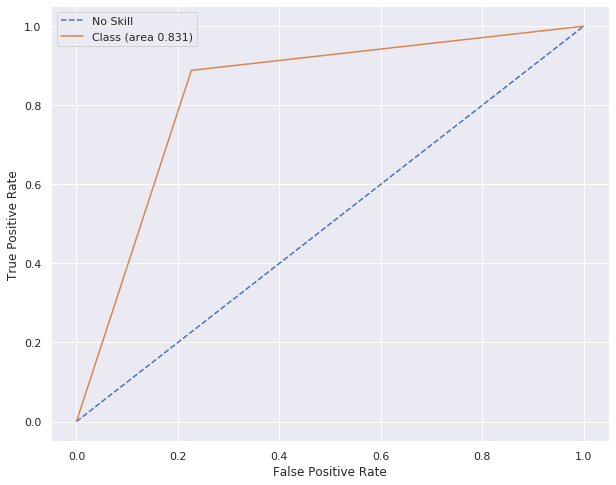



Cohen's kappa: 66.31%




In [61]:
if svm_model:
    print("\nSVM for One-Hot encoding\n")
    metrics_ML(svm.SVC(),  xtrain_count, train_y, xvalid_count, valid_y, gb=False)


SVM for TF_IDF

Execution time : 16.415 s
Score : 85.9 %

Classification Report

              precision    recall  f1-score   support

    negative       0.88      0.82      0.85       490
    positive       0.84      0.90      0.87       510

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


Confusion Matrix





Model: f1-score=0.866 AUC=0.894




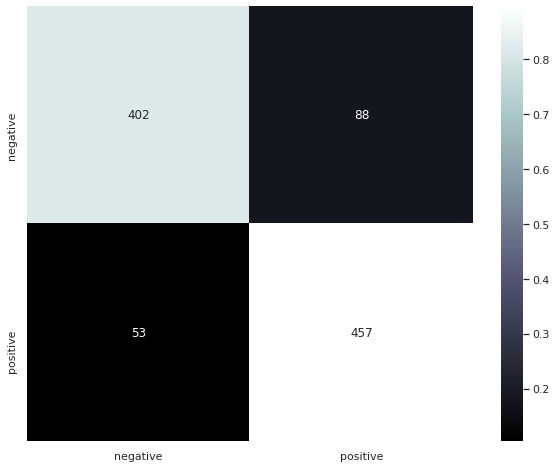

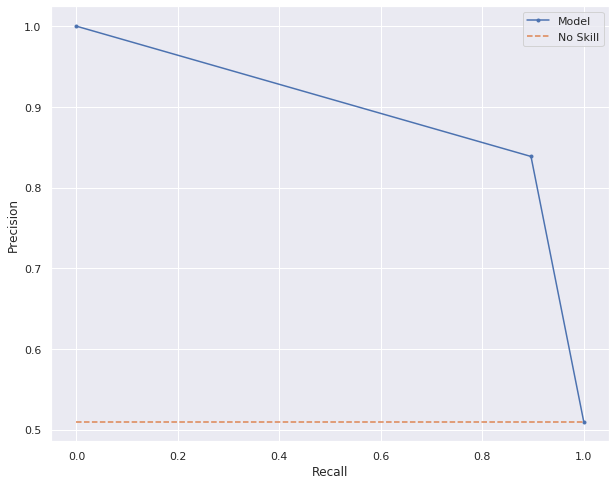




ROC AUC=0.858 



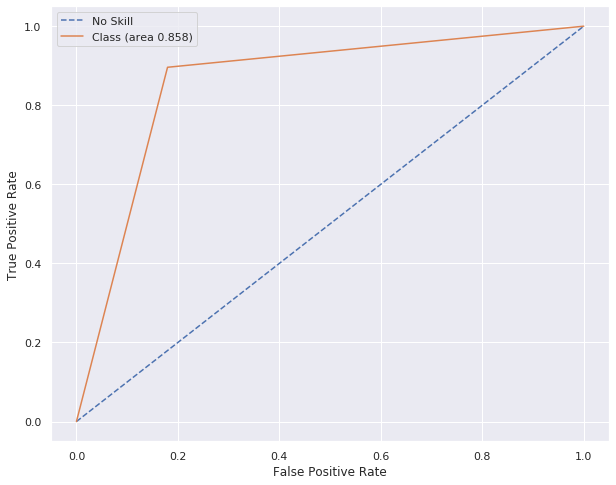



Cohen's kappa: 71.75%




In [62]:
if svm_model:
    print("\nSVM for TF_IDF\n")
    metrics_ML(svm.SVC(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=False)


SVM for TF_IDF n-grams

Execution time : 1.961 s
Score : 69.6 %

Classification Report

              precision    recall  f1-score   support

    negative       0.71      0.63      0.67       490
    positive       0.68      0.75      0.72       510

    accuracy                           0.70      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.70      0.69      1000


Confusion Matrix





Model: f1-score=0.717 AUC=0.781




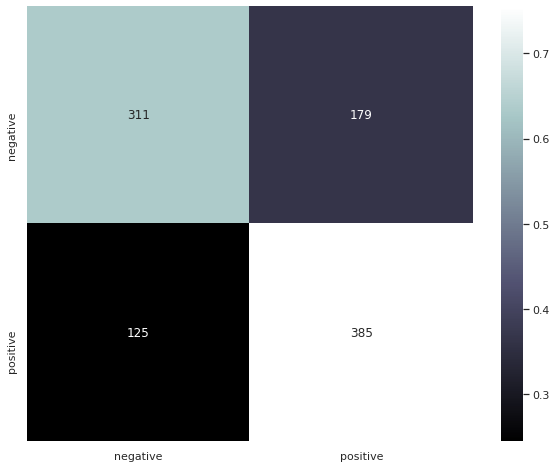

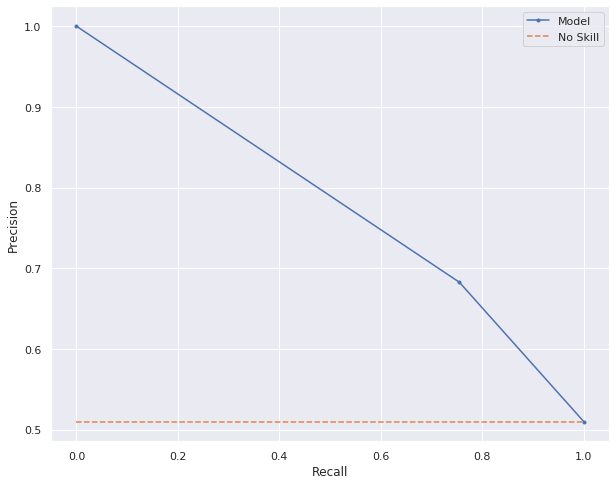




ROC AUC=0.695 



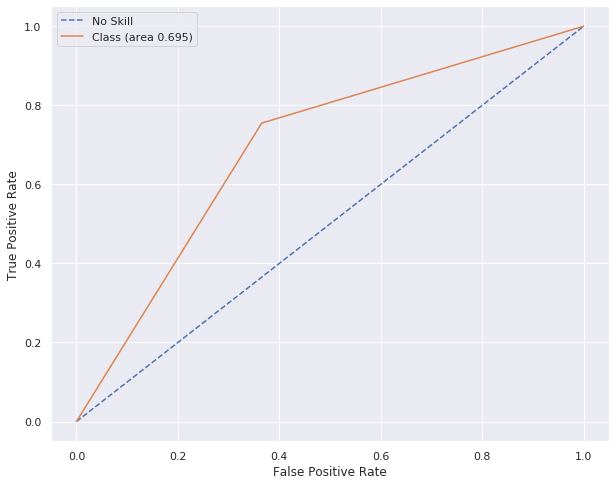



Cohen's kappa: 39.04%




In [63]:
if svm_model:
    print("\nSVM for TF_IDF n-grams\n")
    metrics_ML(svm.SVC(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=False)


SVM for TF_IDF char n-grams

Execution time : 98.263 s
Score : 82.1 %

Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.78      0.81       490
    positive       0.80      0.86      0.83       510

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


Confusion Matrix





Model: f1-score=0.830 AUC=0.867




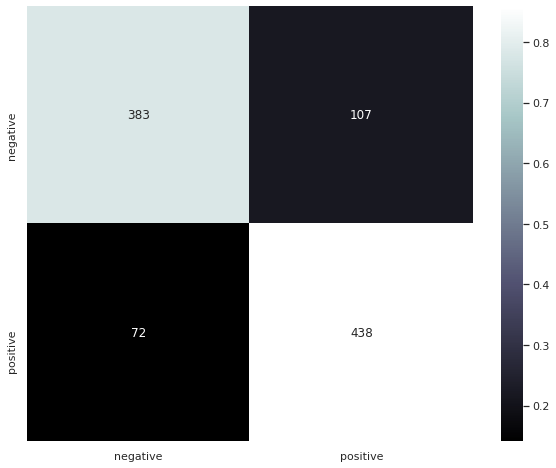

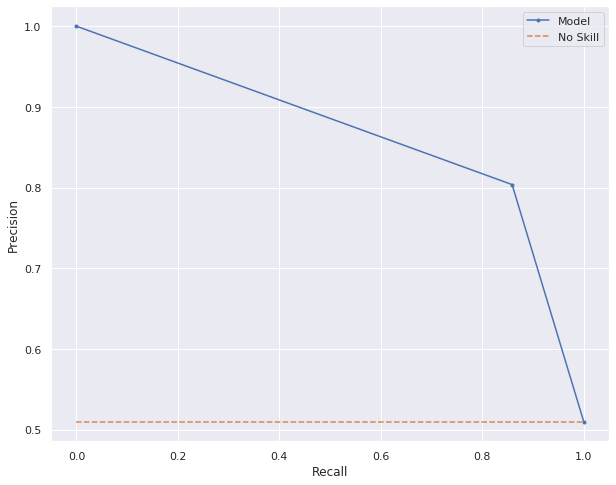




ROC AUC=0.820 



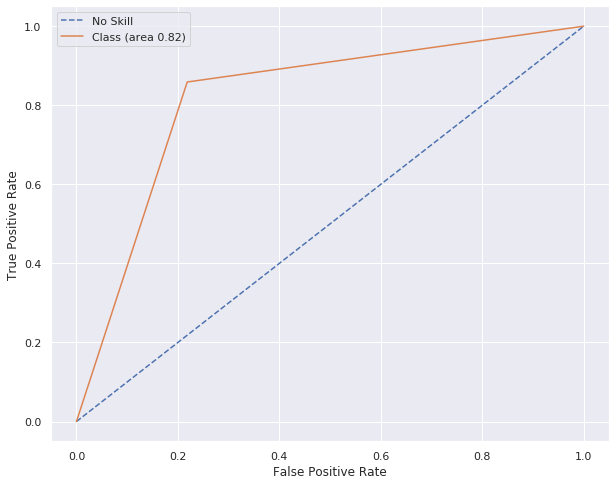



Cohen's kappa: 64.14%




In [64]:
if svm_model:
    print("\nSVM for TF_IDF char n-grams\n")
    metrics_ML(svm.SVC(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=False)

---

<h2><center>k-NN</center></h2>

---


k-NN for One-Hot encoding

Execution time : 0.004 s
Score : 65.0 %

Classification Report

              precision    recall  f1-score   support

    negative       0.65      0.63      0.64       490
    positive       0.65      0.67      0.66       510

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000


Confusion Matrix





Model: f1-score=0.661 AUC=0.704




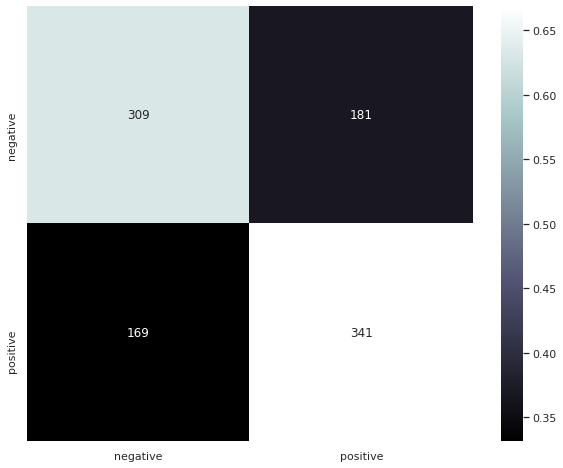

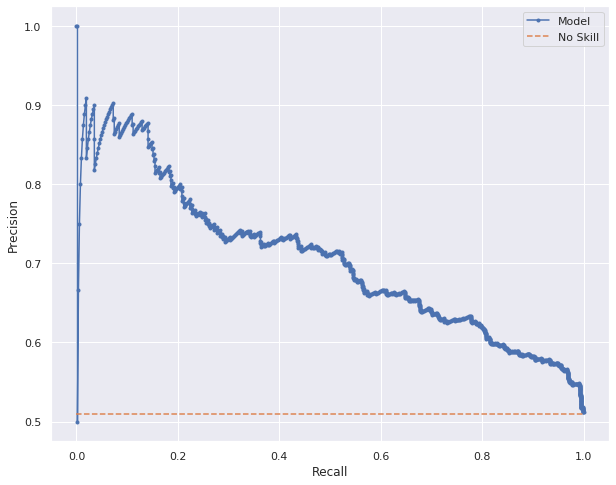




ROC AUC=0.711 



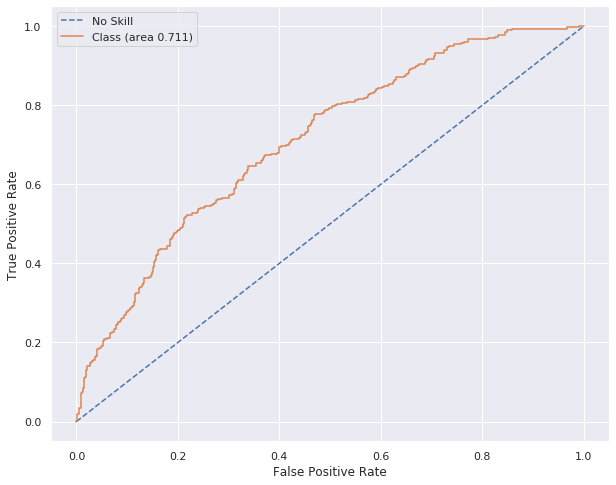



Cohen's kappa: 29.94%




In [65]:
if k_nn_model:
    print("\nk-NN for One-Hot encoding\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


k-NN for TF_IDF

Execution time : 0.003 s
Score : 75.6 %

Classification Report

              precision    recall  f1-score   support

    negative       0.76      0.73      0.75       490
    positive       0.75      0.78      0.77       510

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000


Confusion Matrix





Model: f1-score=0.765 AUC=0.833




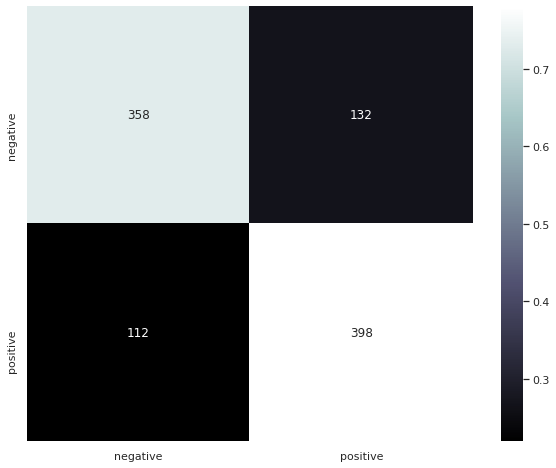

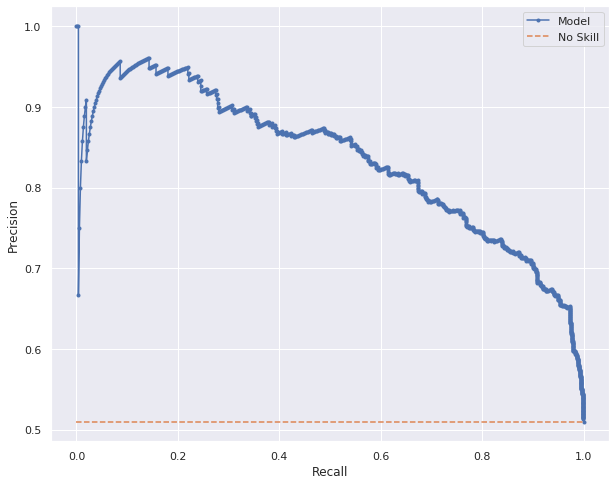




ROC AUC=0.845 



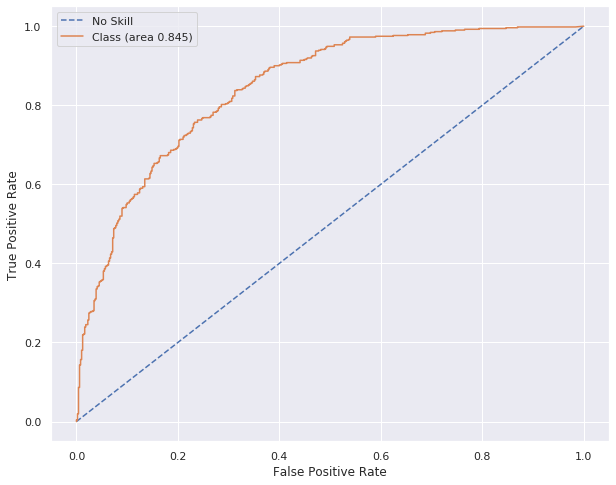



Cohen's kappa: 51.14%




In [66]:
if k_nn_model:
    print("\nk-NN for TF_IDF\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


k-NN for TF_IDF n-grams

Execution time : 0.004 s
Score : 55.0 %

Classification Report

              precision    recall  f1-score   support

    negative       0.56      0.39      0.46       490
    positive       0.55      0.70      0.61       510

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.54      1000
weighted avg       0.55      0.55      0.54      1000


Confusion Matrix





Model: f1-score=0.612 AUC=0.599




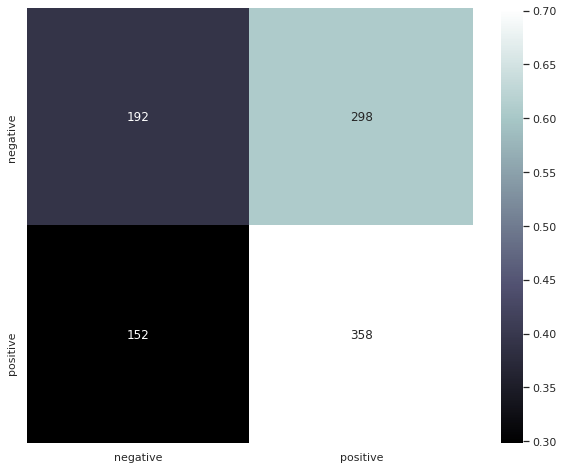

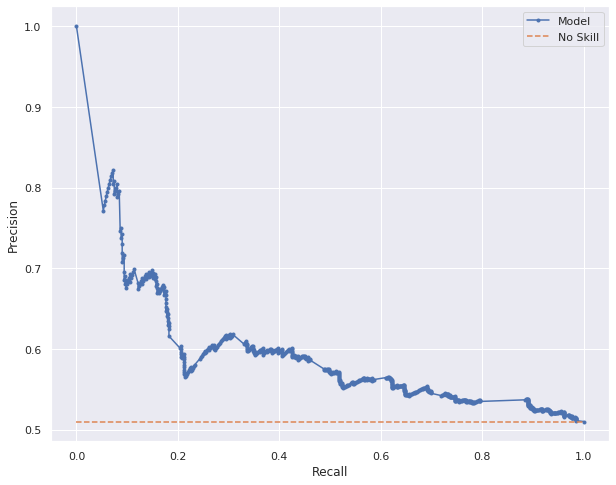




ROC AUC=0.581 



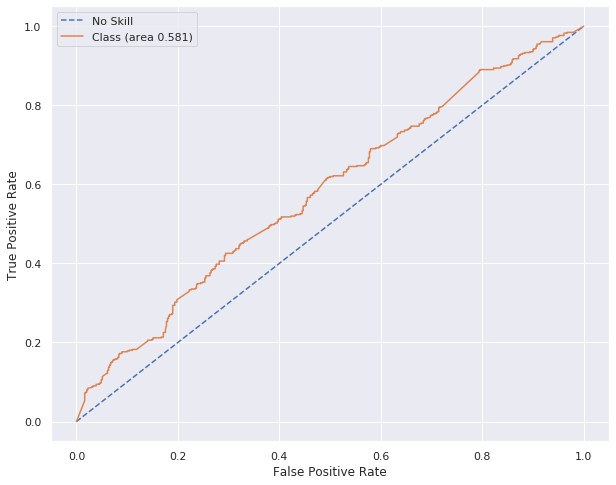



Cohen's kappa: 9.43%




In [67]:
if k_nn_model:
    print("\nk-NN for TF_IDF n-grams\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


k-NN for TF_IDF char n-grams

Execution time : 0.096 s
Score : 68.2 %

Classification Report

              precision    recall  f1-score   support

    negative       0.71      0.60      0.65       490
    positive       0.66      0.76      0.71       510

    accuracy                           0.68      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.69      0.68      0.68      1000


Confusion Matrix





Model: f1-score=0.709 AUC=0.726




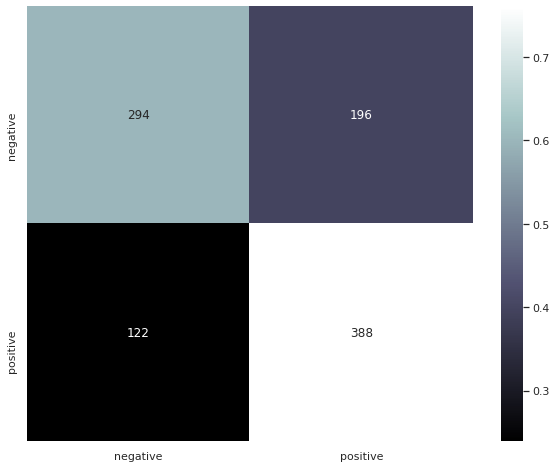

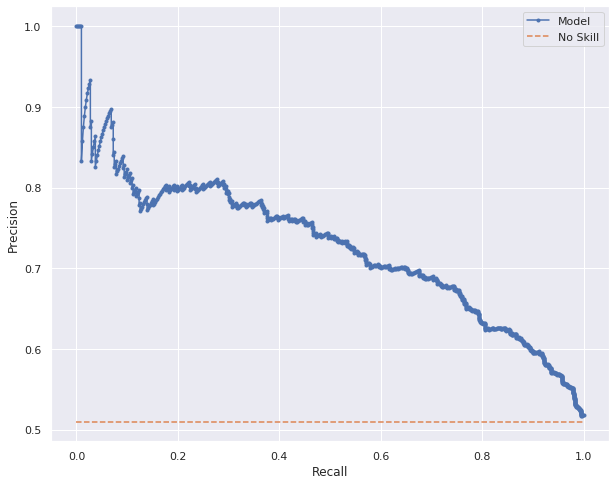




ROC AUC=0.740 



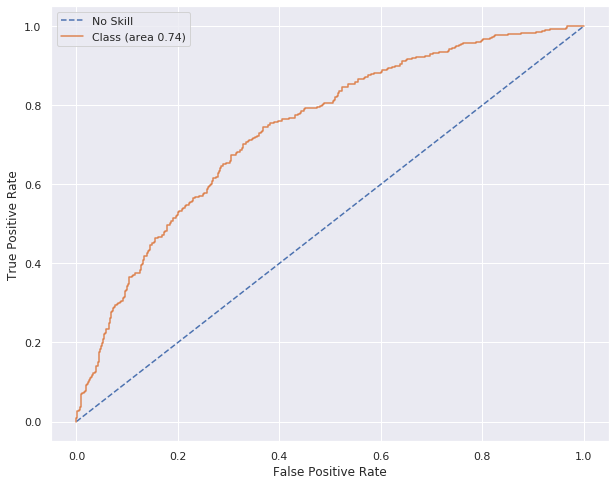



Cohen's kappa: 36.19%




In [68]:
if k_nn_model:
    print("\nk-NN for TF_IDF char n-grams\n")
    metrics_ML(neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

---

<center><h2>RandomForest</h2></center>

---


Random Forest for One-Hot encoding

Execution time : 10.897 s
Score : 84.5 %

Classification Report

              precision    recall  f1-score   support

    negative       0.86      0.82      0.84       490
    positive       0.83      0.87      0.85       510

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000


Confusion Matrix





Model: f1-score=0.851 AUC=0.901




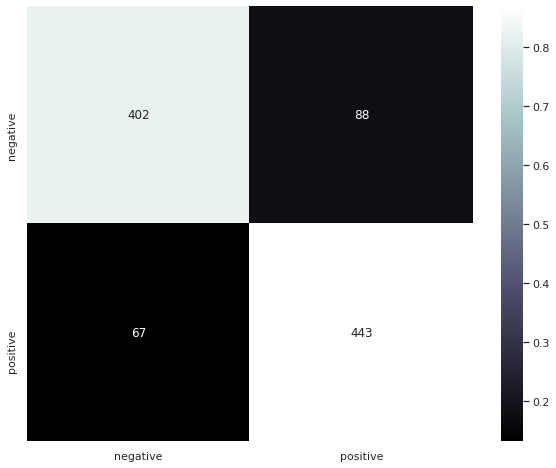

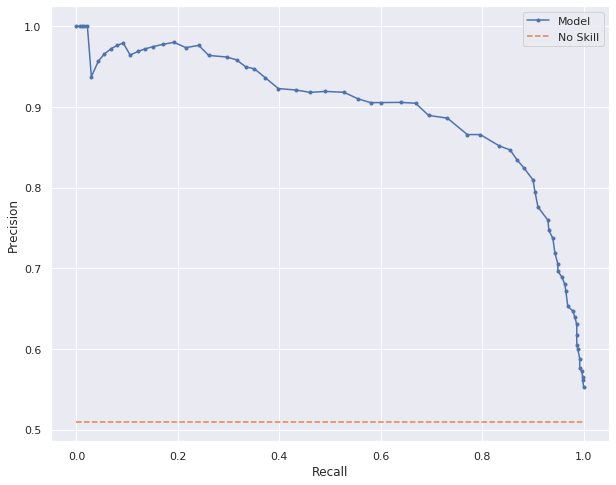




ROC AUC=0.907 



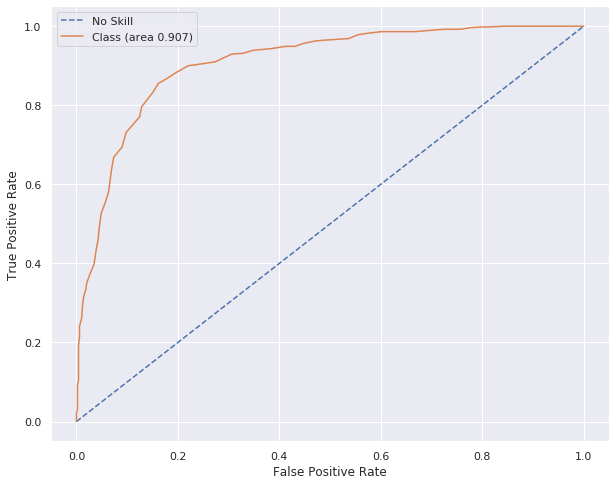



Cohen's kappa: 68.96%




In [69]:
if random_forest:
    print("\nRandom Forest for One-Hot encoding\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Random Forest for TF_IDF

Execution time : 5.692 s
Score : 84.1 %

Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.84      0.84       490
    positive       0.85      0.84      0.84       510

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000


Confusion Matrix





Model: f1-score=0.843 AUC=0.912




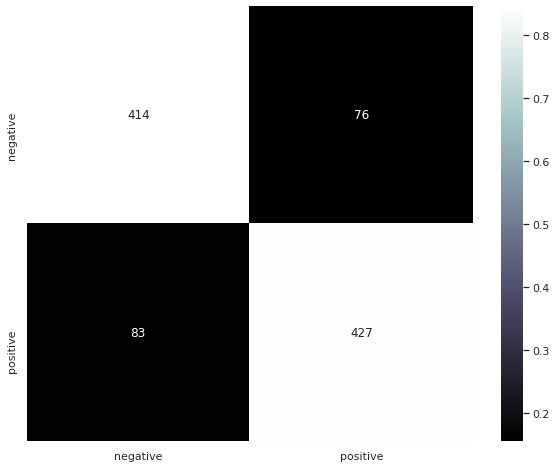

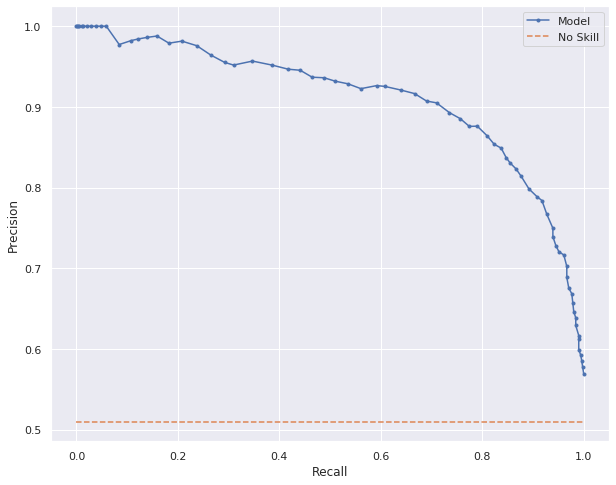




ROC AUC=0.915 



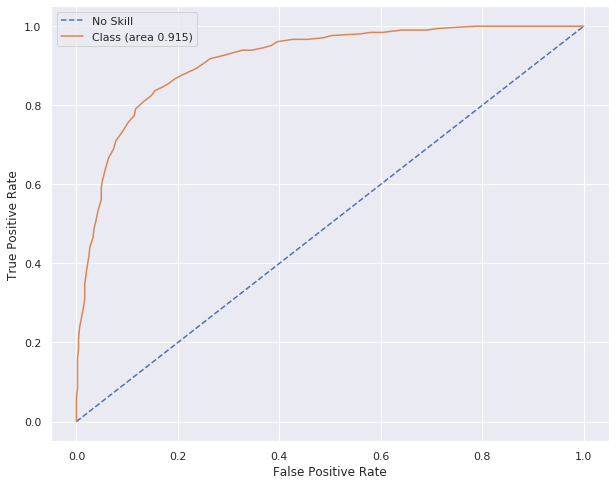



Cohen's kappa: 68.2%




In [70]:
if random_forest:
    print("\nRandom Forest for TF_IDF\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Random Forest for TF_IDF n-grams

Execution time : 7.728 s
Score : 68.7 %

Classification Report

              precision    recall  f1-score   support

    negative       0.68      0.67      0.68       490
    positive       0.69      0.70      0.70       510

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000


Confusion Matrix





Model: f1-score=0.696 AUC=0.745




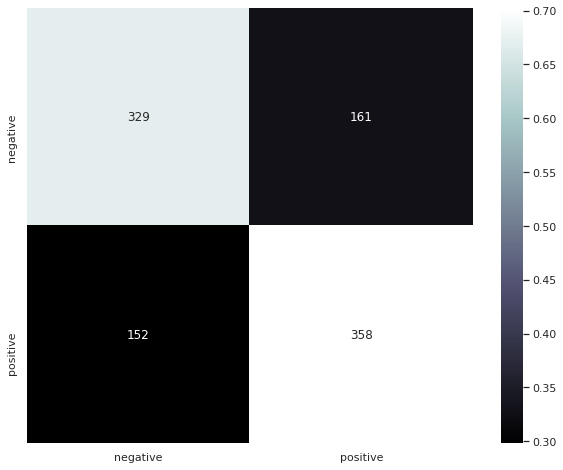

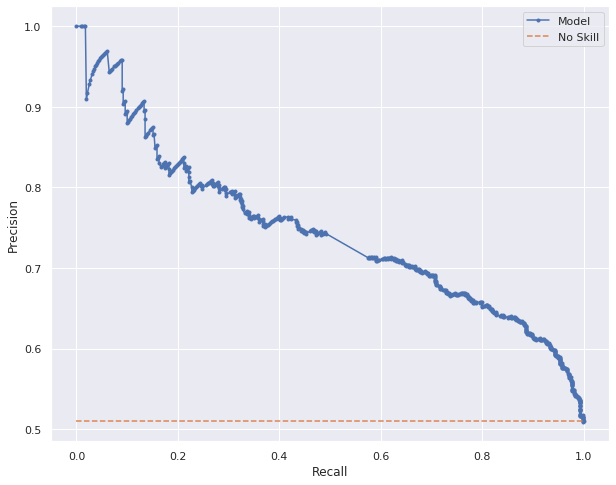




ROC AUC=0.752 



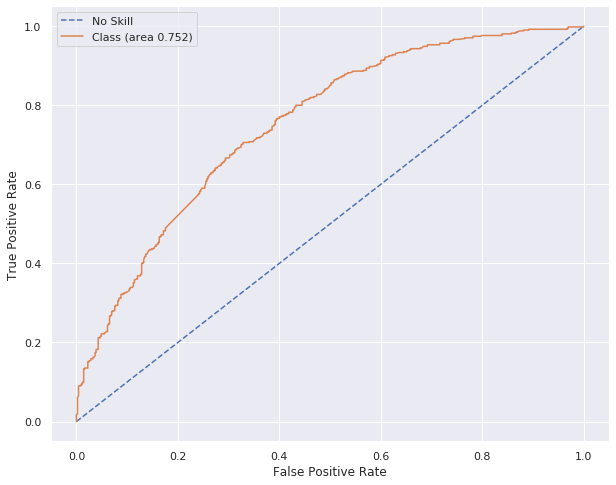



Cohen's kappa: 37.35%




In [71]:
if random_forest:
    print("\nRandom Forest for TF_IDF n-grams\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Random Forest for TF_IDF char n-grams

Execution time : 17.260 s
Score : 76.2 %

Classification Report

              precision    recall  f1-score   support

    negative       0.76      0.75      0.75       490
    positive       0.76      0.78      0.77       510

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000


Confusion Matrix





Model: f1-score=0.769 AUC=0.857




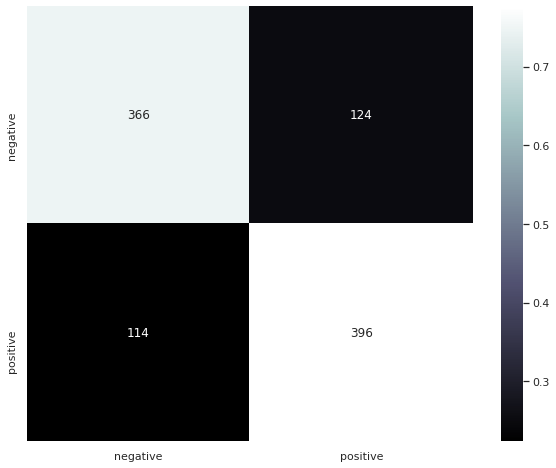

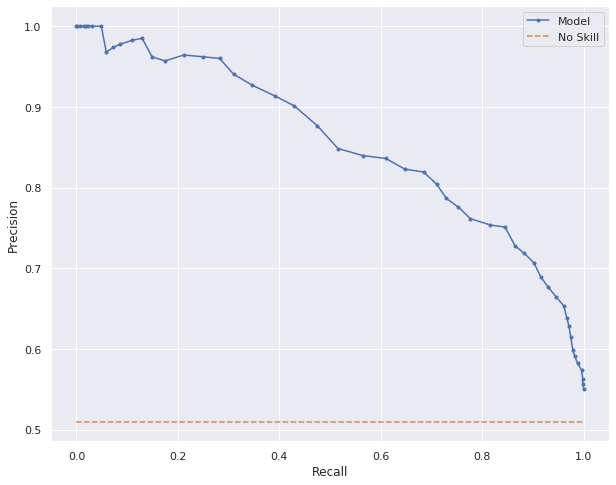




ROC AUC=0.856 



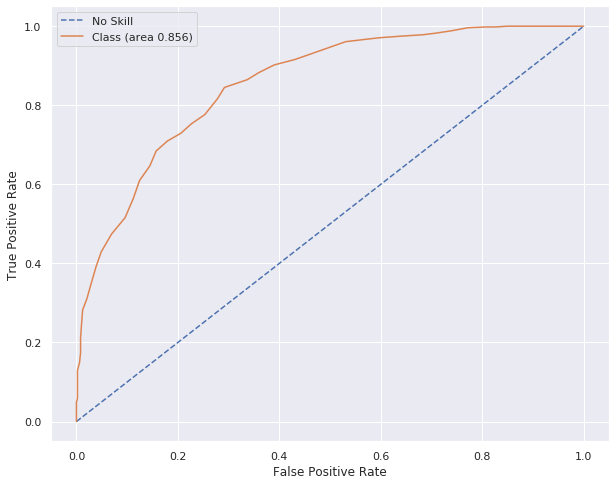



Cohen's kappa: 52.36%




In [72]:
if random_forest:
    print("\nRandom Forest for TF_IDF char n-grams\n")
    metrics_ML(ensemble.RandomForestClassifier(),  xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)

---

<center><h2>Stochastic Descent</h2></center>

---


Stochastic Gradient Descent with early stopping for One-Hot encoding

Early Stopping : 10 iterations without change
Execution time : 0.082 s
Score : 83.1 %

Classification Report

              precision    recall  f1-score   support

    negative       0.80      0.88      0.84       490
    positive       0.87      0.78      0.83       510

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000


Confusion Matrix





Model: f1-score=0.826 AUC=0.885




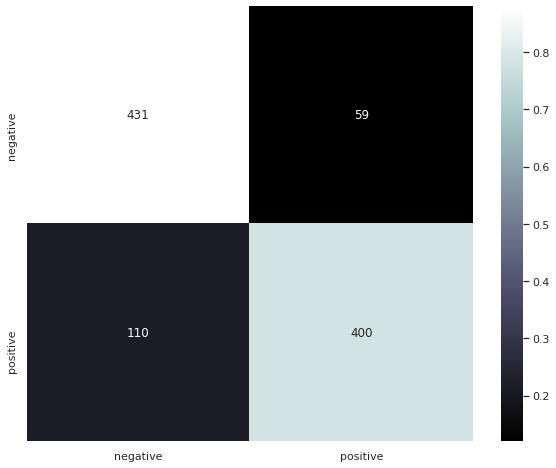

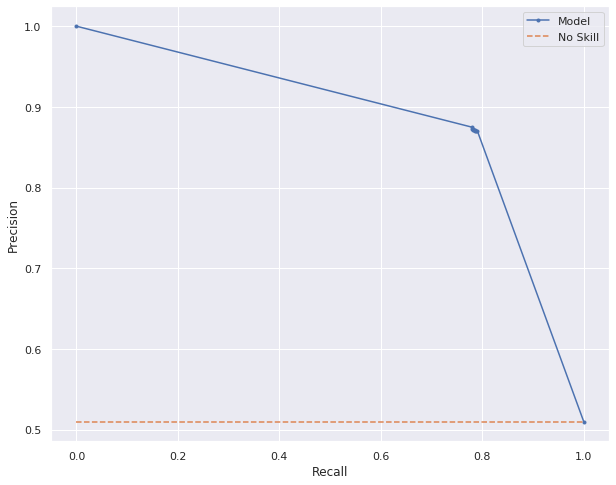




ROC AUC=0.836 



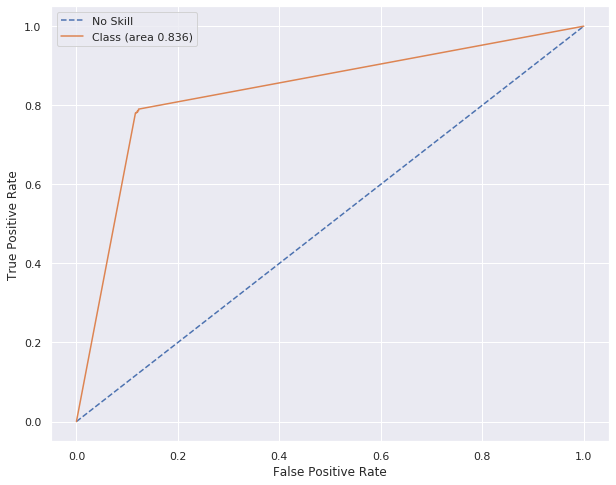



Cohen's kappa: 66.26%




In [73]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for One-Hot encoding\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),  xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Stochastic Gradient Descent with early stopping for TF-IDF

Early Stopping : 10 iterations without change
Execution time : 0.054 s
Score : 84.5 %

Classification Report

              precision    recall  f1-score   support

    negative       0.86      0.81      0.84       490
    positive       0.83      0.88      0.85       510

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000


Confusion Matrix





Model: f1-score=0.853 AUC=0.911




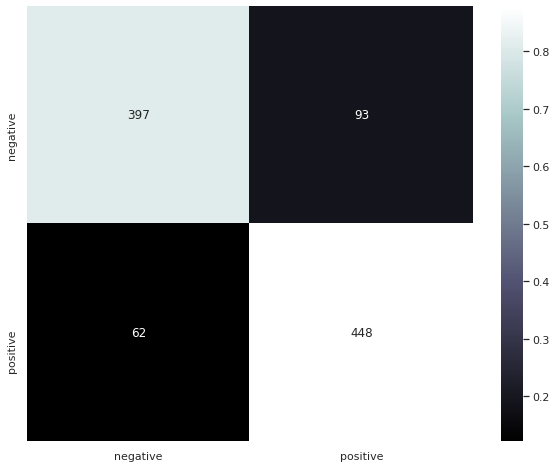

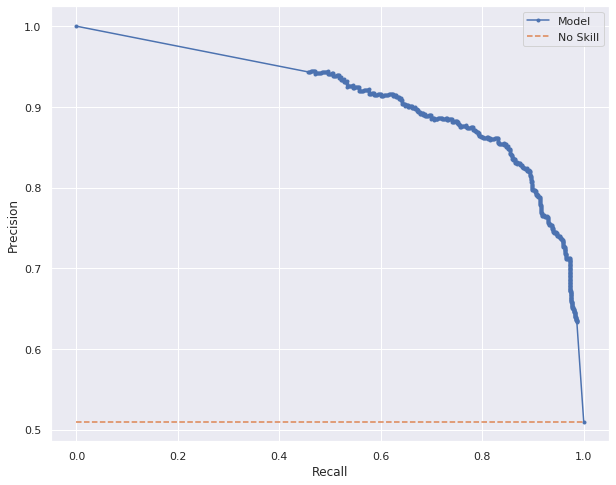




ROC AUC=0.911 



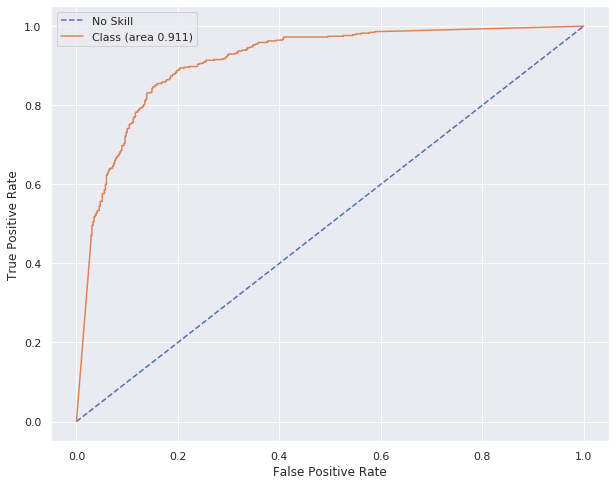



Cohen's kappa: 68.95%




In [74]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for TF-IDF\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Stochastic Gradient Descent with early stopping for TF-IDF N-gram

Early Stopping : 10 iterations without change
Execution time : 0.036 s
Score : 67.2 %

Classification Report

              precision    recall  f1-score   support

    negative       0.68      0.62      0.65       490
    positive       0.67      0.72      0.69       510

    accuracy                           0.67      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.67      0.67      0.67      1000


Confusion Matrix





Model: f1-score=0.691 AUC=0.742




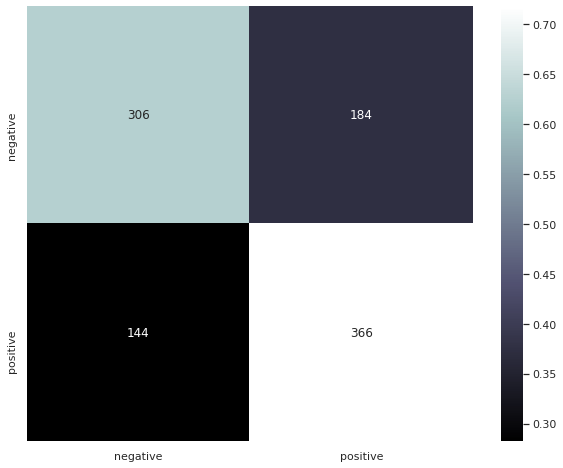

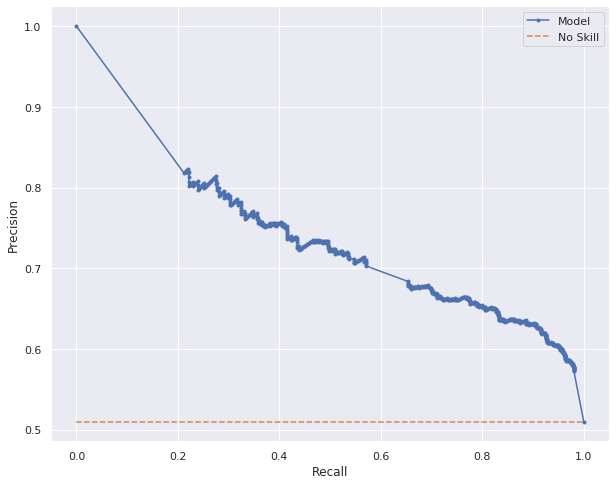




ROC AUC=0.748 



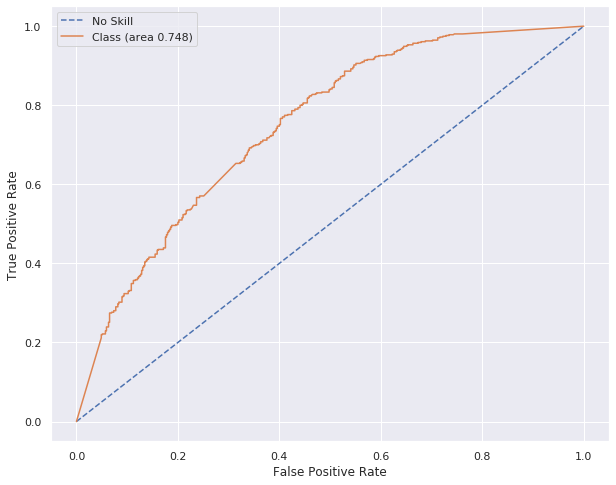



Cohen's kappa: 34.27%




In [75]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for TF-IDF N-gram\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)


Stochastic Gradient Descent with early stopping for TF-IDF char n-gram

Early Stopping : 10 iterations without change
Execution time : 0.330 s
Score : 81.1 %

Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.77      0.80       490
    positive       0.79      0.85      0.82       510

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000


Confusion Matrix





Model: f1-score=0.821 AUC=0.895




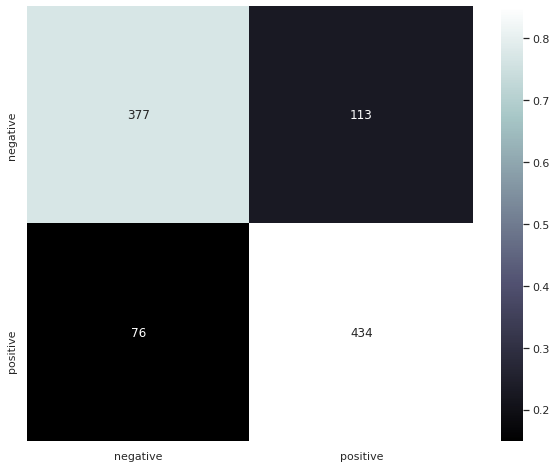

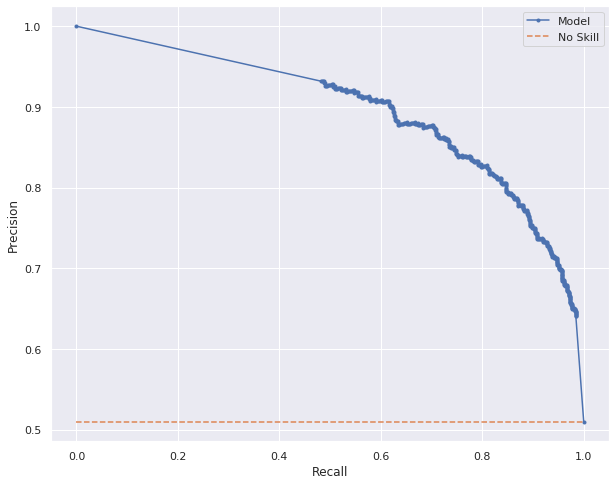




ROC AUC=0.892 



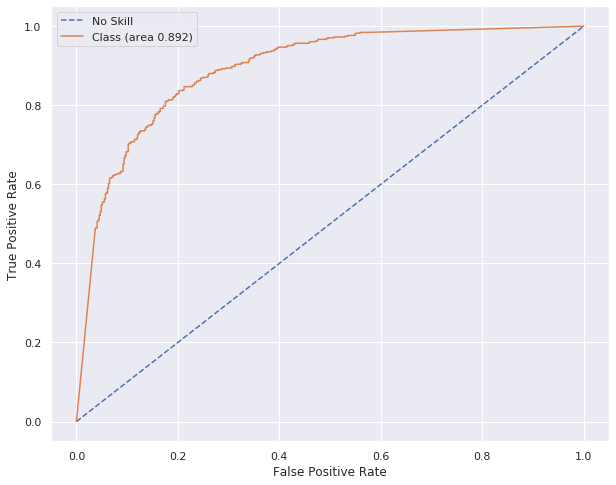



Cohen's kappa: 62.13%




In [76]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for TF-IDF char n-gram\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)


Stochastic Gradient Descent with early stopping for pad sentences

Early Stopping : 10 iterations without change
Execution time : 0.115 s
Score : 51.8 %

Classification Report

              precision    recall  f1-score   support

    negative       0.51      0.28      0.36       490
    positive       0.52      0.75      0.61       510

    accuracy                           0.52      1000
   macro avg       0.52      0.51      0.49      1000
weighted avg       0.52      0.52      0.49      1000


Confusion Matrix





Model: f1-score=0.612 AUC=0.697




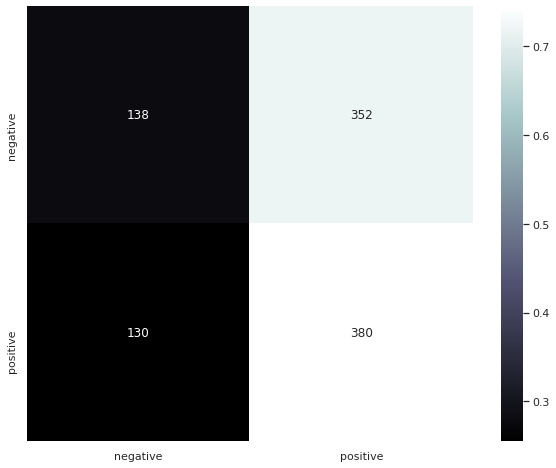

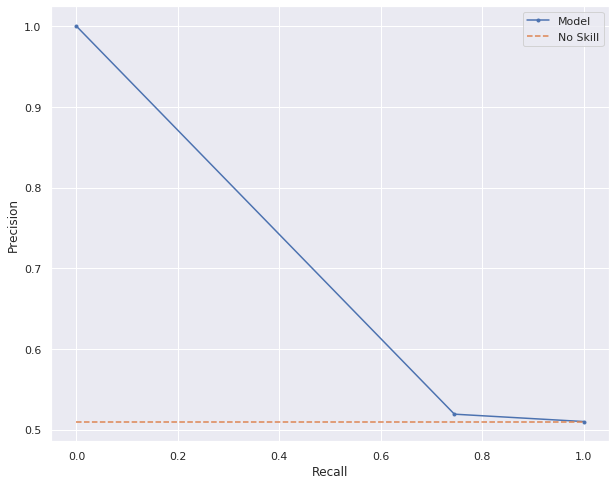




ROC AUC=0.513 



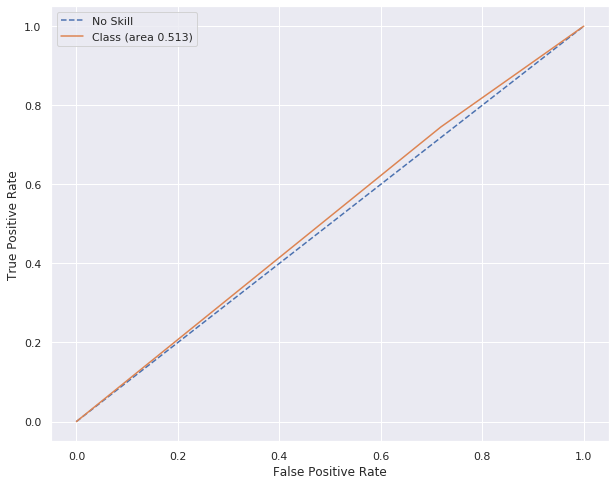



Cohen's kappa: 2.7%




In [77]:
if sgd:
    print("\nStochastic Gradient Descent with early stopping for pad sentences\n")
    print("Early Stopping : 10 iterations without change")
    metrics_ML(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ),train_seq_x, train_y, valid_seq_x, valid_y, gb=True)

---

<center><h2>Gradient Boosting</h2></center>

---


Gradient Boosting with early stopping for Count Vectors

Early Stopping : 5 iterations without change
Execution time : 13.697 s
Score : 80.5 %

Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.74      0.79       490
    positive       0.78      0.86      0.82       510

    accuracy                           0.81      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.81      0.80      1000


Confusion Matrix





Model: f1-score=0.819 AUC=0.881




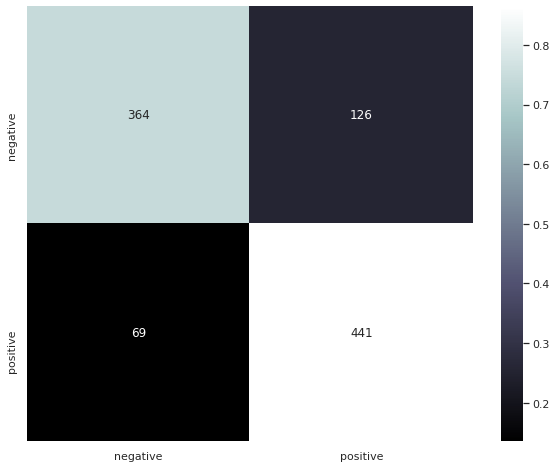

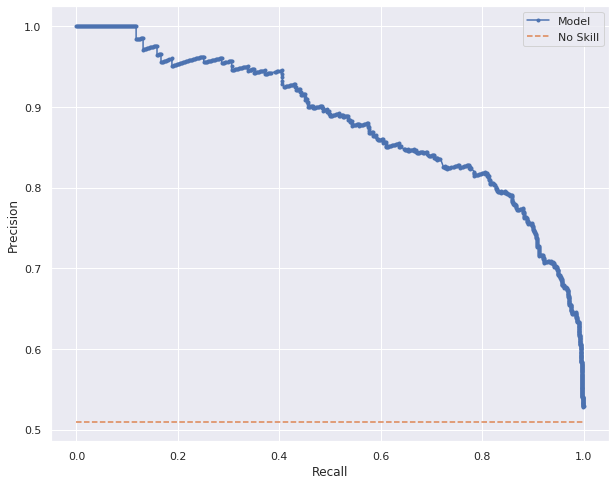




ROC AUC=0.884 



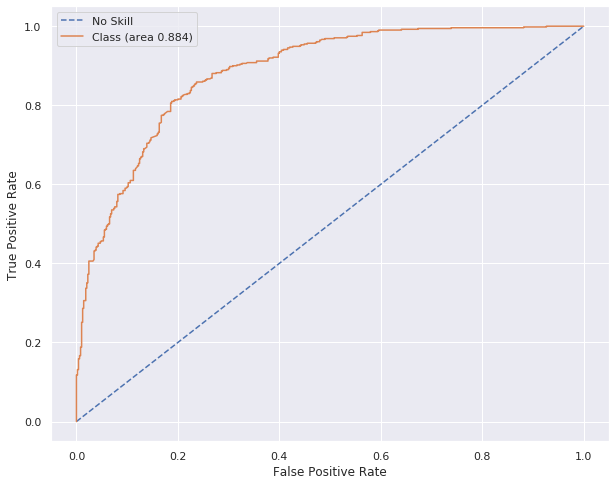



Cohen's kappa: 60.9%




In [79]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for Count Vectors\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_count, train_y_sw, xvalid_count, valid_y_sw, gb=True)


Gradient Boosting with early stopping for TF-IDF

Early Stopping : 5 iterations without change
Execution time : 6.183 s
Score : 79.3 %

Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.71      0.77       490
    positive       0.76      0.87      0.81       510

    accuracy                           0.79      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.79      0.79      1000


Confusion Matrix





Model: f1-score=0.811 AUC=0.877




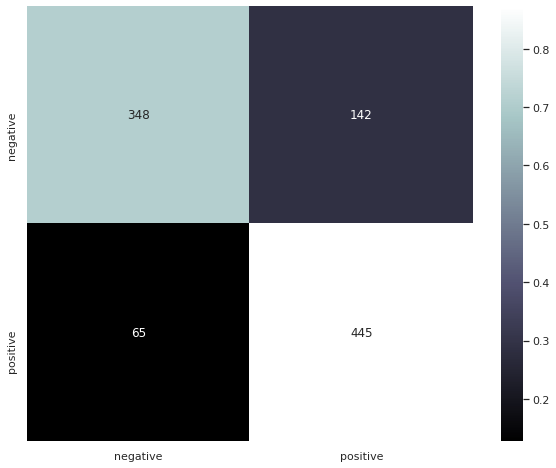

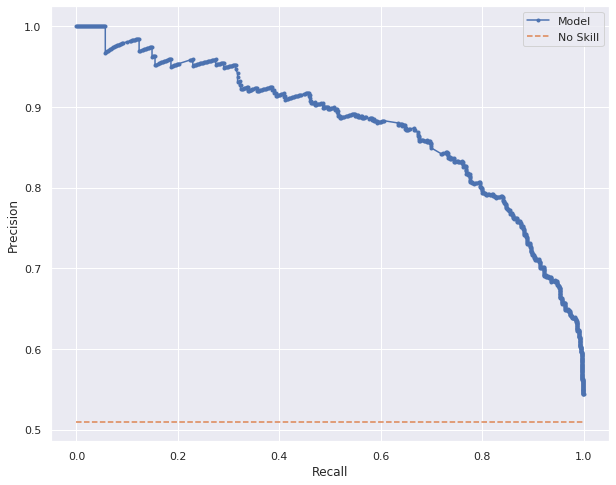




ROC AUC=0.880 



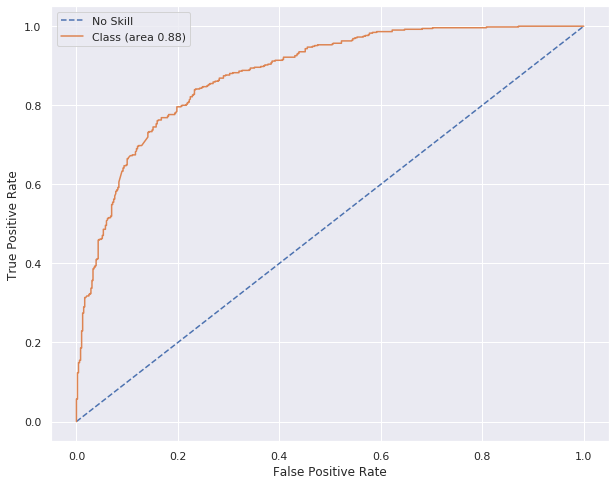



Cohen's kappa: 58.46%




In [80]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0), xtrain_tfidf, train_y, xvalid_tfidf, valid_y, gb=True)


Gradient Boosting with early stopping for TF_IDF ngram

Early Stopping : 5 iterations without change
Execution time : 0.356 s
Score : 62.1 %

Classification Report

              precision    recall  f1-score   support

    negative       0.72      0.37      0.49       490
    positive       0.59      0.86      0.70       510

    accuracy                           0.62      1000
   macro avg       0.65      0.62      0.59      1000
weighted avg       0.65      0.62      0.60      1000


Confusion Matrix





Model: f1-score=0.699 AUC=0.740




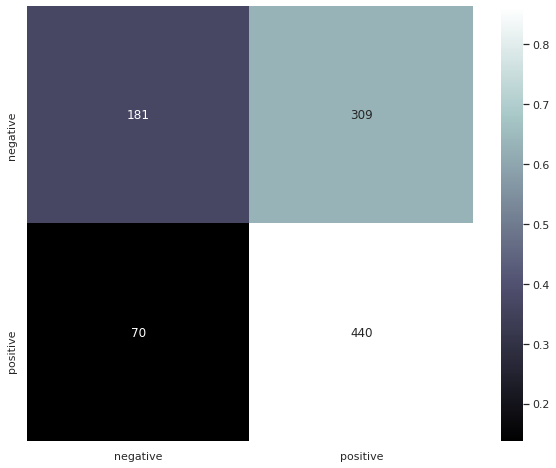

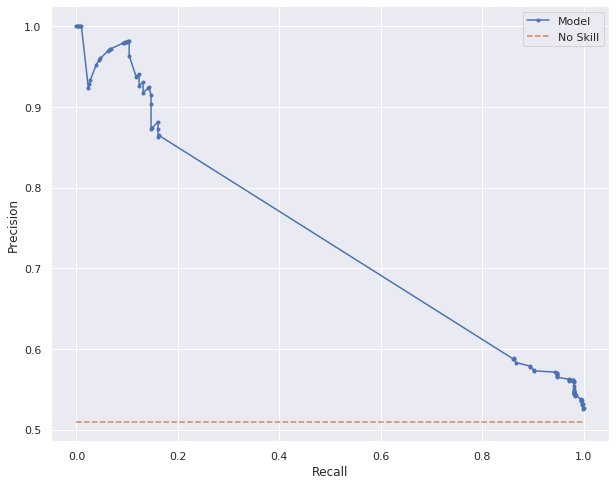




ROC AUC=0.667 



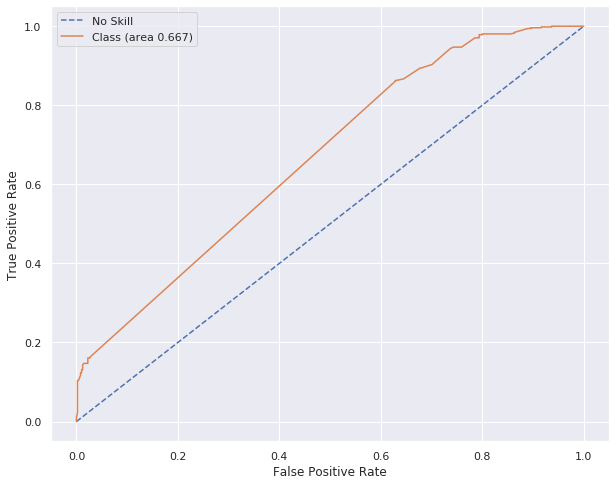



Cohen's kappa: 23.44%




In [81]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF_IDF ngram\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, gb=True)
    


Gradient Boosting with early stopping for TF-IDF ngram chars

Early Stopping : 5 iterations without change
Execution time : 63.377 s
Score : 79.3 %

Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.76      0.78       490
    positive       0.78      0.83      0.80       510

    accuracy                           0.79      1000
   macro avg       0.79      0.79      0.79      1000
weighted avg       0.79      0.79      0.79      1000


Confusion Matrix





Model: f1-score=0.803 AUC=0.880




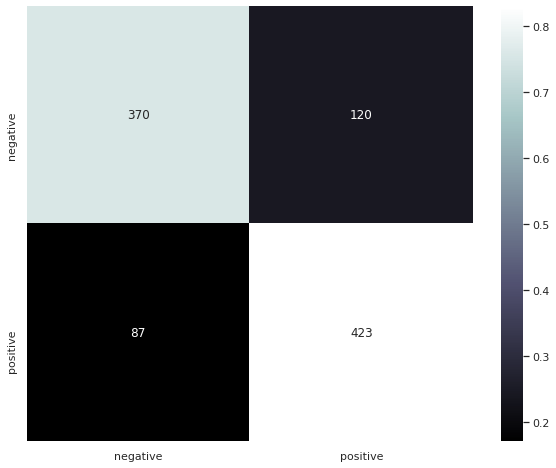

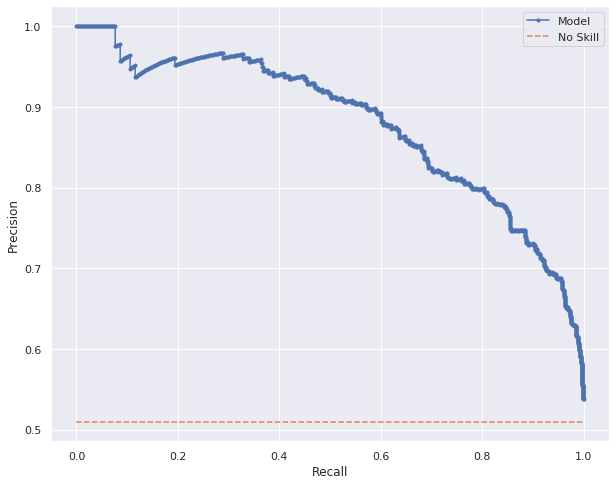




ROC AUC=0.880 



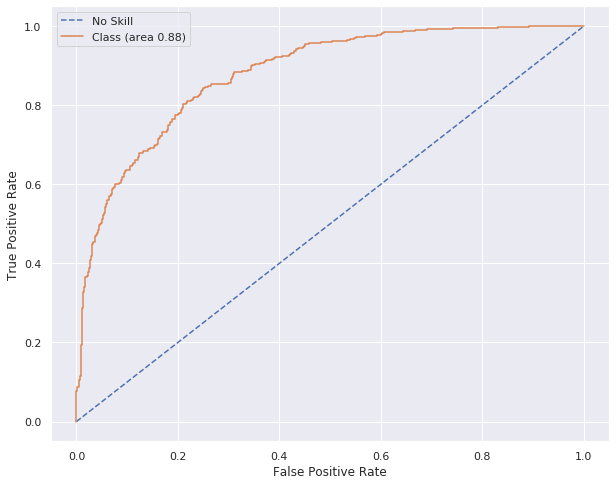



Cohen's kappa: 58.53%




In [82]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for TF-IDF ngram chars\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, gb=True)


Gradient Boosting with early stopping for Word Embeddings

Early Stopping : 5 iterations without change
Execution time : 1.678 s
Score : 51.2 %

Classification Report

              precision    recall  f1-score   support

    negative       0.50      0.46      0.48       490
    positive       0.52      0.56      0.54       510

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000


Confusion Matrix





Model: f1-score=0.539 AUC=0.533




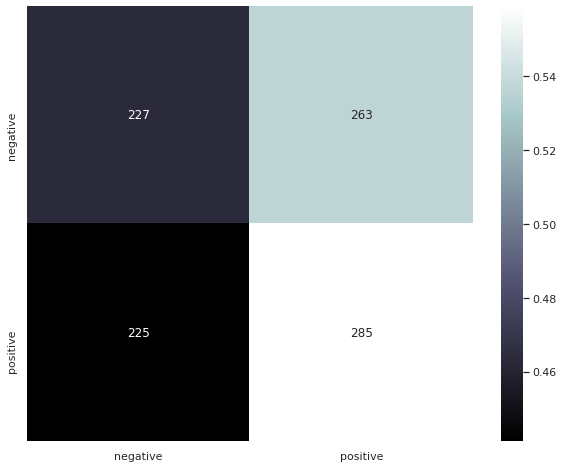

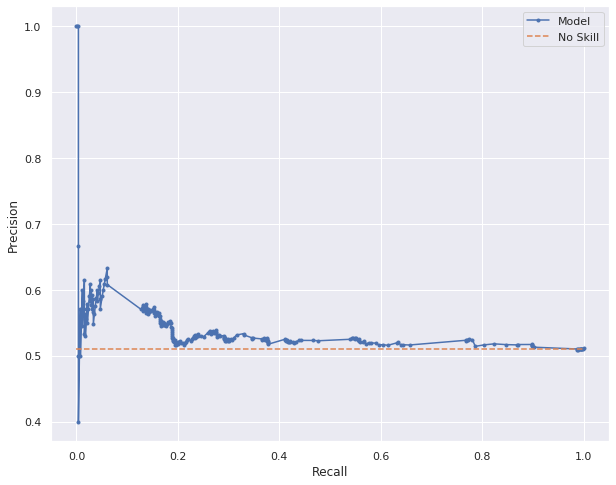




ROC AUC=0.520 



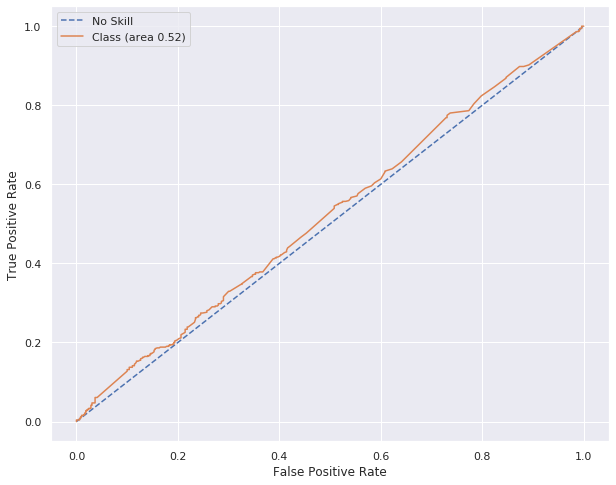



Cohen's kappa: 2.21%




In [83]:
if gradient_boosting:
    print("\nGradient Boosting with early stopping for Word Embeddings\n")
    print("Early Stopping : 5 iterations without change")
    metrics_ML(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=5, tol=0.01,
                                               random_state=0, verbose=0),train_seq_x, train_y, valid_seq_x, valid_y, gb=True)

---

<h2>XGBoost Classifier</h2>

---

All the XGBoost have early stopping implemented with 10 rounds

In [84]:
def xgb_model(X_train, y_train, X_test, y_test, labels=labels):
    model = XGBClassifier(n_estimators=1000, subsample=0.8)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if len(labels)>2:
        model.fit(X_train, y_train, eval_metric=["merror", "mlogloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    else:
        model.fit(X_train, y_train, eval_metric=["error", "logloss"],  eval_set=eval_set,early_stopping_rounds=10, verbose=False) #
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(valid_y, predictions)
    print("\nAccuracy: %.2f%%" % (accuracy * 100.0))
    return model, y_pred, accuracy

def rmsle_eval(y, y0):
    
    y0=y0.get_label()    
    assert len(y) == len(y0)
    return 'error',np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))



<i><h3>XGBoost for Count Vectors</h3></i>


XGBoost for Count Vectors


Accuracy: 83.20%

Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.81      0.83       490
    positive       0.82      0.85      0.84       510

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000


Confusion Matrix



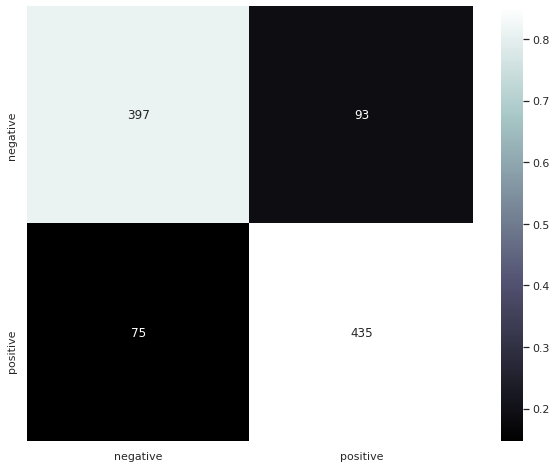

In [85]:
if xgboost_classifier:
    print("\nXGBoost for Count Vectors\n")
    xgbs, pred, accuracy = xgb_model(xtrain_count, train_y_sw, xvalid_count, valid_y_sw, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y_sw, pred, target_names=labels))
    cm = confusion_matrix(valid_y_sw, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)

/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



The precision of the model is 82.39%


Model: f1-score=0.838 AUC=0.918




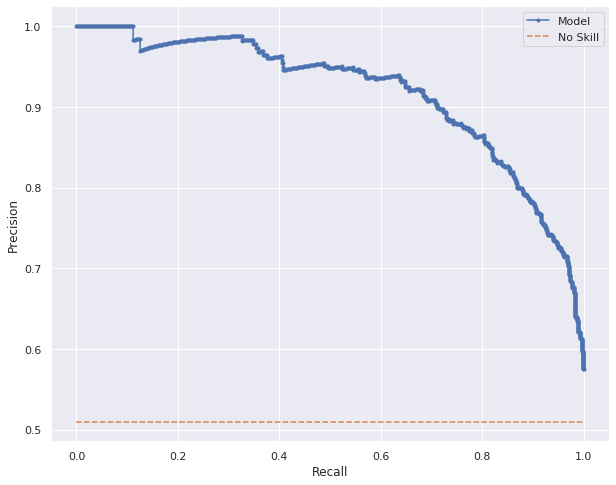




ROC AUC=0.916 



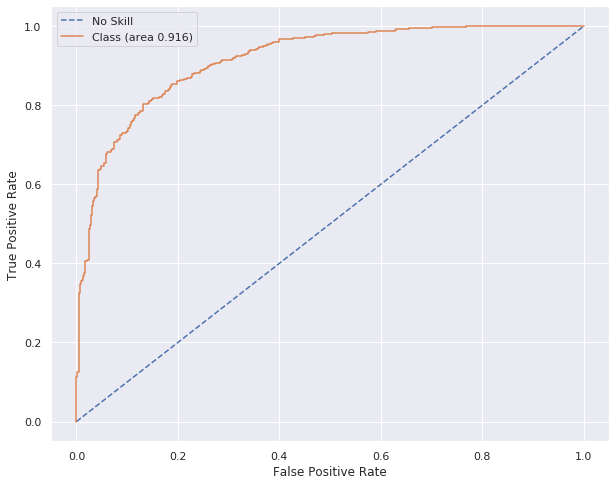


Evaluation Curves


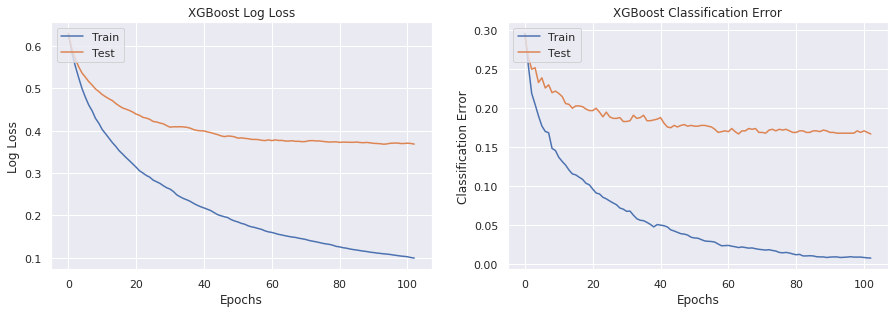



Cohen's kappa: 66.36%




In [86]:
if xgboost_classifier:
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y_sw, pred, labels),2)}%")
    Metric.precision_recall_curve(xgbs,  xvalid_count,  valid_y_sw, labels, gb=True)
    print("\n")
    Metric.roc_auc_curve(xgbs, xvalid_count, valid_y_sw,  labels, gb=True)
    print("\nEvaluation Curves")
    Metric.plot_eval_xgb(xgbs,  labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_count)),2)}%\n\n")

<i><h3>XGBoost for TF-IDF </h3></i>


XGBoost for TF_IDF


Accuracy: 81.80%

Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.78      0.81       490
    positive       0.80      0.85      0.83       510

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


Confusion Matrix



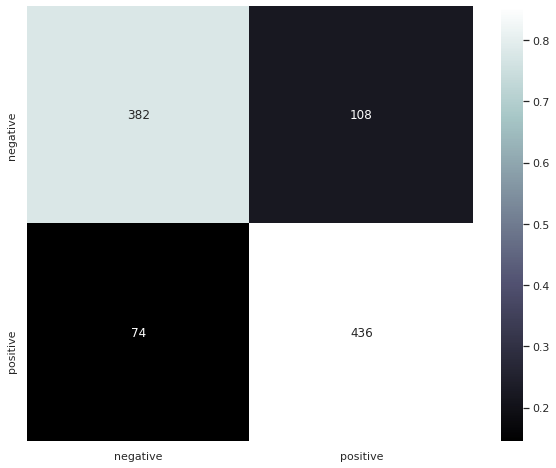

In [87]:
if xgboost_classifier:
    print("\nXGBoost for TF_IDF\n")
    xgbs, pred, accuracy = xgb_model(xtrain_tfidf, train_y, xvalid_tfidf, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)

/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



The precision of the model is 80.15%


Model: f1-score=0.827 AUC=0.908




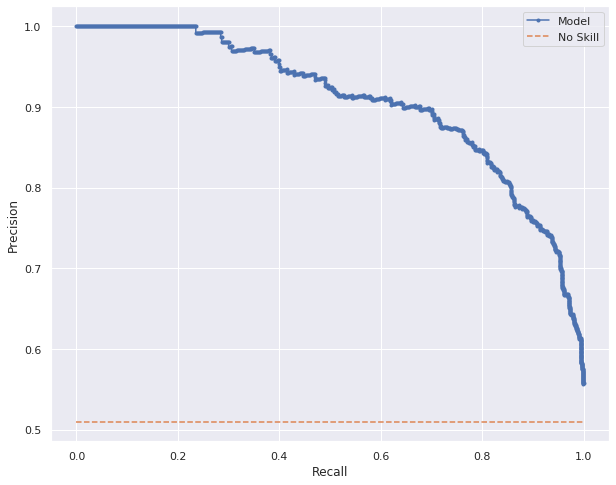




ROC AUC=0.904 



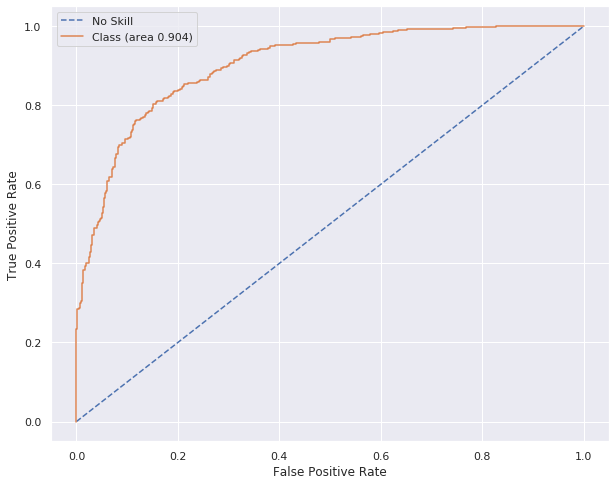


Evaluation Curves


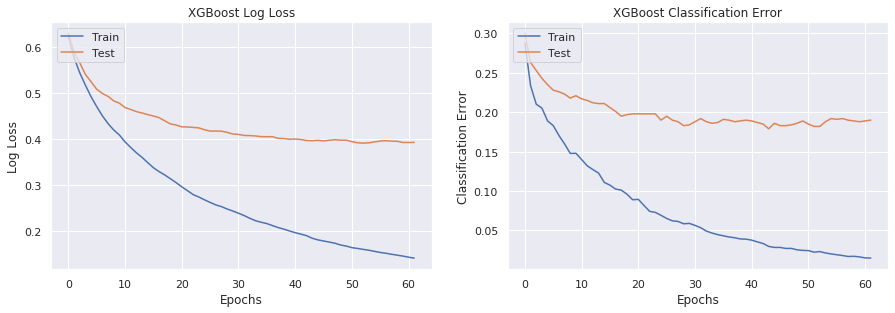



Cohen's kappa: 63.54%




In [88]:
if xgboost_classifier:
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y_sw, pred, labels),2)}%")
    Metric.precision_recall_curve(xgbs,  xvalid_tfidf, valid_y,  labels,gb=True)
    print("\n")
    Metric.roc_auc_curve(xgbs,  xvalid_tfidf, valid_y, labels, gb=True)
    print("\nEvaluation Curves")
    Metric.plot_eval_xgb(xgbs, labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf)),2)}%\n\n")

<i><h3>XGBoost for TF-IDF ngram </h3></i>


XGBoost for TF_IDF ngram


Accuracy: 69.20%

Classification Report

              precision    recall  f1-score   support

    negative       0.71      0.62      0.67       490
    positive       0.68      0.76      0.71       510

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000


Confusion Matrix



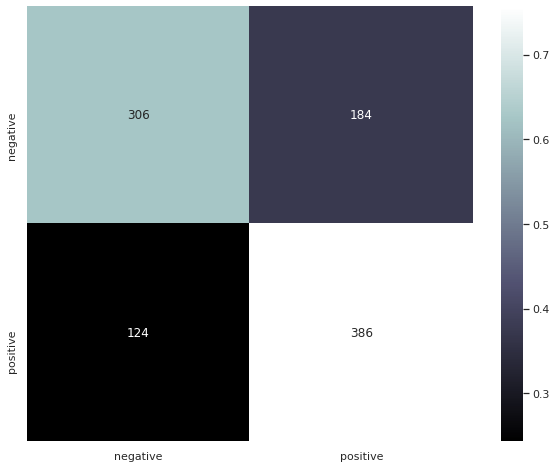

In [89]:
if xgboost_classifier:
    print("\nXGBoost for TF_IDF ngram\n")
    xgbs, pred, accuracy = xgb_model(xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)

/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



The precision of the model is 67.72%


Model: f1-score=0.715 AUC=0.762




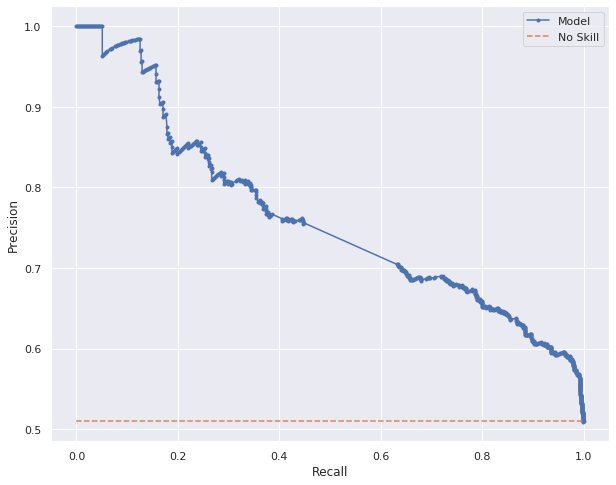




ROC AUC=0.760 



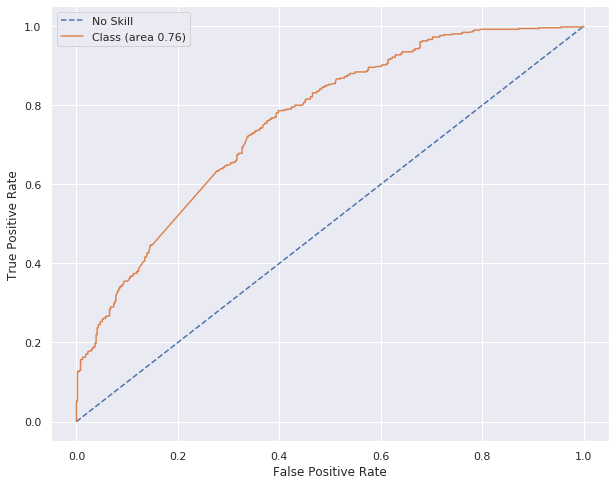


Evaluation Curves


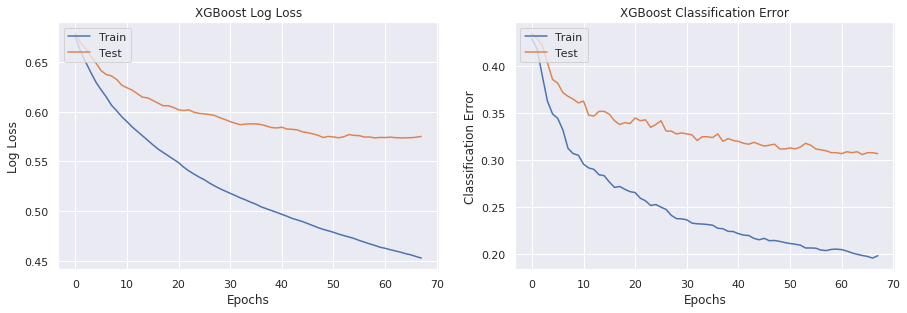



Cohen's kappa: 38.23%




In [90]:
if xgboost_classifier:
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, pred, labels),2)}%")
    Metric.precision_recall_curve(xgbs,  xvalid_tfidf_ngram, valid_y, labels, gb=True)
    print("\n")
    Metric.roc_auc_curve(xgbs,  xvalid_tfidf_ngram, valid_y, labels, gb=True)
    print("\nEvaluation Curves")
    Metric.plot_eval_xgb(xgbs,  labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf_ngram)),2)}%\n\n")

<i><h3>XGBoost for TF-IDF ngram chars</h3></i>


XGBoost for TF-IDF ngram chars


Accuracy: 78.00%

Classification Report

              precision    recall  f1-score   support

    negative       0.77      0.78      0.78       490
    positive       0.79      0.78      0.78       510

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000


Confusion Matrix



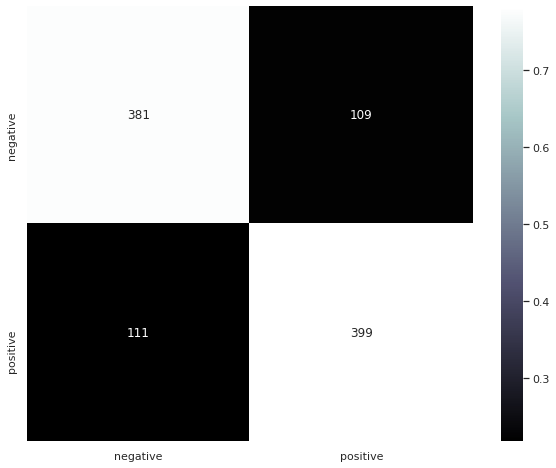

In [91]:
if xgboost_classifier:
    print("\nXGBoost for TF-IDF ngram chars\n")
    xgbs, pred, accuracy = xgb_model(xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred,target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)

/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



The precision of the model is 78.54%


Model: f1-score=0.784 AUC=0.868




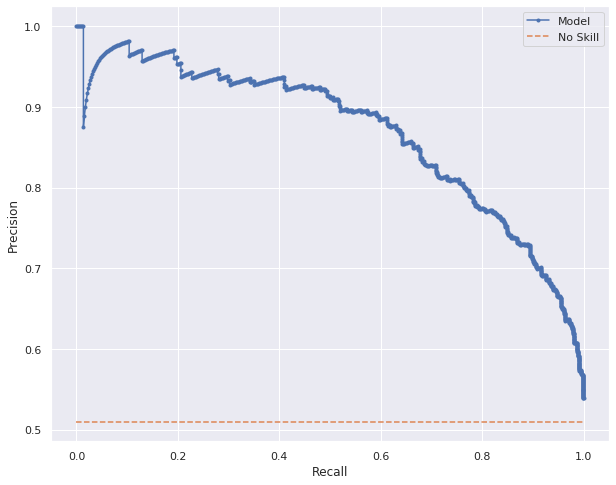




ROC AUC=0.870 



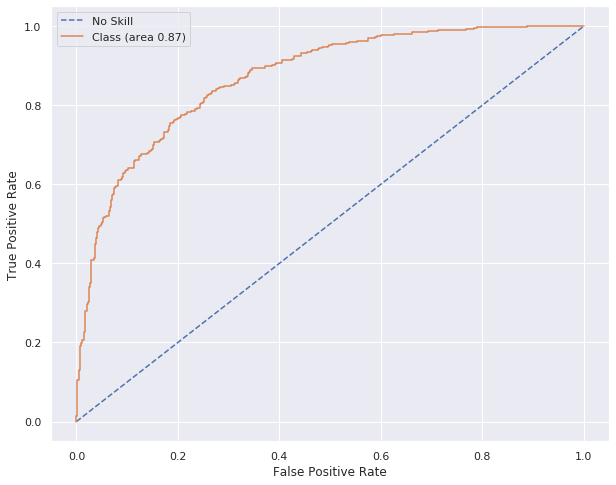


Evaluation Curves


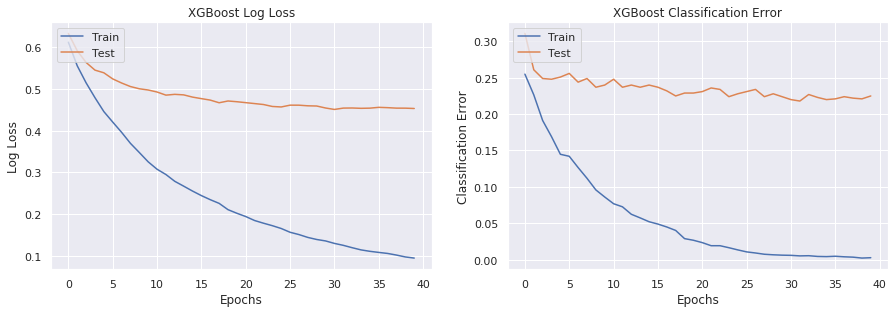



Cohen's kappa: 55.99%




In [92]:
if xgboost_classifier:
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, pred, labels),2)}%")
    Metric.precision_recall_curve(xgbs,  xvalid_tfidf_ngram_chars, valid_y, labels, gb=True)
    print("\n")
    Metric.roc_auc_curve(xgbs,  xvalid_tfidf_ngram_chars, valid_y, labels, gb=True)
    print("\nEvaluation Curves")
    Metric.plot_eval_xgb(xgbs,  labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(xvalid_tfidf_ngram_chars)),2)}%\n\n")

<i><h3>XGBoost for Word Embeddings</h3></i>


XGBoost for Word Embeddings


Accuracy: 50.90%

Classification Report

              precision    recall  f1-score   support

    negative       0.50      0.57      0.53       490
    positive       0.52      0.45      0.49       510

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000


Confusion Matrix



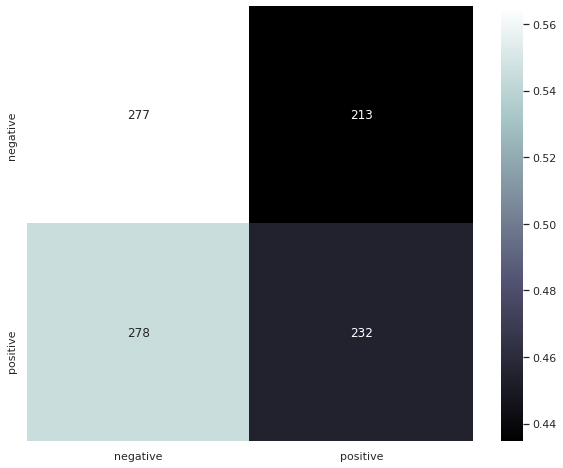

In [93]:
if xgboost_classifier:
    print("\nXGBoost for Word Embeddings\n")
    xgbs, pred, accuracy = xgb_model(train_seq_x, train_y, valid_seq_x, valid_y, labels=labels)
    print("\nClassification Report\n")
    print(classification_report(valid_y, pred, target_names=labels))
    cm = confusion_matrix(valid_y, pred)
    print("\nConfusion Matrix\n")
    Metric.plot_confusion_matrix(cm, labels)

/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



The precision of the model is 52.13%


Model: f1-score=0.486 AUC=0.542




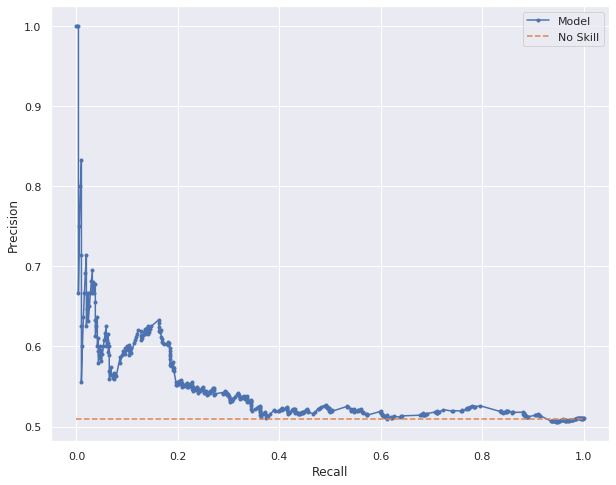




ROC AUC=0.522 



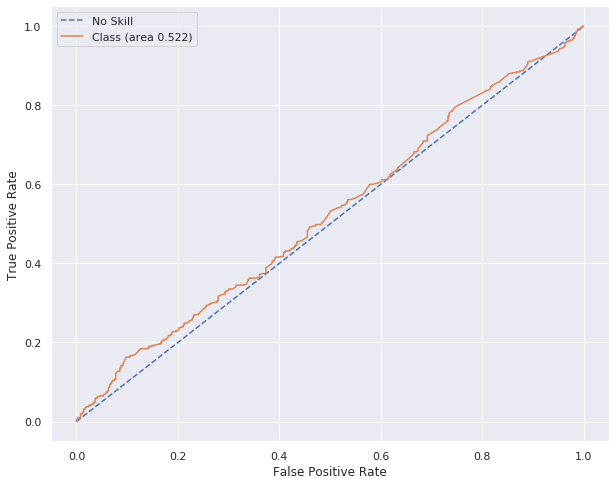


Evaluation Curves


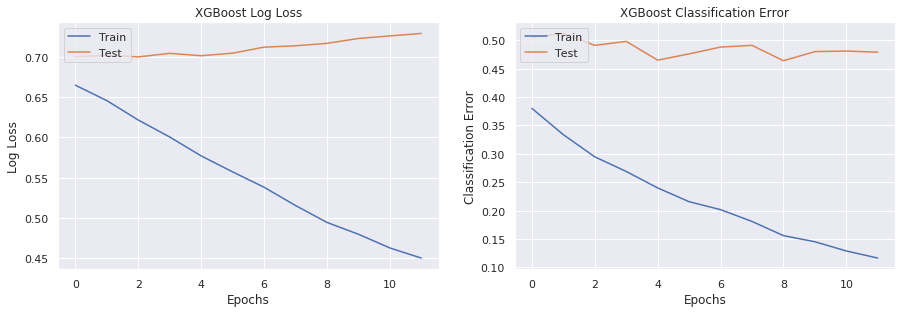



Cohen's kappa: 2.02%




In [94]:
if xgboost_classifier:
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, pred, labels),2)}%")
    Metric.precision_recall_curve(xgbs,  valid_seq_x, valid_y, labels, gb=True)
    print("\n")
    Metric.roc_auc_curve(xgbs,  valid_seq_x, valid_y, labels, gb=True)
    print("\nEvaluation Curves")
    Metric.plot_eval_xgb(xgbs,  labels)
    print(f"\n\nCohen's kappa: {round(100*cohen_kappa_score(valid_y,  xgbs.predict(valid_seq_x)),2)}%\n\n")

---

<center><h1>Deep Learning</h1></center>

---

<h3>Cohen’s kappa</h3>

The function [cohen_kappa_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score) computes [Cohen’s kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) statistic. This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.

The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

Kappa scores can be computed for binary or multiclass problems, but not for multilabel problems (except by manually computing a per-label score) and not for more than two annotators.

<h3>Balanced Accuracy</h3>

Compute the balanced accuracy

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

The best value is 1 and the worst value is 0 when adjusted=False

---

<h3>Early Stopping, Model saving, Class weight configuration</h3>

In [95]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

In [96]:
class_w = {}
for i in zip(range(len(class_weights)), class_weights):
    class_w[i[0]] = i[1]

---

<h2>Shallow Neural Networks</h2>

In [97]:
def shallow_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a shallow neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) shallow neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop,
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [98]:
if shallow_network:
    model_shallow = shallow_neural_networks(word_index, pre_trained=pre_trained)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          692848    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 692,865
Trainable params: 692,865
Non-trainable params: 0
_________________________________________________________________
None


In [99]:
if shallow_network:
    history = model_shallow.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 [==============================] - 2s 651us/sample - loss: 0.7117 - accuracy: 0.4831 - val_loss: 0.7212 - val_accuracy: 0.5175
Epoch 2/1000
3200/3200 [==============================] - 1s 309us/sample - loss: 0.7019 - accuracy: 0.4837 - val_loss: 0.7086 - val_accuracy: 0.5175
Epoch 3/1000
3200/3200 [==============================] - 1s 296us/sample - loss: 0.6943 - accuracy: 0.4837 - val_loss: 0.7011 - val_accuracy: 0.5175
Epoch 4/1000
3200/3200 [==============================] - 1s 305us/sample - loss: 0.6898 - accuracy: 0.4837 - val_loss: 0.6970 - val_accuracy: 0.5175
Epoch 5/1000
3200/3200 [==============================] - 1s 299us/sample - loss: 0.6870 - accuracy: 0.4837 - val_loss: 0.6946 - val_accuracy: 0.5175
Epoch 6/1000
3200/3200 [==============================] - 1s 307us/sample - loss: 0.6846 - accuracy: 0.4837 - val_loss: 0.6926 - val_accuracy: 0.5175
Epoch 7/1000
3200/3200 [=============================

In [100]:
if shallow_network:
    results = model_shallow.evaluate(valid_seq_x, valid_y)
    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model_shallow.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 0s 209us/sample - loss: 0.5758 - accuracy: 0.8610
[0.5758115015029908, 0.861]

The precision of the model is 86.02%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


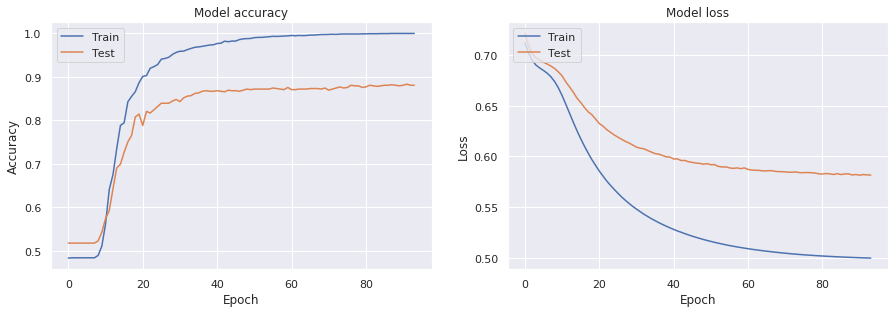

              precision    recall  f1-score   support

    negative       0.86      0.85      0.86       490
    positive       0.86      0.87      0.86       510

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


The balanced accuracy is : 86.08%


The Zero-one Loss is : 13.9%


Explained variance score: 0.444


ROC AUC=0.930 



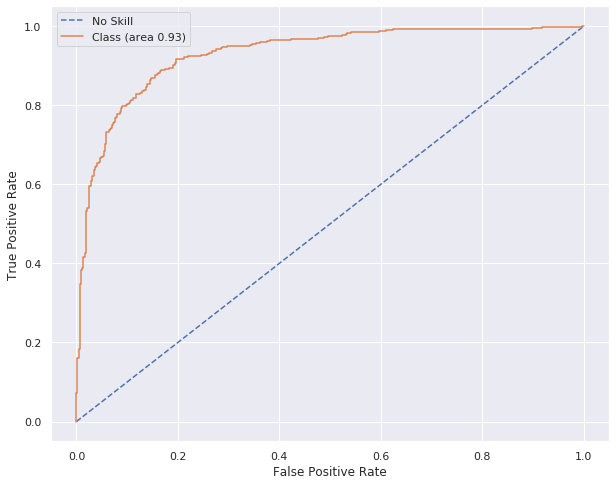



Model: f1-score=0.864 AUC=0.931




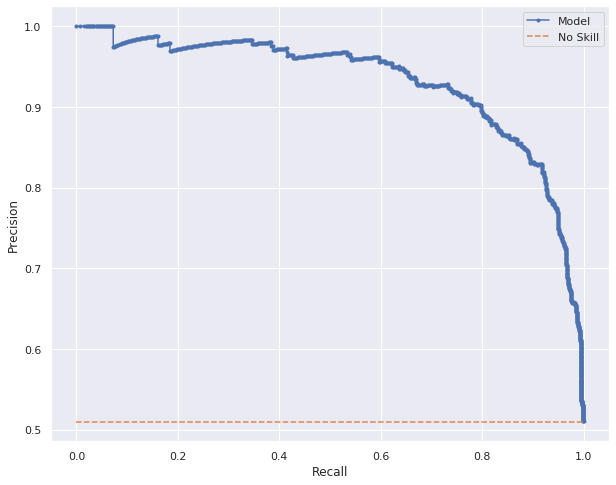


Cohen's kappa: 72.18% 


Confusion Matrix



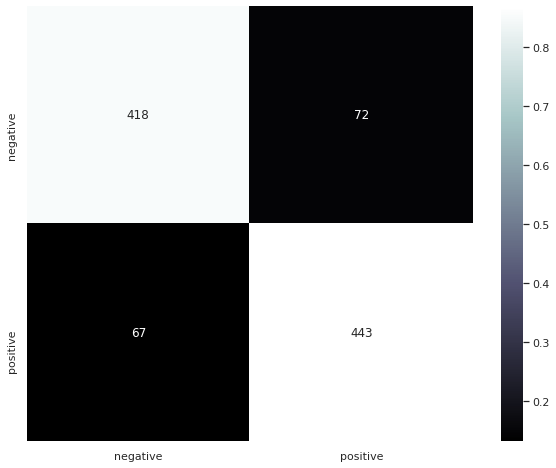

In [101]:
if shallow_network:
    Metric.metrics_deep_learning(model_shallow, history, valid_seq_x, valid_y, labels)

---

<h2>Deep Neural Networks</h2>

---

In [102]:
def deep_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [103]:
if deep_nn:
    model = deep_neural_networks(word_index, pre_trained=pre_trained)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         4330300   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 4,331,933
Trainable params: 4,331,933
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
if deep_nn:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 [==============================] - 8s 3ms/sample - loss: 0.7018 - accuracy: 0.4837 - val_loss: 0.6972 - val_accuracy: 0.5175
Epoch 2/1000
3200/3200 [==============================] - 7s 2ms/sample - loss: 0.6870 - accuracy: 0.4837 - val_loss: 0.6902 - val_accuracy: 0.5175
Epoch 3/1000
3200/3200 [==============================] - 11s 4ms/sample - loss: 0.6693 - accuracy: 0.5206 - val_loss: 0.6673 - val_accuracy: 0.6500
Epoch 4/1000
3200/3200 [==============================] - 9s 3ms/sample - loss: 0.6112 - accuracy: 0.7987 - val_loss: 0.6214 - val_accuracy: 0.8050
Epoch 5/1000
3200/3200 [==============================] - 9s 3ms/sample - loss: 0.5602 - accuracy: 0.9178 - val_loss: 0.6015 - val_accuracy: 0.8450
Epoch 6/1000
3200/3200 [==============================] - 8s 3ms/sample - loss: 0.5342 - accuracy: 0.9559 - val_loss: 0.5911 - val_accuracy: 0.8288
Epoch 7/1000
3200/3200 [==============================] - 8s 2ms

In [105]:
if deep_nn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 0s 237us/sample - loss: 0.5720 - accuracy: 0.8590
[0.5720382137298584, 0.859]

The precision of the model is 85.55%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


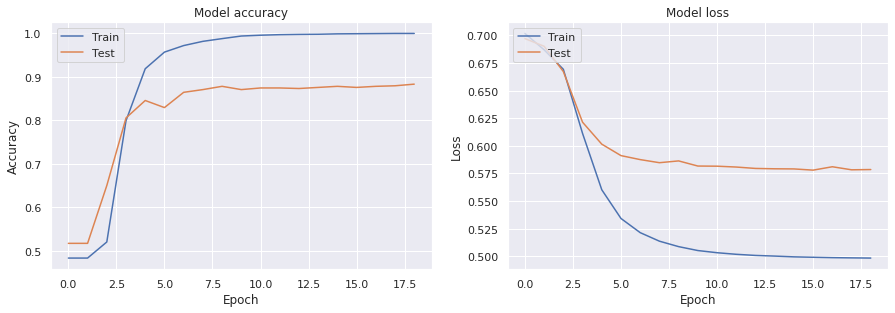

              precision    recall  f1-score   support

    negative       0.86      0.85      0.85       490
    positive       0.86      0.87      0.86       510

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


The balanced accuracy is : 85.88%


The Zero-one Loss is : 14.1%


Explained variance score: 0.436


ROC AUC=0.930 



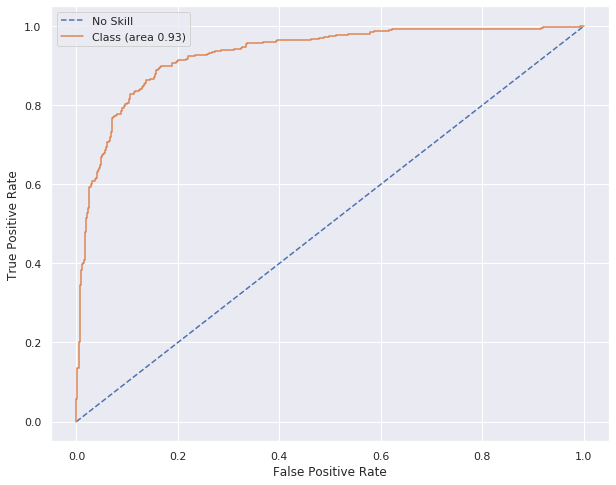



Model: f1-score=0.863 AUC=0.930




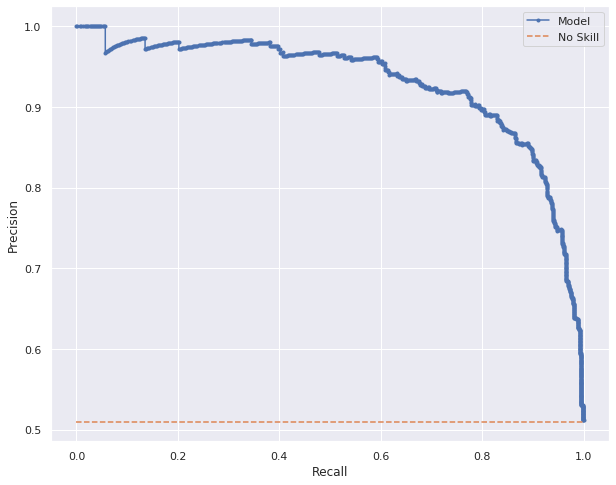


Cohen's kappa: 71.78% 


Confusion Matrix



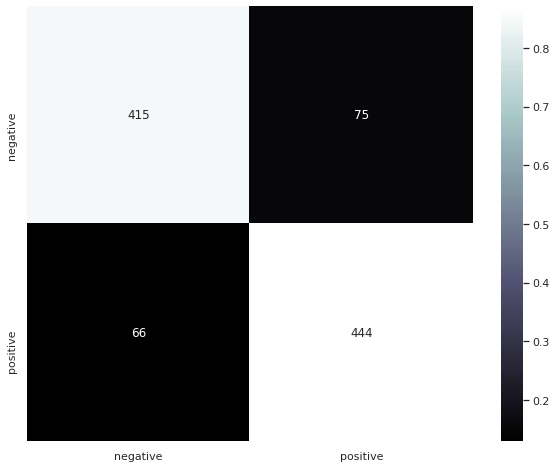

In [106]:
if deep_nn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Deep Neural Networks variation 1</h2>

In [107]:
def deep_neural_networks_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [108]:
if deep_nn:
    model = deep_neural_networks_var1(word_index, pre_trained=pre_trained)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         4330300   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1616      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 4,332,205
Trainable params: 4,332,205
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
if deep_nn:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.7033 - accuracy: 0.4831 - val_loss: 0.6959 - val_accuracy: 0.5175
Epoch 2/1000
3200/3200 [==============================] - 4s 1ms/sample - loss: 0.6858 - accuracy: 0.4837 - val_loss: 0.6867 - val_accuracy: 0.5175
Epoch 3/1000
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.6500 - accuracy: 0.5891 - val_loss: 0.6396 - val_accuracy: 0.6938
Epoch 4/1000
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.5737 - accuracy: 0.8909 - val_loss: 0.5957 - val_accuracy: 0.8213
Epoch 5/1000
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.5262 - accuracy: 0.9575 - val_loss: 0.5836 - val_accuracy: 0.8550
Epoch 6/1000
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.5111 - accuracy: 0.9803 - val_loss: 0.5799 - val_accuracy: 0.8650
Epoch 7/1000
3200/3200 [==============================] - 6s 2ms/

In [110]:
if deep_nn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 0s 320us/sample - loss: 0.5730 - accuracy: 0.8670
[0.573045608997345, 0.867]

The precision of the model is 84.84%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


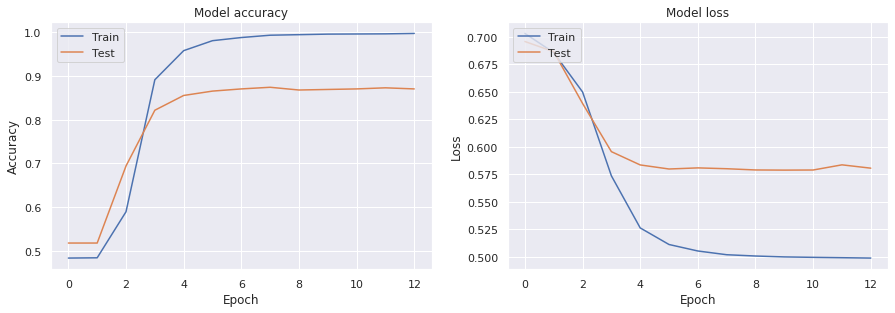

              precision    recall  f1-score   support

    negative       0.89      0.83      0.86       490
    positive       0.85      0.90      0.87       510

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000


The balanced accuracy is : 86.63%


The Zero-one Loss is : 13.3%


Explained variance score: 0.472


ROC AUC=0.927 



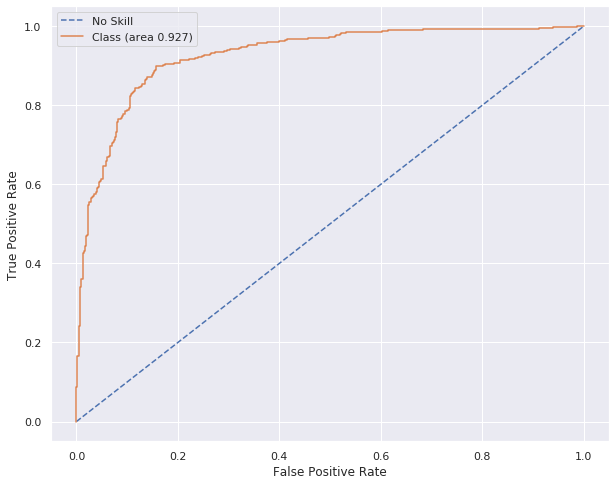



Model: f1-score=0.873 AUC=0.928




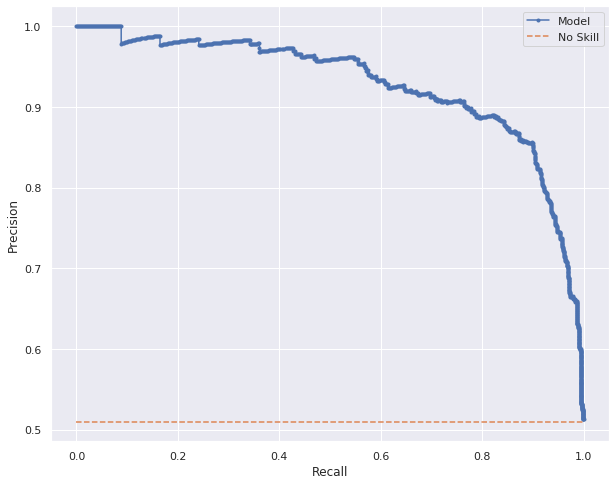


Cohen's kappa: 73.36% 


Confusion Matrix



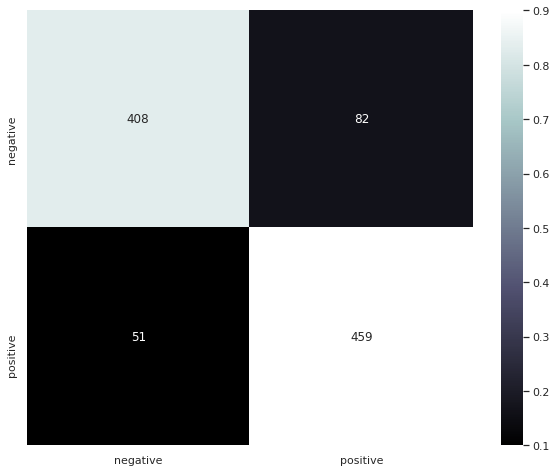

In [111]:
if deep_nn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

<h2>Deep Neural Networks variation 2</h2>

In [112]:
def deep_neural_networks_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model


In [113]:
if deep_nn:
    model = deep_neural_networks_var2(word_index, pre_trained=pre_trained)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         4330300   
_________________________________________________________________
global_average_pooling1d_3 ( (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 4,334,077
Trainable params: 4,334,077
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
if deep_nn:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.7016 - accuracy: 0.4837 - val_loss: 0.6945 - val_accuracy: 0.5175
Epoch 2/1000
3200/3200 [==============================] - 7s 2ms/sample - loss: 0.6836 - accuracy: 0.4837 - val_loss: 0.6862 - val_accuracy: 0.5175
Epoch 3/1000
3200/3200 [==============================] - 7s 2ms/sample - loss: 0.6346 - accuracy: 0.6800 - val_loss: 0.6291 - val_accuracy: 0.7900
Epoch 4/1000
3200/3200 [==============================] - 8s 3ms/sample - loss: 0.5537 - accuracy: 0.9216 - val_loss: 0.5883 - val_accuracy: 0.8450
Epoch 5/1000
3200/3200 [==============================] - 9s 3ms/sample - loss: 0.5185 - accuracy: 0.9625 - val_loss: 0.5822 - val_accuracy: 0.8712
Epoch 6/1000
3200/3200 [==============================] - 8s 2ms/sample - loss: 0.5080 - accuracy: 0.9825 - val_loss: 0.5815 - val_accuracy: 0.8775
Epoch 7/1000
3200/3200 [==============================] - 8s 2ms/

In [115]:
if deep_nn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 1s 574us/sample - loss: 0.5722 - accuracy: 0.8610
[0.572227557182312, 0.861]

The precision of the model is 85.07%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


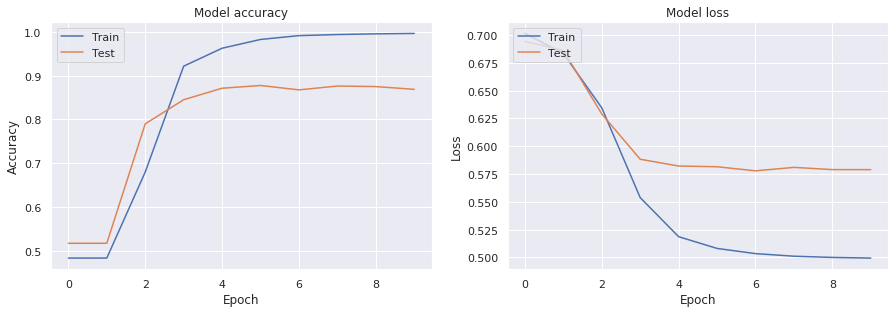

              precision    recall  f1-score   support

    negative       0.87      0.84      0.86       490
    positive       0.85      0.88      0.87       510

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000


The balanced accuracy is : 86.06%


The Zero-one Loss is : 13.9%


Explained variance score: 0.445


ROC AUC=0.927 



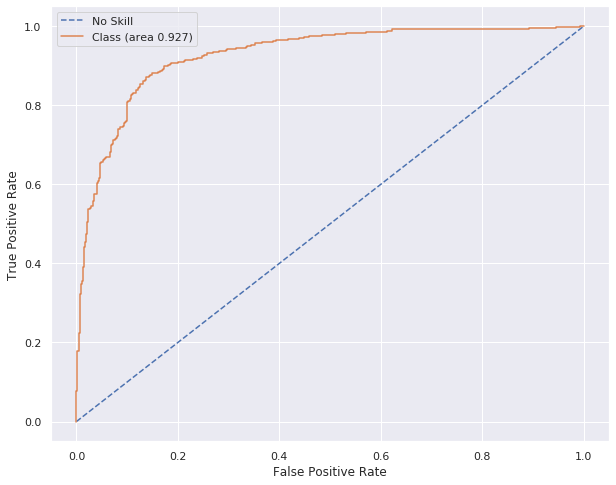



Model: f1-score=0.866 AUC=0.927




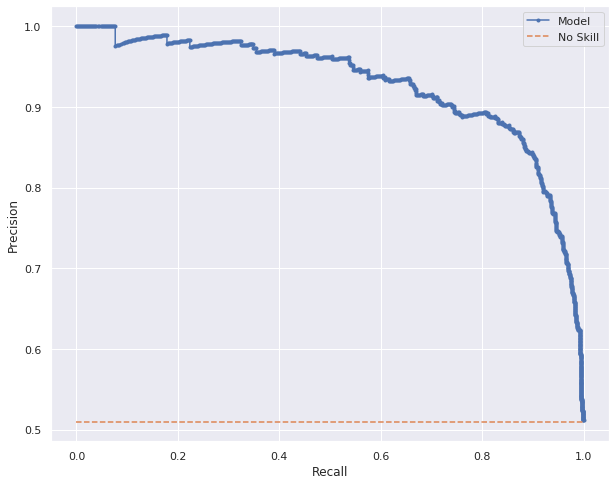


Cohen's kappa: 72.17% 


Confusion Matrix



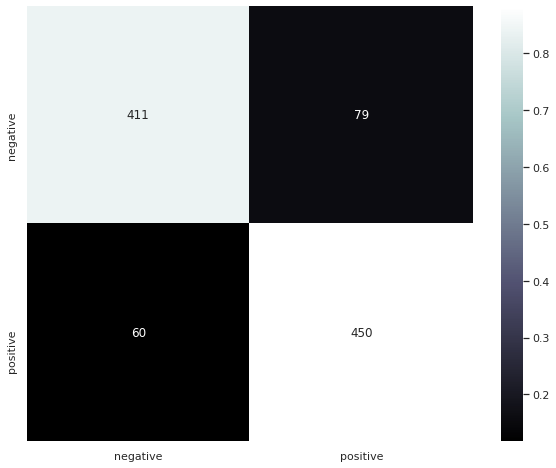

In [116]:
if deep_nn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurent Neural Network - RNN</h2>

---

In [117]:
def create_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a recurrent neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) recurrent neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32, return_sequences=True),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [118]:
if rnn:
    model = create_rnn_model(word_index, pre_trained=pre_trained )


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         4330300   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 32)          4256      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 4,340,829
Trainable params: 4,340,829
Non-trainable params: 0
____________________________________________

In [119]:
if rnn:
    history = model.fit(train_seq_x, train_y,
                    epochs=1000, callbacks=[es],
                    validation_split=0.2, verbose=True)#, class_weight=class_w)

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 [==============================] - 46s 14ms/sample - loss: 0.6945 - accuracy: 0.4844 - val_loss: 0.6944 - val_accuracy: 0.5175
Epoch 2/1000
3200/3200 [==============================] - 40s 13ms/sample - loss: 0.6545 - accuracy: 0.6247 - val_loss: 0.7209 - val_accuracy: 0.4988
Epoch 3/1000
3200/3200 [==============================] - 41s 13ms/sample - loss: 0.5402 - accuracy: 0.9084 - val_loss: 0.7194 - val_accuracy: 0.5387
Epoch 4/1000
3200/3200 [==============================] - 42s 13ms/sample - loss: 0.5151 - accuracy: 0.9616 - val_loss: 0.7448 - val_accuracy: 0.5138


In [120]:
if rnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 4s 4ms/sample - loss: 0.7389 - accuracy: 0.4940
[0.7388959569931031, 0.494]

The precision of the model is 50.43%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


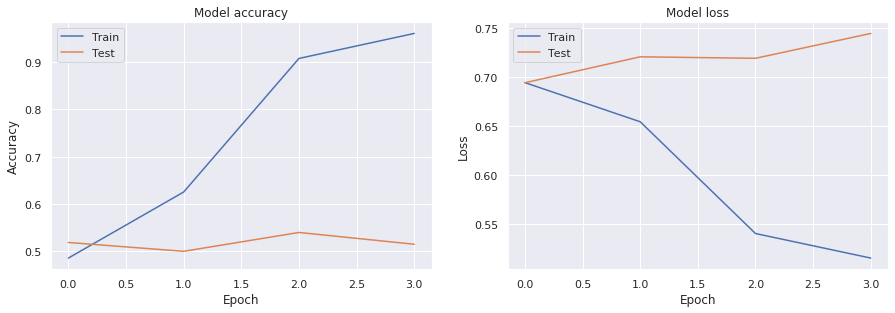

              precision    recall  f1-score   support

    negative       0.49      0.53      0.51       490
    positive       0.50      0.46      0.48       510

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000


The balanced accuracy is : 49.47%


The Zero-one Loss is : 50.6%


Explained variance score: -1.016


ROC AUC=0.516 



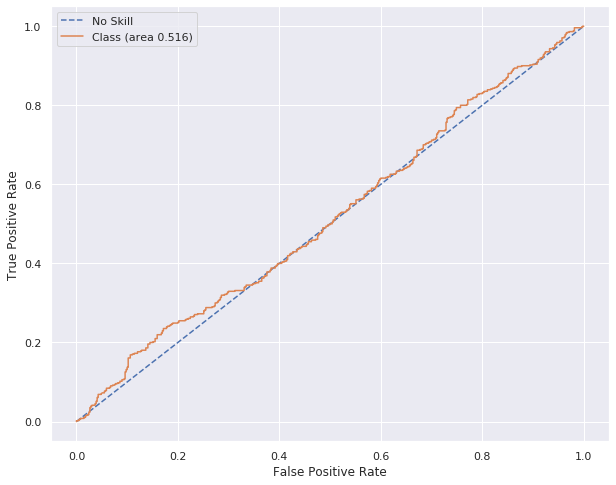



Model: f1-score=0.480 AUC=0.529




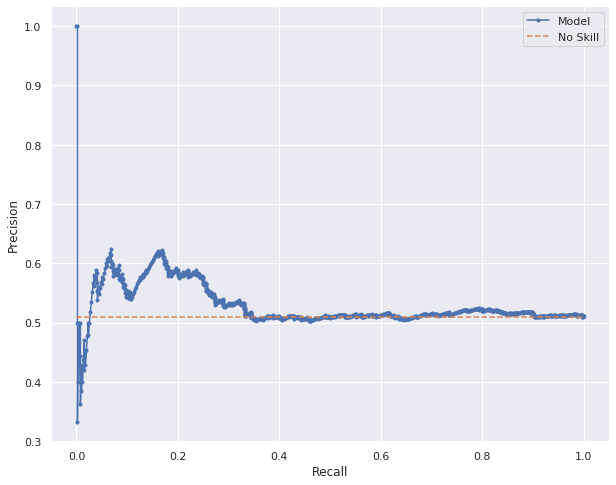


Cohen's kappa: -1.05% 


Confusion Matrix



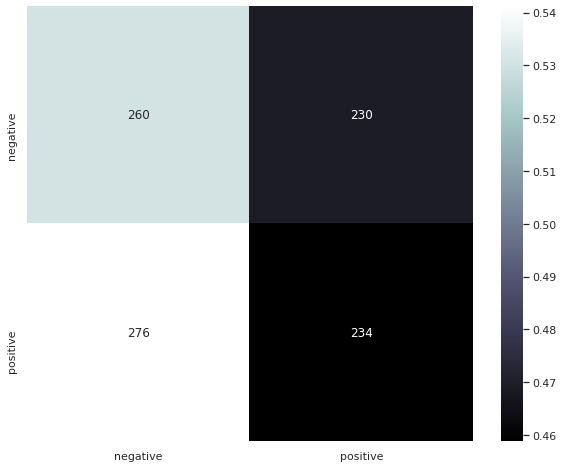

In [121]:
if rnn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Convolutional Neural Network</h2>

---

In [122]:
def create_conv_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a convulational neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(100, 5, activation='relu'), # padding='same'
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(64, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(32, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.GlobalMaxPooling1D(),

    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

In [123]:
if cnn:
    model = create_conv_model(word_index, labels, pre_trained=pre_trained)

In [124]:
if cnn:
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 15s 5ms/sample - loss: 0.7019 - accuracy: 0.4834 - val_loss: 0.7098 - val_accuracy: 0.5175
Epoch 2/50
3200/3200 [==============================] - 13s 4ms/sample - loss: 0.6923 - accuracy: 0.4837 - val_loss: 0.7029 - val_accuracy: 0.5175
Epoch 3/50
3200/3200 [==============================] - 13s 4ms/sample - loss: 0.6905 - accuracy: 0.4837 - val_loss: 0.7031 - val_accuracy: 0.5175
Epoch 4/50
3200/3200 [==============================] - 13s 4ms/sample - loss: 0.6892 - accuracy: 0.4837 - val_loss: 0.7006 - val_accuracy: 0.5175
Epoch 5/50
3200/3200 [==============================] - 14s 4ms/sample - loss: 0.6863 - accuracy: 0.4844 - val_loss: 0.7006 - val_accuracy: 0.5175
Epoch 6/50
3200/3200 [==============================] - 14s 4ms/sample - loss: 0.6799 - accuracy: 0.4897 - val_loss: 0.7002 - val_accuracy: 0.5188
Epoch 7/50
3200/3200 [==============================] - 15s 5ms/sample 

In [125]:
if cnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 1s 993us/sample - loss: 0.5953 - accuracy: 0.8160
[0.595347574710846, 0.816]

The precision of the model is 81.59%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


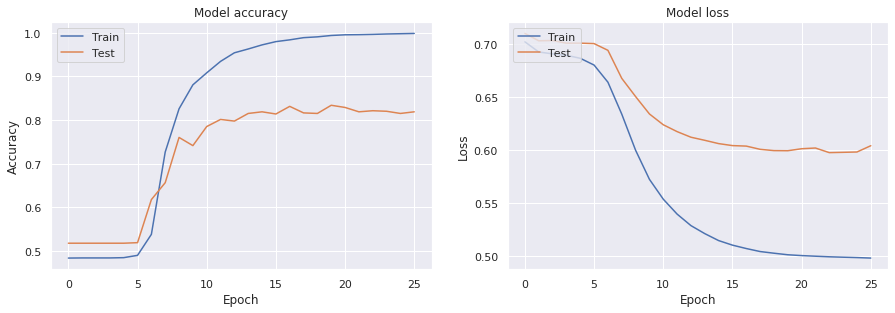

              precision    recall  f1-score   support

    negative       0.82      0.81      0.81       490
    positive       0.82      0.83      0.82       510

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000


The balanced accuracy is : 81.58%


The Zero-one Loss is : 18.4%


Explained variance score: 0.264


ROC AUC=0.899 



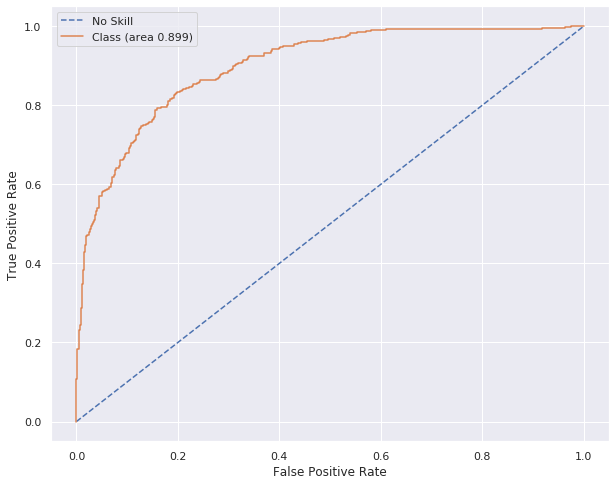



Model: f1-score=0.821 AUC=0.904




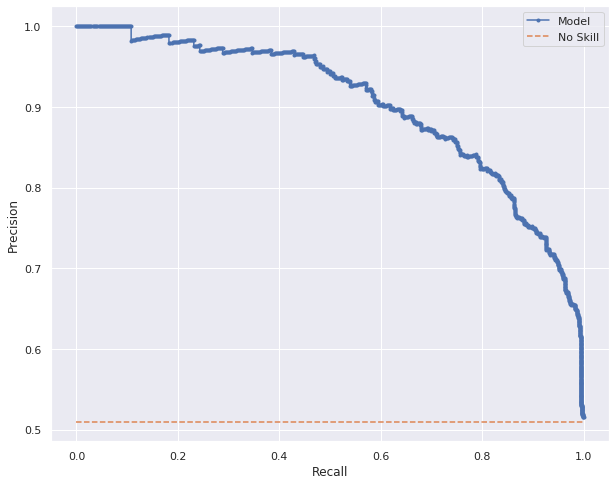


Cohen's kappa: 63.18% 


Confusion Matrix



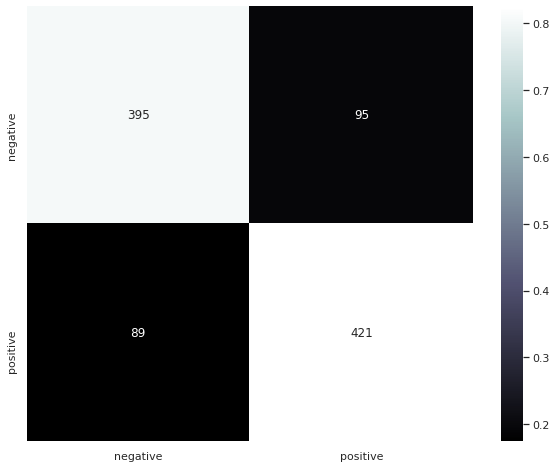

In [126]:
if cnn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Neural Network – LSTM</h2>

---

In [127]:
def create_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) lstm 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.LSTM(32),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [128]:
if lstm:
    model = create_lstm_model(word_index, pre_trained=pre_trained)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         4330300   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 4,347,357
Trainable params: 4,347,357
Non-trainable params: 0
_________________________________________________________________
None
Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 22s 7ms/sample - loss: 0.6979 - accuracy: 0.4834 - val_loss: 0.6938 - val_accuracy: 0.5163
Epoch 2/50
3200/3200 [=====================

In [129]:
if lstm:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.5988 - accuracy: 0.7970
[0.5988306436538696, 0.797]

The precision of the model is 80.89%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


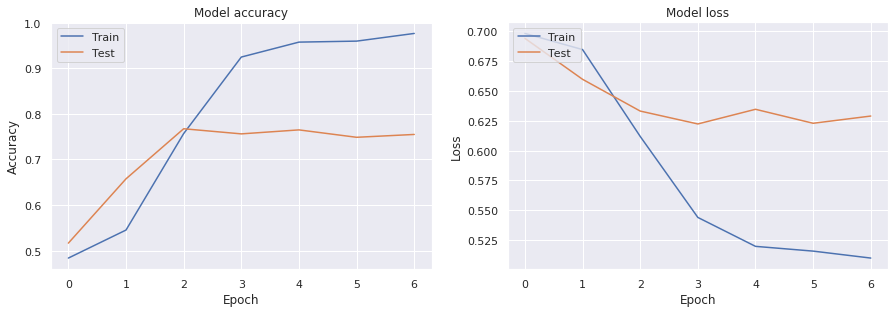

              precision    recall  f1-score   support

    negative       0.79      0.81      0.80       490
    positive       0.81      0.79      0.80       510

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000


The balanced accuracy is : 79.72%


The Zero-one Loss is : 20.3%


Explained variance score: 0.188


ROC AUC=0.873 



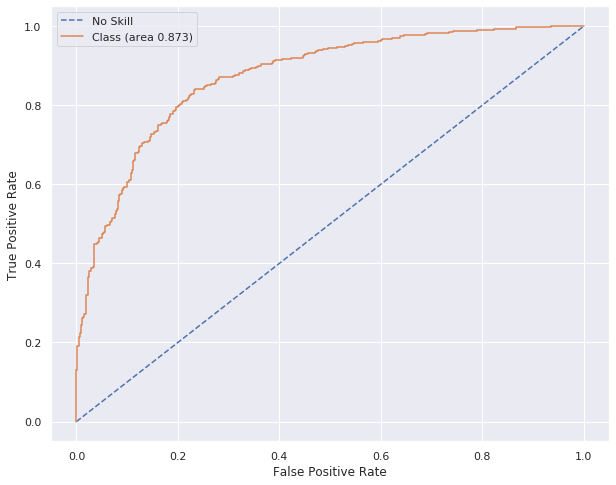



Model: f1-score=0.798 AUC=0.878




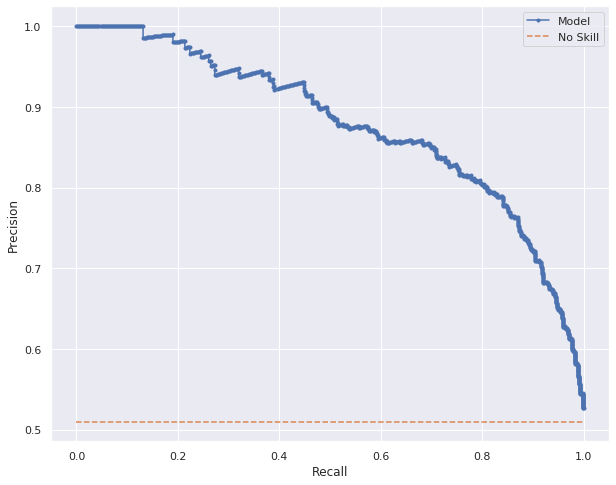


Cohen's kappa: 59.4% 


Confusion Matrix



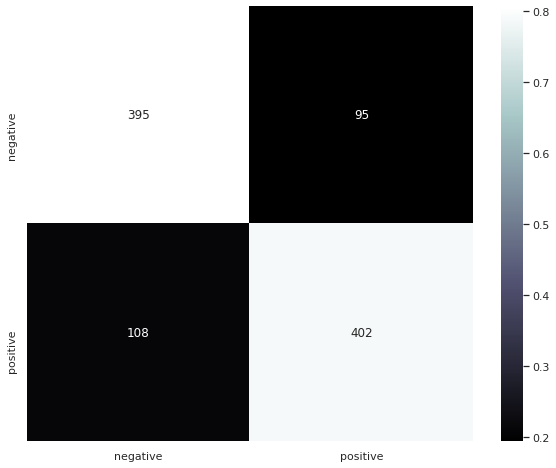

In [130]:
if lstm:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>CNN – LSTM</h2>

---

In [131]:
def create_cnn_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a convulational neural network lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network lstm
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.LSTM(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [132]:
if cnn_lstm:
    model = create_cnn_lstm_model(word_index, pre_trained=pre_trained)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         4330300   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         64128     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 4,415,069
Trainable params: 4,415,069
Non-trainable params: 0
____________________________________________

In [133]:
if cnn_lstm:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.5899 - accuracy: 0.8260
[0.5898637027740479, 0.826]

The precision of the model is 81.23%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


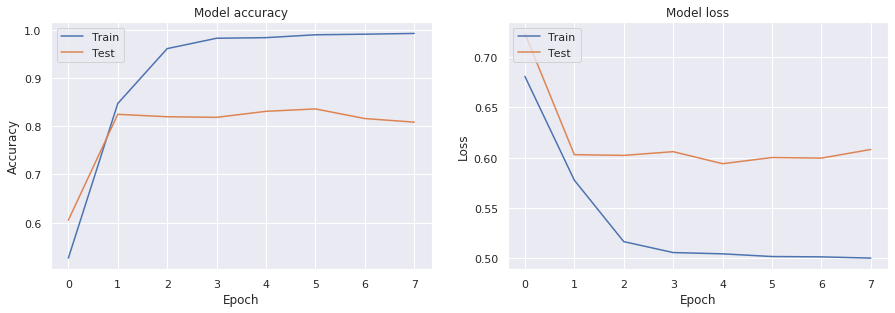

              precision    recall  f1-score   support

    negative       0.84      0.79      0.82       490
    positive       0.81      0.86      0.83       510

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000


The balanced accuracy is : 82.54%


The Zero-one Loss is : 17.4%


Explained variance score: 0.307


ROC AUC=0.895 



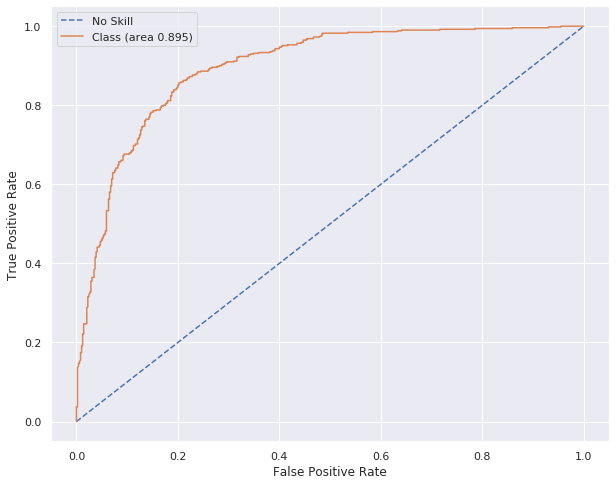



Model: f1-score=0.834 AUC=0.886




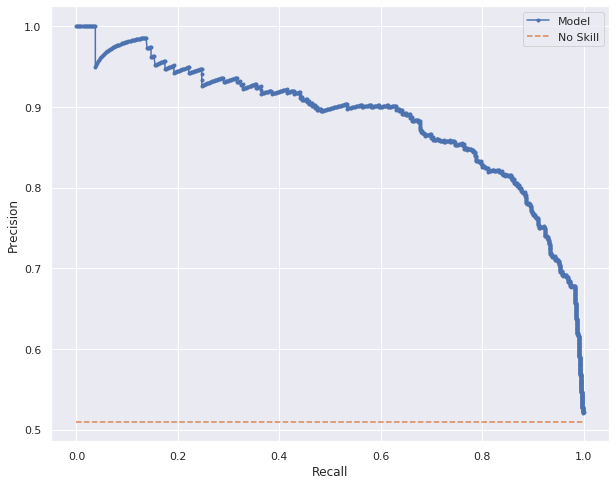


Cohen's kappa: 65.15% 


Confusion Matrix



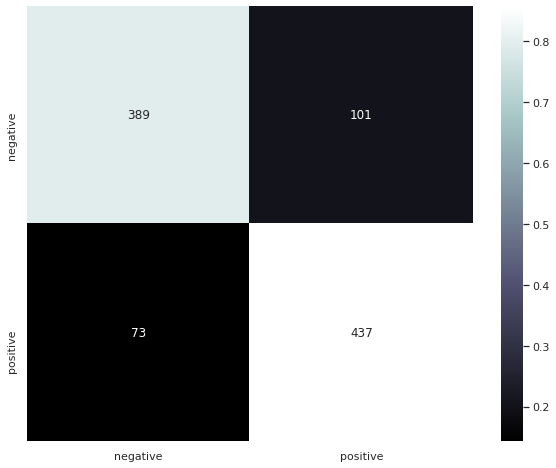

In [134]:
if cnn_lstm:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>CNN – GRU</h2>

---

In [135]:
def create_cnn_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a convulational neural network GRU for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network GRU
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.GRU(32),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [136]:
if cnn_gru:
    model = create_cnn_gru_model(word_index, pre_trained=pre_trained)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         4330300   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         64128     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
gru (GRU)                    (None, 32)                15552     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 4,410,013
Trainable params: 4,410,013
Non-trainable params: 0
____________________________________________

In [137]:
if cnn_gru:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.5990 - accuracy: 0.7940
[0.5989673972129822, 0.794]

The precision of the model is 81.8%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


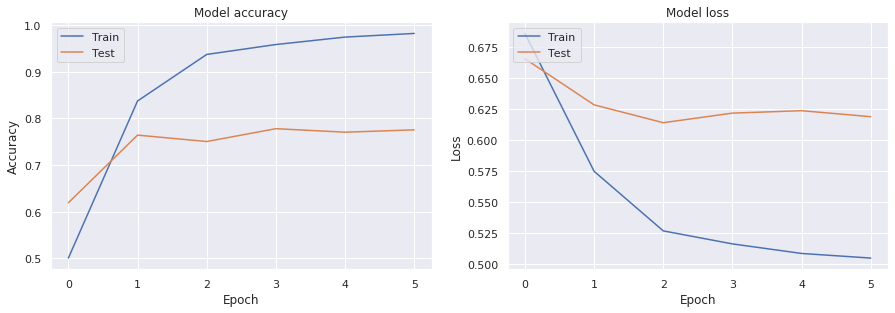

              precision    recall  f1-score   support

    negative       0.77      0.82      0.80       490
    positive       0.82      0.77      0.79       510

    accuracy                           0.79      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.79      0.79      1000


The balanced accuracy is : 79.46%


The Zero-one Loss is : 20.6%


Explained variance score: 0.18


ROC AUC=0.877 



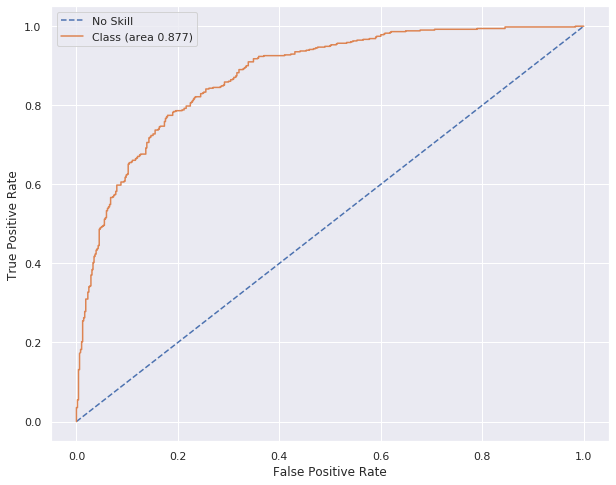



Model: f1-score=0.791 AUC=0.873




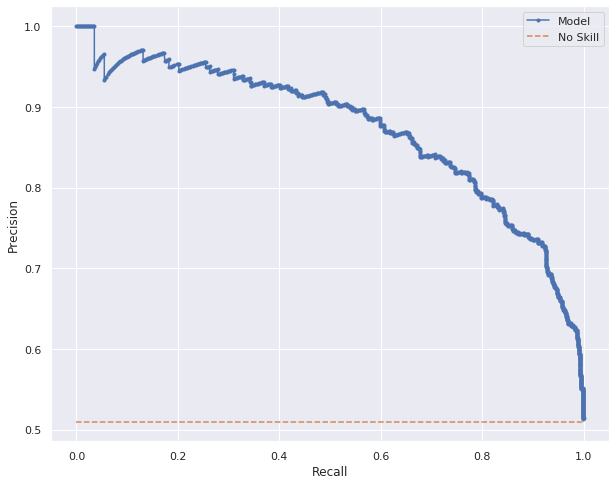


Cohen's kappa: 58.84% 


Confusion Matrix



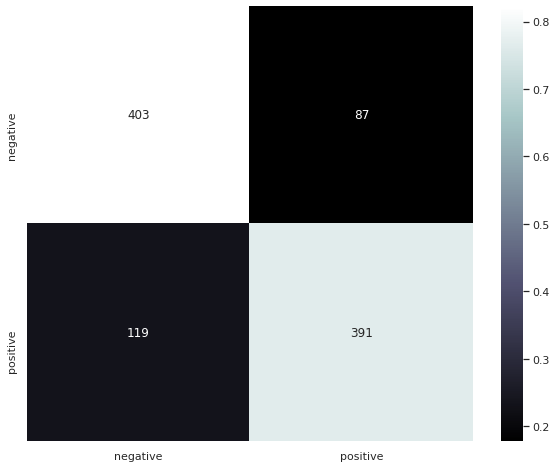

In [138]:
if cnn_gru:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Neural Network – GRU</h2>

---

tf.keras.layers.GRU(
    units, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
    kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    recurrent_constraint=None, bias_constraint=None, dropout=0.0,
    recurrent_dropout=0.0, implementation=2, return_sequences=False,
    return_state=False, go_backwards=False, stateful=False, unroll=False,
    time_major=False, reset_after=True, **kwargs
)

In [139]:
def create_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a gru for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) gru 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.GRU(32),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [140]:
if gru:
    model = create_gru_model(word_index, pre_trained=pre_trained )


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 100)         4330300   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 4,343,197
Trainable params: 4,343,197
Non-trainable params: 0
_________________________________________________________________
None
Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 25s 8ms/sample - loss: 0.6895 - accuracy: 0.4931 - val_loss: 0.6659 - val_accuracy: 0.5650
Epoch 2/50
3200/3200 [=====================

In [141]:
if gru:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 2s 2ms/sample - loss: 0.6043 - accuracy: 0.7820
[0.6042635941505432, 0.782]

The precision of the model is 80.17%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


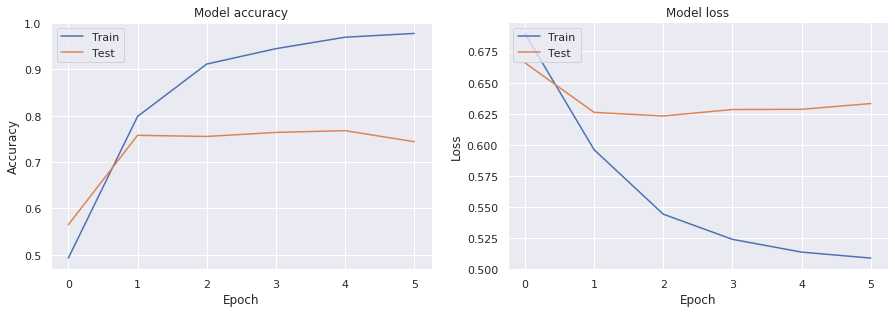

              precision    recall  f1-score   support

    negative       0.76      0.80      0.78       490
    positive       0.80      0.76      0.78       510

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000


The balanced accuracy is : 78.24%


The Zero-one Loss is : 21.8%


Explained variance score: 0.13


ROC AUC=0.850 



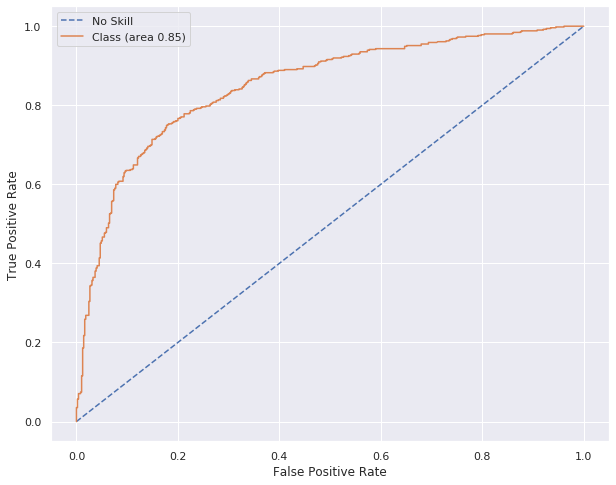



Model: f1-score=0.781 AUC=0.851




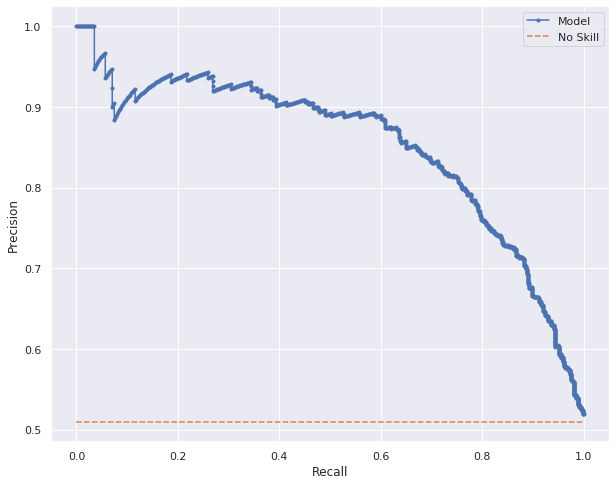


Cohen's kappa: 56.43% 


Confusion Matrix



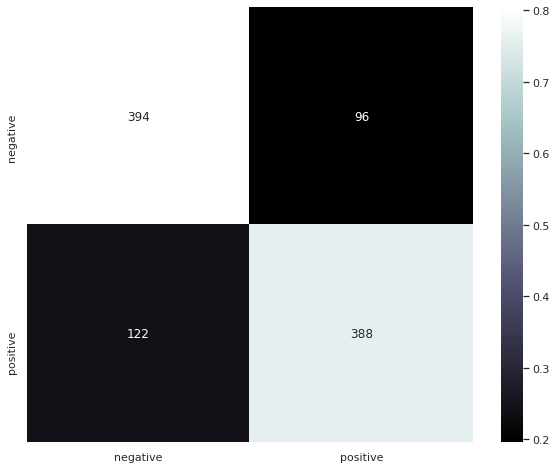

In [142]:
if gru:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Bidirectional RNN</h2>

---

In [143]:
def create_bidirec_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a bidirectional rnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectional rnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [144]:
if bidirectional_rnn:
    model = create_bidirec_rnn_model(word_index, pre_trained=pre_trained)
    
    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         4330300   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8512      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          6208      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          6208      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                6208      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

In [145]:
if bidirectional_rnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 6s 6ms/sample - loss: 0.6843 - accuracy: 0.6290
[0.6843076238632202, 0.629]

The precision of the model is 63.09%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


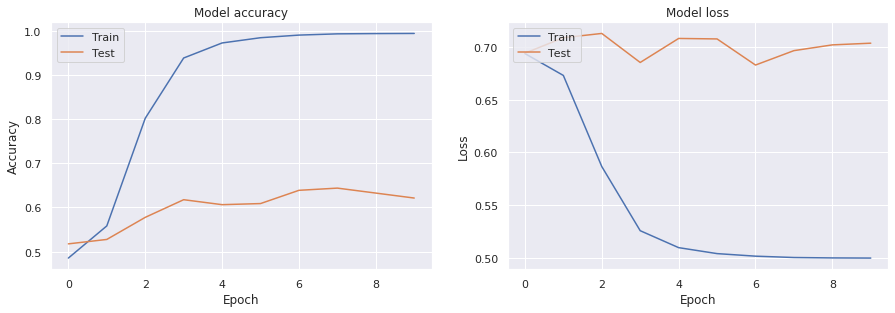

              precision    recall  f1-score   support

    negative       0.63      0.60      0.61       490
    positive       0.63      0.66      0.64       510

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000


The balanced accuracy is : 62.84%


The Zero-one Loss is : 37.1%


Explained variance score: -0.483


ROC AUC=0.667 



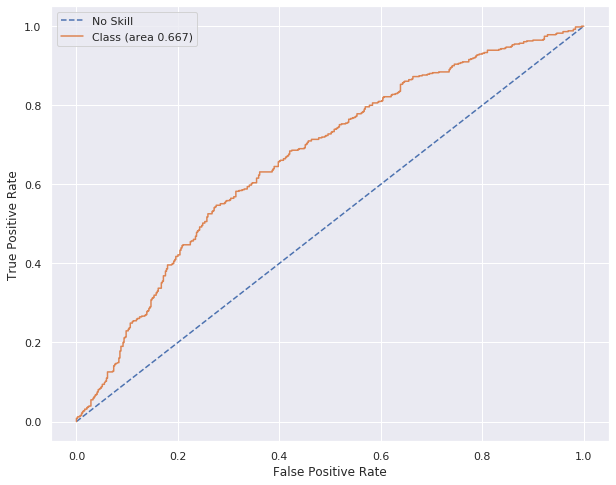



Model: f1-score=0.644 AUC=0.641




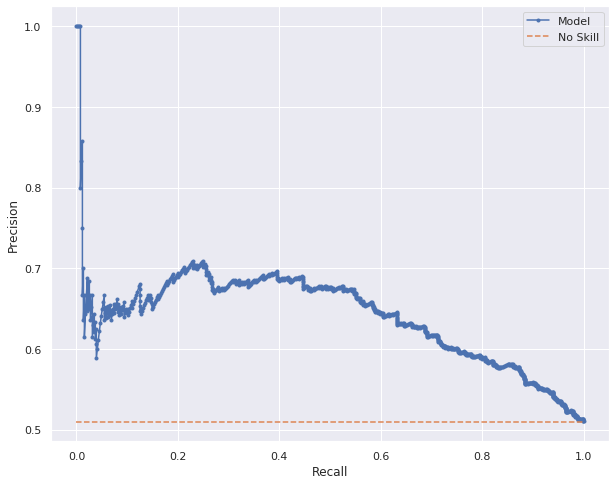


Cohen's kappa: 25.71% 


Confusion Matrix



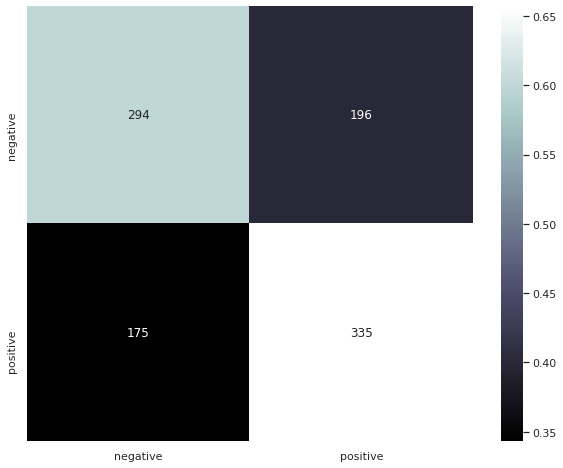

In [146]:
if bidirectional_rnn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Bidirectional LSTM</h2>

---

In [147]:
def create_bidirec_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a bidirectional lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectional lstm
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [148]:
if bidirectional_lstm:
    model = create_bidirec_lstm_model(word_index, pre_trained=pre_trained)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 100)         4330300   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                34048     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 4,364,413
Trainable params: 4,364,413
Non-trainable params: 0
_________________________________________________________________
None
Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 31s 10ms/sample - loss: 0.6947 - accuracy: 0.4837 - val_loss: 0.6878 - val_accuracy: 0.5175
Epoch 2/50
3200/3200 [===================

In [149]:
if bidirectional_lstm:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 4s 4ms/sample - loss: 0.6000 - accuracy: 0.7970
[0.5999824738502503, 0.797]

The precision of the model is 80.4%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


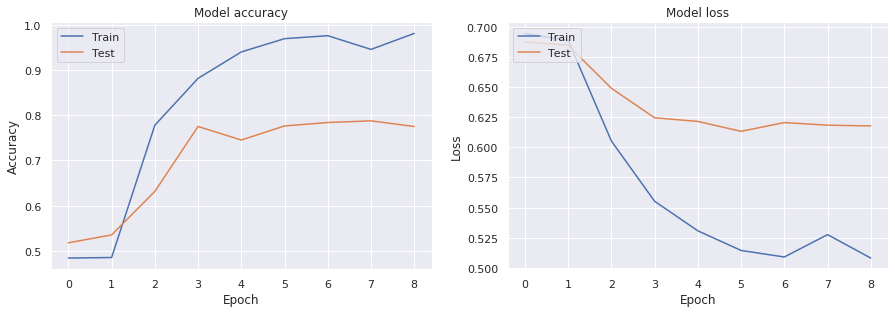

              precision    recall  f1-score   support

    negative       0.79      0.80      0.79       490
    positive       0.80      0.80      0.80       510

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000


The balanced accuracy is : 79.7%


The Zero-one Loss is : 20.3%


Explained variance score: 0.188


ROC AUC=0.868 



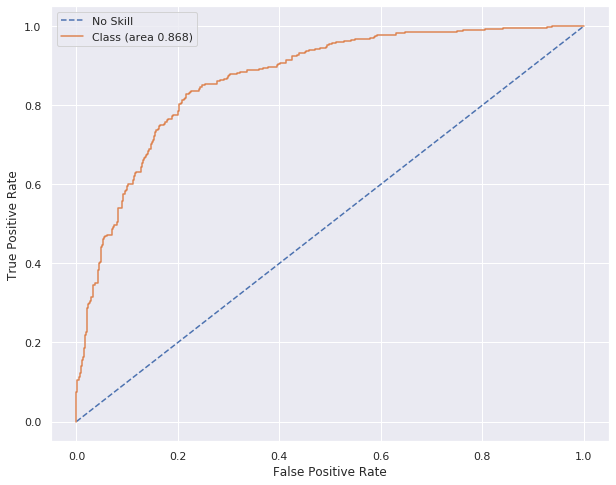



Model: f1-score=0.800 AUC=0.861




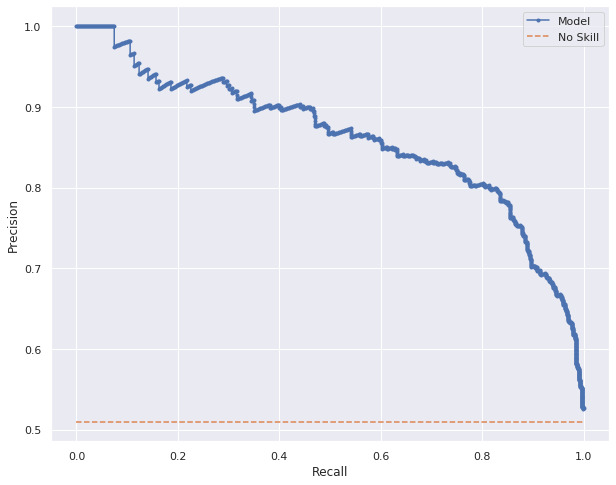


Cohen's kappa: 59.39% 


Confusion Matrix



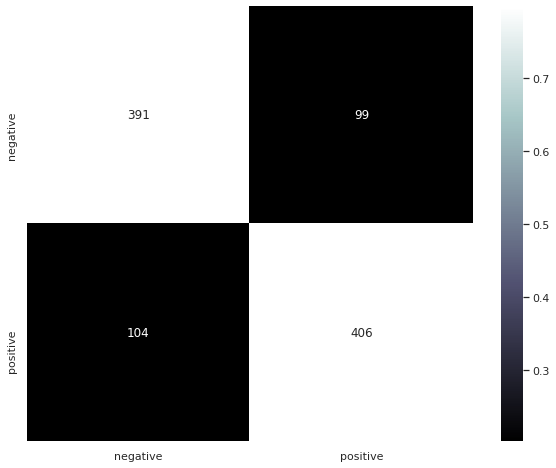

In [150]:
if bidirectional_lstm:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Bidirectional GRU</h2>

---

In [151]:
def create_bidirec_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a bidirectional gru for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectional gru
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.GRU(32)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [152]:
if bidirectional_gru:
    model = create_bidirec_gru_model(word_index, pre_trained=pre_trained)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 100)         4330300   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                25728     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 4,356,093
Trainable params: 4,356,093
Non-trainable params: 0
_________________________________________________________________
None
Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 38s 12ms/sample - loss: 0.6957 - accuracy: 0.4816 - val_loss: 0.6874 - val_accuracy: 0.5188
Epoch 2/50
3200/3200 [===================

In [153]:
if bidirectional_gru:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 4s 4ms/sample - loss: 0.6118 - accuracy: 0.7770
[0.6118237965106964, 0.777]

The precision of the model is 76.92%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


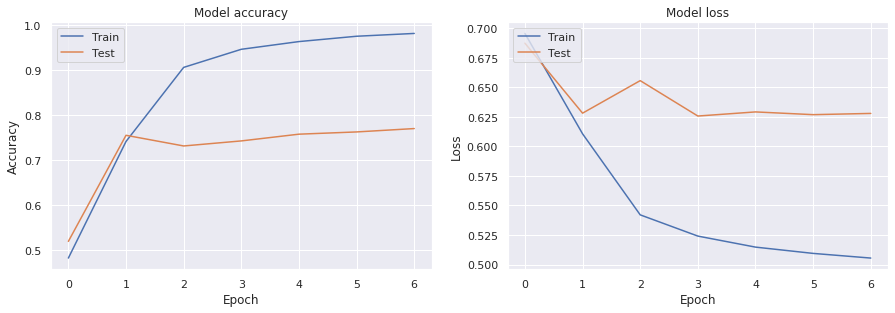

              precision    recall  f1-score   support

    negative       0.79      0.75      0.77       490
    positive       0.77      0.80      0.79       510

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000


The balanced accuracy is : 77.65%


The Zero-one Loss is : 22.3%


Explained variance score: 0.11


ROC AUC=0.852 



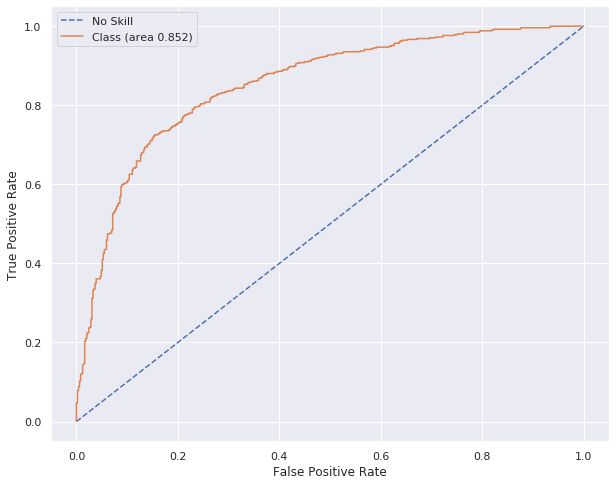



Model: f1-score=0.786 AUC=0.848




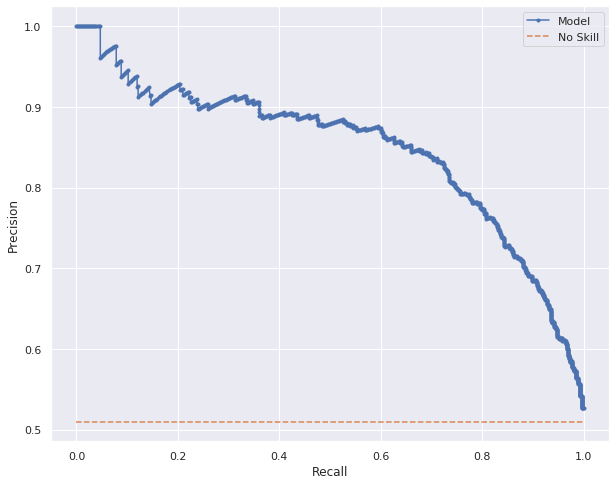


Cohen's kappa: 55.34% 


Confusion Matrix



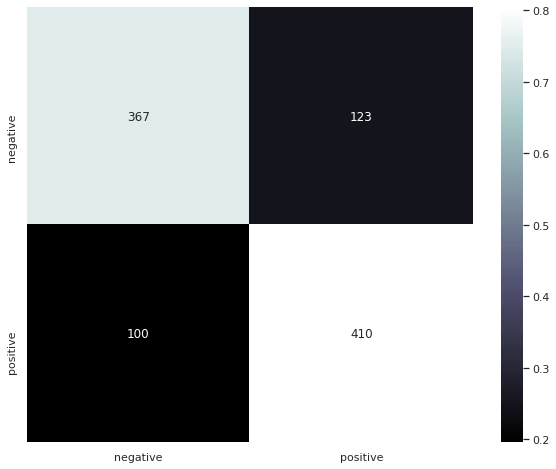

In [154]:
if bidirectional_gru:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Convolutional Neural Network</h2>

---

In [155]:
def create_rcnn(X, word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300,input_length=X.shape[1], weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True)),
    keras.layers.Convolution1D(32, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [156]:
if rcnn:
    model = create_rcnn(train_seq_x, word_index,  pre_trained = pre_trained)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 100)         4330300   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 100)         0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 64)          25728     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          6176      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 25)                825       
_________________________________________________________________
dropout_10 (Dropout)         (None, 25)              

In [157]:
if rcnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 5s 5ms/sample - loss: 0.6023 - accuracy: 0.8070
[0.6023441820144654, 0.807]

The precision of the model is 77.86%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


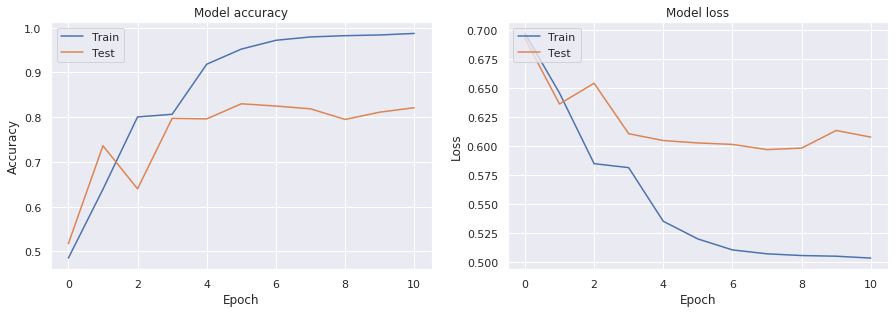

              precision    recall  f1-score   support

    negative       0.84      0.74      0.79       490
    positive       0.78      0.87      0.82       510

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000


The balanced accuracy is : 80.57%


The Zero-one Loss is : 19.3%


Explained variance score: 0.242


ROC AUC=0.899 



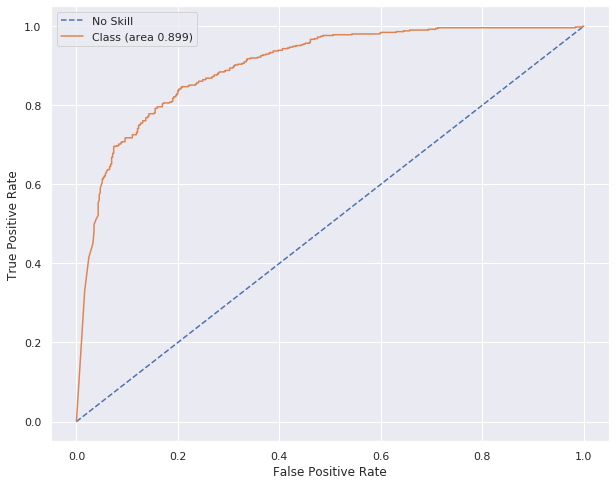



Model: f1-score=0.821 AUC=0.901




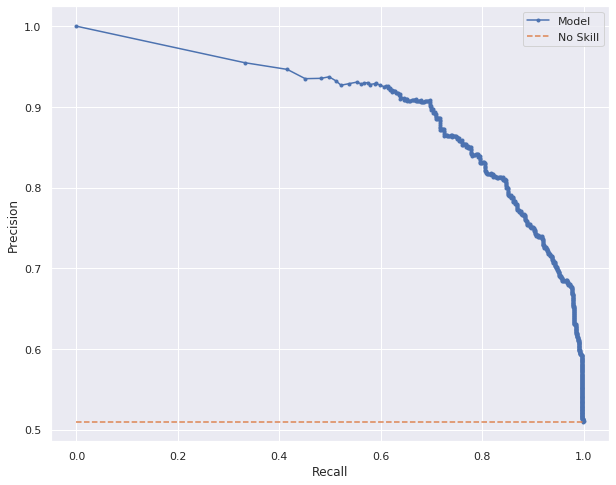


Cohen's kappa: 61.29% 


Confusion Matrix



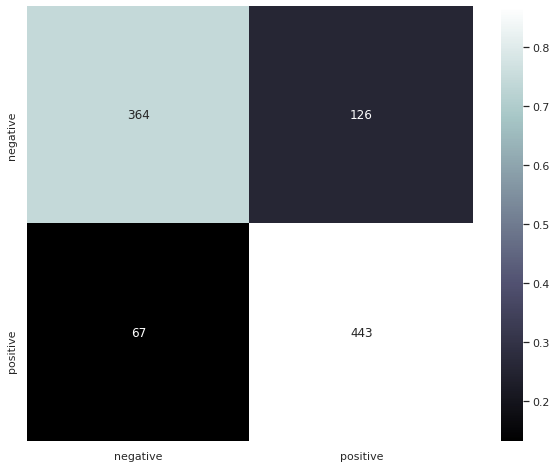

In [158]:
if rcnn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Convolutional Neural Network variation 1</h2>

---

In [159]:
def create_rcnn_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True)),
    keras.layers.Convolution1D(32, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [160]:
if rcnn:
    model = create_rcnn_var1(word_index, pre_trained = pre_trained)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 100)         4330300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 100)         0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 64)          34048     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          6176      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 25)                825       
_________________________________________________________________
dropout_11 (Dropout)         (None, 25)              

In [161]:
if rcnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 4s 4ms/sample - loss: 0.6819 - accuracy: 0.5430
[0.6818743696212769, 0.543]

The precision of the model is 70.87%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


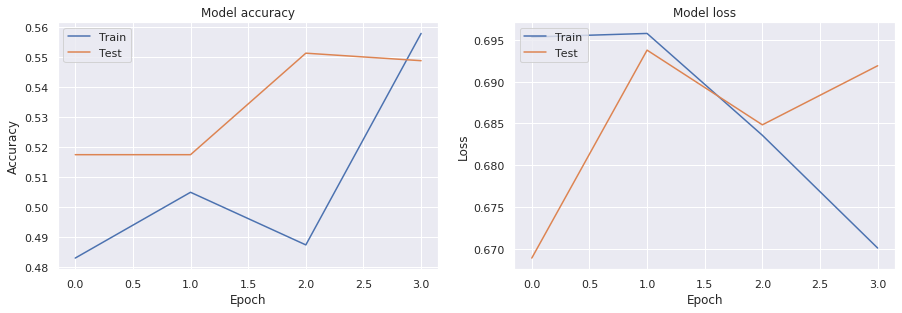

              precision    recall  f1-score   support

    negative       0.52      0.92      0.66       490
    positive       0.71      0.18      0.28       510

    accuracy                           0.54      1000
   macro avg       0.61      0.55      0.47      1000
weighted avg       0.62      0.54      0.47      1000


The balanced accuracy is : 55.05%


The Zero-one Loss is : 45.7%


Explained variance score: -0.242


ROC AUC=0.708 



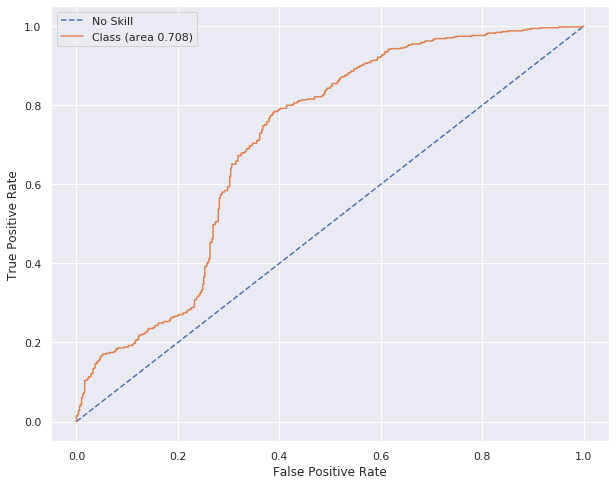



Model: f1-score=0.283 AUC=0.673




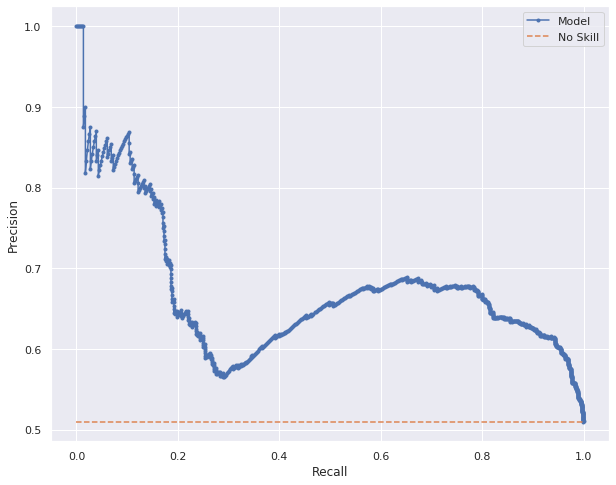


Cohen's kappa: 9.94% 


Confusion Matrix



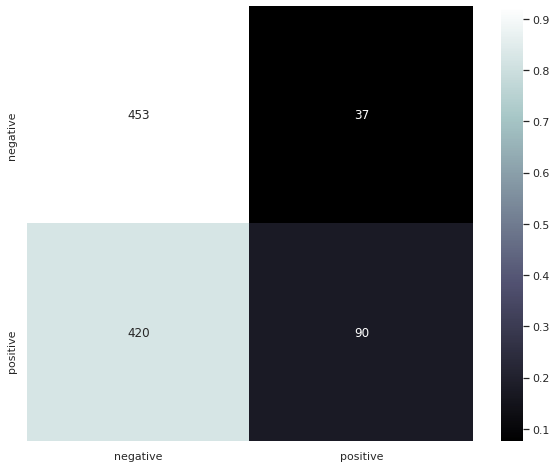

In [162]:
if rcnn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Convulational Neural Network variation 2</h2>

---

In [163]:
def create_rcnn_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True)),
    keras.layers.Convolution1D(32, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [164]:
if rcnn:
    model = create_rcnn_var2(word_index,  pre_trained = pre_trained)

    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 100)         4330300   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, None, 100)         0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 64)          25728     
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 64)          18816     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          6176      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 25)              

In [165]:
if rcnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 6s 6ms/sample - loss: 0.6140 - accuracy: 0.7650
[0.614039183139801, 0.765]

The precision of the model is 78.0%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


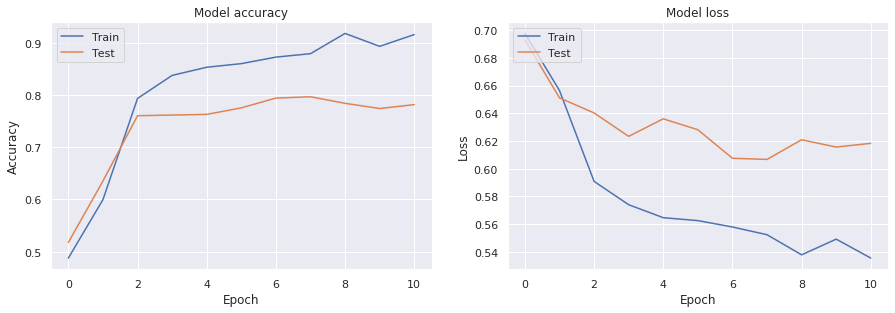

              precision    recall  f1-score   support

    negative       0.75      0.78      0.76       490
    positive       0.78      0.75      0.77       510

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.76      1000
weighted avg       0.77      0.77      0.77      1000


The balanced accuracy is : 76.53%


The Zero-one Loss is : 23.5%


Explained variance score: 0.061


ROC AUC=0.855 



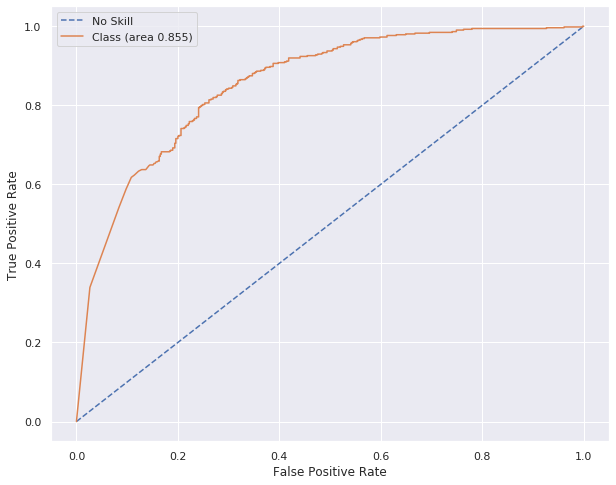



Model: f1-score=0.765 AUC=0.859




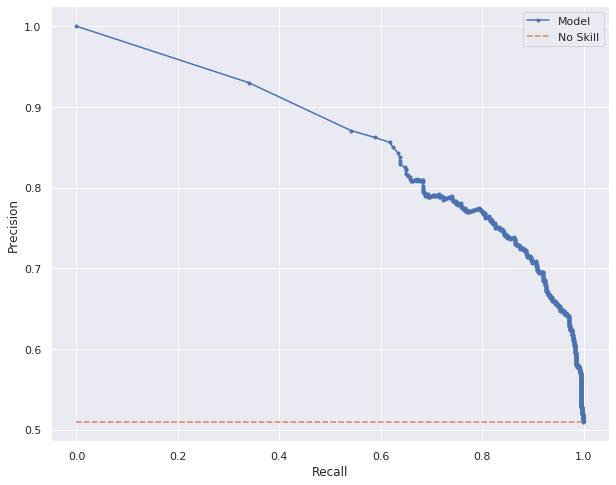


Cohen's kappa: 53.02% 


Confusion Matrix



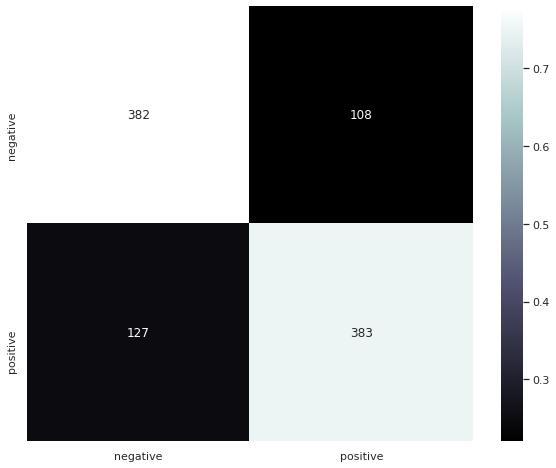

In [166]:
if rcnn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Recurrent Convulational Neural Network variation 3</h2>

---

In [167]:
def create_rcnn_var3(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True)),
    keras.layers.Convolution1D(32, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model

In [168]:
if rcnn:
    model = create_rcnn_var3(word_index,  pre_trained = pre_trained)


    history = model.fit(train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 100)         4330300   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, None, 100)         0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, None, 64)          25728     
_________________________________________________________________
bidirectional_11 (Bidirectio (None, None, 64)          24832     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          6176      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 25)              

In [169]:
if rcnn:
    results = model.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 6s 6ms/sample - loss: 0.5976 - accuracy: 0.8100
[0.59764954662323, 0.81]

The precision of the model is 80.19%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['negative', 'positive'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


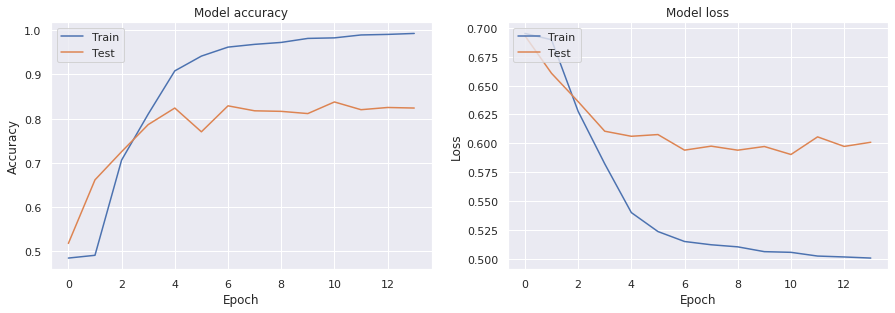

              precision    recall  f1-score   support

    negative       0.82      0.79      0.80       490
    positive       0.80      0.83      0.82       510

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000


The balanced accuracy is : 80.95%


The Zero-one Loss is : 19.0%


Explained variance score: 0.241


ROC AUC=0.887 



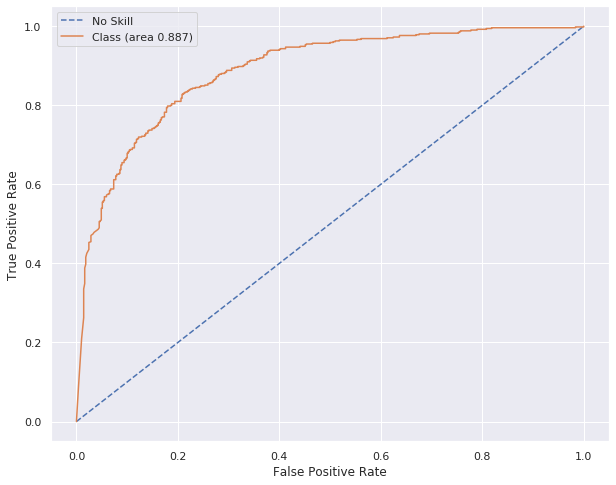



Model: f1-score=0.817 AUC=0.887




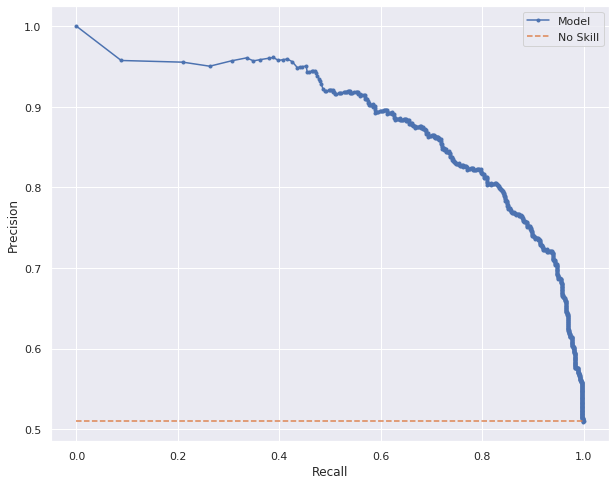


Cohen's kappa: 61.95% 


Confusion Matrix



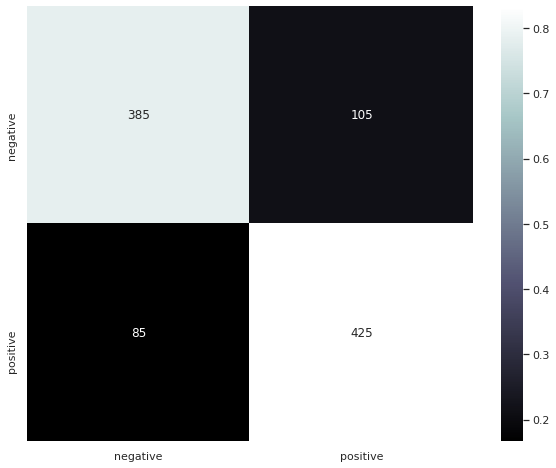

In [170]:
if rcnn:
    Metric.metrics_deep_learning(model, history, valid_seq_x, valid_y, labels)

---

<h2>Transformers</h2>

Tutorial available on Keras documentation, code example written by Apoorv Nandan (<a href="https://keras.io/examples/nlp/text_classification_with_transformer/">source: kears.io</a>)

---

In [11]:
from tensorflow.keras import layers

In [12]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [13]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [14]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, emded_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=emded_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=emded_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [68]:
def transformers_classifier(word_index, label=labels):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    vocab_size = len(word_index)+1
    maxlen = 300
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    #outputs = layers.Dense(1, activation="sigmoid")(x)
    
    outputs = keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model


In [62]:
if transformers:
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    vocab_size = len(word_index)+1
    maxlen = 300
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

In [69]:
if transformers:
    model_transformers = transformers_classifier(word_index, label=labels)
    
    history = model_transformers.fit(
    train_seq_x, train_y,
                    epochs=50, callbacks=[es],
                    validation_split=0.2, batch_size=32
    )

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
token_and_position_embedding (None, 300, 32)           1926144   
_________________________________________________________________
transformer_block_5 (Transfo (None, 300, 32)           6464      
_________________________________________________________________
global_average_pooling1d_5 ( (None, 32)                0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 20)                660       
_________________________________________________________________
dropout_23 (Dropout)         (None, 20)                0   

In [65]:
if transformers:
    results = model_transformers.evaluate(valid_seq_x, valid_y)

    print(results)
    print(f"\nThe precision of the model is {round(100*precision_score(valid_y, (model_transformers.predict(valid_seq_x)>0.5).astype(int), labels),2)}%")

1000/1000 [==============================] - 1s 1ms/sample - loss: 0.5466 - accuracy: 0.8720
[0.5465963907241821, 0.872]

The precision of the model is 89.98%


/home/chris/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['annulation', 'other'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
